# Implementación del modelo S2S con atención para detección de intenciones e identificación de entidades

Script de implementación del modelo "sequence to sequence" (seq2seq) con atención para detectar intenciones e identificar las entidades en oraciones extraídas a partir de los conjuntos de datos:
* ATIS
* Conversaciones para el chatbot de la DCTT del INICTEL-UNI.

In [1]:
# Se instala el paquete seqevals para calcular las métricas de evaluación para secuencias
! pip install seqeval

     |████████████████████████████████| 43 kB 1.0 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16181 sha256=17f74891e77a50b67b80d78206f7edcaa01a8182612e41da31ab82a262503819
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [2]:
# Paquetes a importar
import os
import pickle
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from random import shuffle
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
import multiprocessing
import numpy as np
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Input, Dropout, Bidirectional, Dense, AdditiveAttention, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model
from keras.callbacks import Callback
from seqeval.metrics import f1_score, classification_report
from seqeval.scheme import IOB2
import sklearn

## 1. Obtención del corpus

In [3]:
# Se clona el repositorio donde está el corpus
!git clone https://github.com/ProjectDeepLearning2021/JoinIntentDetectionSlotFilling.git cloned-repo

Cloning into 'cloned-repo'...
remote: Enumerating objects: 223, done.
remote: Counting objects: 100% (223/223), done.
remote: Compressing objects: 100% (180/180), done.
remote: Total 223 (delta 60), reused 134 (delta 34), pack-reused 0
Receiving objects: 100% (223/223), 22.76 MiB | 18.93 MiB/s, done.
Resolving deltas: 100% (60/60), done.


## 2. Creación del Conjunto de Datos

In [4]:
class SFID_ATIS_Dataset:
  def __init__(self):
    self.word_tokenizer = None
    self.entity_tokenizer = None
    self.intent_tokenizer = None
  
  def preprocess_dataset(self, data, padding):
    # Secuencia de palabras: BOS x1 x2 x3 x4 (EOS si es postpadding)
    # Secuencia de entidades: e1 e2 e3 e4
    data = [d[:-1] for d in data]
    data = [[d.split('\t')[0].split(' '), d.split('\t')[1].split(' ')[:-1], d.split('\t')[1].split(' ')[-1]] for d in data]
    if padding == 'post':
      data = [[d[0], d[1][1:], d[2]] for d in data]
    elif padding == 'pre':
      data = [[d[0][0:-1], d[1][1:], d[2]] for d in data]
    word_seqs, entity_seqs, intents = list(zip(*data))
    return list(word_seqs), list(entity_seqs), list(intents)
  
  def create_dataset(self, path, dataset, padding):
    if dataset == 'train':
      data = open(path + 'atis-2.train.w-intent.iob', 'r').readlines()
      word_seqs, entity_seqs, intents = self.preprocess_dataset(data, padding)
    elif dataset == 'val':
      data = open(path + 'atis-2.dev.w-intent.iob', 'r').readlines()
      word_seqs, entity_seqs, intents = self.preprocess_dataset(data, padding)
    return word_seqs, entity_seqs, intents
  
  def tokenize(self, word_seqs, entity_seqs, intents):
    word_tokenizer = Tokenizer(filters='\n', oov_token='UNK', lower=False)
    word_tokenizer.fit_on_texts(word_seqs)
    word_tokenizer.word_index['PAD'] = 0
    word_tokenizer.index_word[0] = 'PAD'
    entity_tokenizer = Tokenizer(filters='\n', oov_token='UNK', lower=False)
    entity_tokenizer.fit_on_texts(entity_seqs)
    entity_tokenizer.word_index['PAD'] = 0
    entity_tokenizer.index_word[0] = 'PAD'
    intent_tokenizer = Tokenizer(filters='\n')
    intent_tokenizer.fit_on_texts(intents)
    intent_tokenizer_word_index = dict()
    intent_tokenizer_index_word = dict()
    for word, i in intent_tokenizer.word_index.items():
      intent_tokenizer_word_index[word] = i - 1
      intent_tokenizer_index_word[i - 1] = word
    intent_tokenizer.word_index = intent_tokenizer_word_index
    intent_tokenizer.index_word = intent_tokenizer_index_word
    return word_tokenizer, entity_tokenizer, intent_tokenizer
  
  def prepare_entities(self, text):
    text_inp = text.copy()
    text_out = text.copy()
    for i, txt in enumerate(text):
      text_inp[i] = ['BOS'] + txt
      text_out[i] = txt + ['EOS']
    return text_inp, text_out
  
  def prepare_sequences(self, text, tokenizer, sequence, padding='pre', max_seq_len=0):
    if sequence == 'word':
      seqs = pad_sequences(tokenizer.texts_to_sequences(text), maxlen=max_seq_len, padding=padding, truncating=padding)
      text = tokenizer.sequences_to_texts(seqs)
      return seqs, text
    elif sequence == 'entity':
      text_inp, text_out = self.prepare_entities(text)
      seqs_inp = pad_sequences(tokenizer.texts_to_sequences(text_inp), maxlen=max_seq_len, padding=padding, truncating=padding)
      seqs_out = pad_sequences(tokenizer.texts_to_sequences(text_out), maxlen=max_seq_len, padding=padding, truncating=padding)
      text_inp = tokenizer.sequences_to_texts(seqs_inp)
      return seqs_inp, seqs_out, text_inp
  
  def prepare_intents(self, text, tokenizer):
    seqs = np.asarray(tokenizer.texts_to_sequences(text))
    text = tokenizer.sequences_to_texts(seqs)
    return seqs, text
  
  def train_val_config_sequence(self, ws, es_inp, es_out, i):
    return {'ws_inp':ws, 'es_inp':es_inp}, {'es_out':es_out, 'i_out':i}

  def call(self, path, padding, max_seq_len, batch_size):
    # Obtención del conjunto de datos
    train_ws, train_es, train_i = self.create_dataset(path, 'train', padding)
    val_ws, val_es, val_i = self.create_dataset(path, 'val', padding)
    # Tokenización
    word_tokenizer, entity_tokenizer, intent_tokenizer = self.tokenize(train_ws, train_es + val_es, train_i + val_i)
    # Obtención de las secuencias y textos
    train_ws, train_wt = self.prepare_sequences(train_ws, word_tokenizer, 'word', padding, max_seq_len=max_seq_len)
    val_ws, val_wt = self.prepare_sequences(val_ws, word_tokenizer, 'word', padding, max_seq_len=max_seq_len)
    train_es_inp, train_es_out, train_et_inp = self.prepare_sequences(train_es, entity_tokenizer, 'entity', padding, max_seq_len=max_seq_len)
    val_es_inp, val_es_out, val_et_inp = self.prepare_sequences(val_es, entity_tokenizer, 'entity', padding, max_seq_len=max_seq_len)
    train_i, train_it = self.prepare_intents(train_i, intent_tokenizer)
    val_i, val_it = self.prepare_intents(val_i, intent_tokenizer)
    # Conformación de los datasets
    train_dataset = tf.data.Dataset.from_tensor_slices((train_ws, train_es_inp, train_es_out, train_i))
    train_dataset = train_dataset.shuffle(train_ws.shape[0], reshuffle_each_iteration=True).map(self.train_val_config_sequence).batch(batch_size, drop_remainder=True).prefetch(2)
    val_dataset = tf.data.Dataset.from_tensor_slices((val_ws, val_es_inp, val_es_out, val_i))
    val_dataset = val_dataset.shuffle(val_ws.shape[0], reshuffle_each_iteration=True).map(self.train_val_config_sequence).batch(batch_size*2, drop_remainder=True).prefetch(2)
    # Diccionario del conjunto de datos
    dic_dataset = {'wt':train_wt, 'et':train_et_inp + val_et_inp, 'it':train_it, 'word_tok':word_tokenizer, 'entity_tok':entity_tokenizer, 'intent_tok':intent_tokenizer}
    return train_dataset, val_dataset, dic_dataset

In [5]:
corpus_path = 'cloned-repo/Entregables/Entregable03/data/ATIS/'
padding = 'post'
max_seq_len = 50
batch_size = 32

dataset_creator = SFID_ATIS_Dataset()
train_dataset, val_dataset, dic_dataset = dataset_creator.call(corpus_path, padding, max_seq_len, batch_size)

## 3. Inicialización de los Embeddings

In [6]:
word_corpus = []
for wt in dic_dataset['wt']:
  word_corpus.append(wt.split())
word_tokenizer = dic_dataset['word_tok']
word_emb_dim = 128

w2v = Word2Vec(word_corpus, size=word_emb_dim, window=5, min_count=1, negative=15, iter=30, workers=multiprocessing.cpu_count())
w_embeddings = w2v.wv.vectors
word_emb_mat = np.zeros((len(word_tokenizer.word_index), word_emb_dim))
for i, word in enumerate(word_tokenizer.word_index.keys()):
  if word == 'UNK':
    word_emb_mat[i] = w_embeddings.mean(0)
  else:
    word_emb_vec = w2v.wv[word]
    if word_emb_vec is not None:
      word_emb_mat[i] = word_emb_vec

entity_corpus = []
for et in dic_dataset['et']:
  entity_corpus.append(et.split())
entity_tokenizer = dic_dataset['entity_tok']
entity_emb_dim = len(entity_tokenizer.word_counts) // 3

e2v = Word2Vec(entity_corpus, size=entity_emb_dim, window=5, min_count=1, negative=15, iter=30, workers=multiprocessing.cpu_count())
e_embeddings = e2v.wv.vectors
entity_emb_mat = np.zeros((len(entity_tokenizer.word_index), entity_emb_dim))
for i, entity in enumerate(entity_tokenizer.word_index.keys()):
  entity_emb_vec = e2v.wv[entity]
  if entity_emb_vec is not None:
    entity_emb_mat[i] = entity_emb_vec

## 4. Creación del Modelo

In [7]:
# Se crea el modelo sequence to sequence con atención
def s2s_model(num_intents, word_emb_mat, entity_emb_mat, max_seq_len, latent_dim, do):
  num_words = word_emb_mat.shape[0]
  num_entities = entity_emb_mat.shape[0]
  word_emb_dim = word_emb_mat.shape[1]
  entity_emb_dim = entity_emb_mat.shape[1]
  #---------
  # ENCODER
  #---------
  # Input layer
  enc_inp_w = Input(shape=(None,), name='ws_inp') # (bs, t, 1)
  # Embedding layer
  w_emb_layer = Embedding(input_dim=num_words, output_dim=word_emb_dim, weights=[word_emb_mat], mask_zero=True, trainable=True, name='word_embedding')
  enc_emb_w = w_emb_layer(enc_inp_w) # (bs, t, we_dim)
  # Bidirectional LSTM layer
  do_enc_emb_layer = Dropout(rate=do)
  forward_LSTM_encoder = LSTM(latent_dim, return_state=True, return_sequences=True, name='forward_LSTM')
  backward_LSTM_encoder = LSTM(latent_dim, return_state=True, return_sequences=True, go_backwards=True, name='backward_LSTM')
  BiLSTM_encoder = Bidirectional(forward_LSTM_encoder, backward_layer=backward_LSTM_encoder, name='BiLSTM')
  do_enc_out_layer = Dropout(rate=do)
  do_enc_emb_w = do_enc_emb_layer(enc_emb_w, training=True) # (bs, t, we_dim)
  enc_out, forward_h, forward_c, backward_h, backward_c = BiLSTM_encoder(do_enc_emb_w) # (bs, t, 2*ld), (bs, 1, ld)...
  do_enc_out = do_enc_out_layer(enc_out, training=True) # (bs, t, 2*ld)
  # Dense layer for states transfering
  dense_s0 = Dense(latent_dim, activation='tanh', name='dense_s0_init')
  dense_c0 = Dense(latent_dim, activation='tanh', name='dense_c0_init')
  dec_s_init = dense_s0(backward_h) # (bs, 1, ld)
  dec_c_init = dense_c0(backward_c) # (bs, 1, ld)
  dec_states_init = [dec_s_init, dec_c_init]
  #-----------
  # ATTENTION
  #-----------
  # Attention layer for entity sequence decoder
  dense_query_att_e = Dense(2*latent_dim, activation='linear', use_bias=False, name='dense_query_att_e')
  dense_key_att_e = Dense(2*latent_dim, activation='linear', use_bias=False, name='dense_key_att_e')
  attention_e = AdditiveAttention(name='Attention_e')
  query_att_e = dense_query_att_e(dec_s_init) # (bs, 1, 2*ld)
  key_att_e = dense_key_att_e(do_enc_out) # (bs, t, 2*ld)
  c_attention_e = attention_e([tf.expand_dims(query_att_e, axis=1), do_enc_out, key_att_e]) # (bs, 1, 2*ld)
  context_e = tf.repeat(c_attention_e, repeats=[max_seq_len], axis=1) # (bs, t, 2*ld)
  # Attention layer for intent decoder
  dense_query_att_i = Dense(2*latent_dim, activation='linear', use_bias=False, name='dense_query_att_i')
  dense_key_att_i = Dense(2*latent_dim, activation='linear', use_bias=False, name='dense_key_att_i')
  attention_i = AdditiveAttention(name='Attention_i')
  query_att_i = dense_query_att_i(dec_s_init) # (bs, 1, 2*ld)
  key_att_i = dense_key_att_i(do_enc_out) # (bs, t, 2*ld)
  context_i = attention_i([query_att_i, do_enc_out, key_att_i]) # (bs, 1, 2*ld)
  #-----------------------
  # ENTITY SEQUENCE DECODER
  #-----------------------
  # Input layer
  dec_e_inp_s = Input(shape=(None,), name='es_inp')
  # Embedding layer
  e_emb_layer = Embedding(input_dim=num_entities, output_dim=entity_emb_dim, weights=[entity_emb_mat], mask_zero=True, trainable=True, name='entity_embedding')
  dec_e_emb_s = e_emb_layer(dec_e_inp_s) # (bs, t, se_dim)
  # LSTM layer
  do_dec_e_emb_layer = Dropout(rate=do)
  LSTM_entity_seq_decoder = LSTM(latent_dim, return_sequences=True, name='LSTM_entity_seq')
  do_dec_e_out_layer = Dropout(rate=do)
  dec_e_emb_sh = tf.concat([dec_e_emb_s, do_enc_out], axis=-1) # (bs, t, se_dim + 2*ld)
  dec_e_emb_shc = tf.concat([dec_e_emb_sh, context_e], axis=-1) # (bs, t, se_dim + 2*ld + 2*ld)
  do_dec_e_emb_shc = do_dec_e_emb_layer(dec_e_emb_shc, training=True) # (bs, t, se_dim + 2*ld + 2*ld)
  dec_e_out = LSTM_entity_seq_decoder(do_dec_e_emb_shc, initial_state=dec_states_init) # (bs, t, ld)
  do_dec_e_out = do_dec_e_out_layer(dec_e_out, training=True) # (bs, t, ld)
  # Dense layer with softmax activation
  entity_dense_out_layer = Dense(num_entities, activation='softmax', name='es_out')
  entity_seq_out = entity_dense_out_layer(do_dec_e_out)
  #----------------
  # INTENT DECODER
  #----------------
  # LSTM layer
  do_dec_i_con_layer = Dropout(rate=do)
  LSTM_intent_decoder = LSTM(latent_dim, name='LSTM_intent')
  do_dec_i_out_layer = Dropout(rate=do)
  do_dec_i_con = do_dec_i_con_layer(context_i, training=True) # (bs, t, 2*ld)
  dec_i_out = LSTM_intent_decoder(do_dec_i_con, initial_state=dec_states_init) # (bs, t, ld)
  do_dec_i_out = do_dec_i_out_layer(dec_i_out, training=True) # (bs, t, ld)
  # Dense layer with softmax activation
  intent_dense_out_layer = Dense(num_intents, activation='softmax', name='i_out')
  intent_out = intent_dense_out_layer(do_dec_i_out)

  model = Model(inputs=[enc_inp_w, dec_e_inp_s], outputs=[entity_seq_out, intent_out])

  return model

In [8]:
num_intents = len(dic_dataset['intent_tok'].word_counts)

model = s2s_model(num_intents, word_emb_mat, entity_emb_mat, 50, 128, 0.5)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ws_inp (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 word_embedding (Embedding)     (None, None, 128)    111488      ['ws_inp[0][0]']                 
                                                                                                  
 dropout (Dropout)              (None, None, 128)    0           ['word_embedding[0][0]']         
                                                                                                  
 BiLSTM (Bidirectional)         [(None, None, 256),  263168      ['dropout[0][0]']                
                                 (None, 128),                                                 

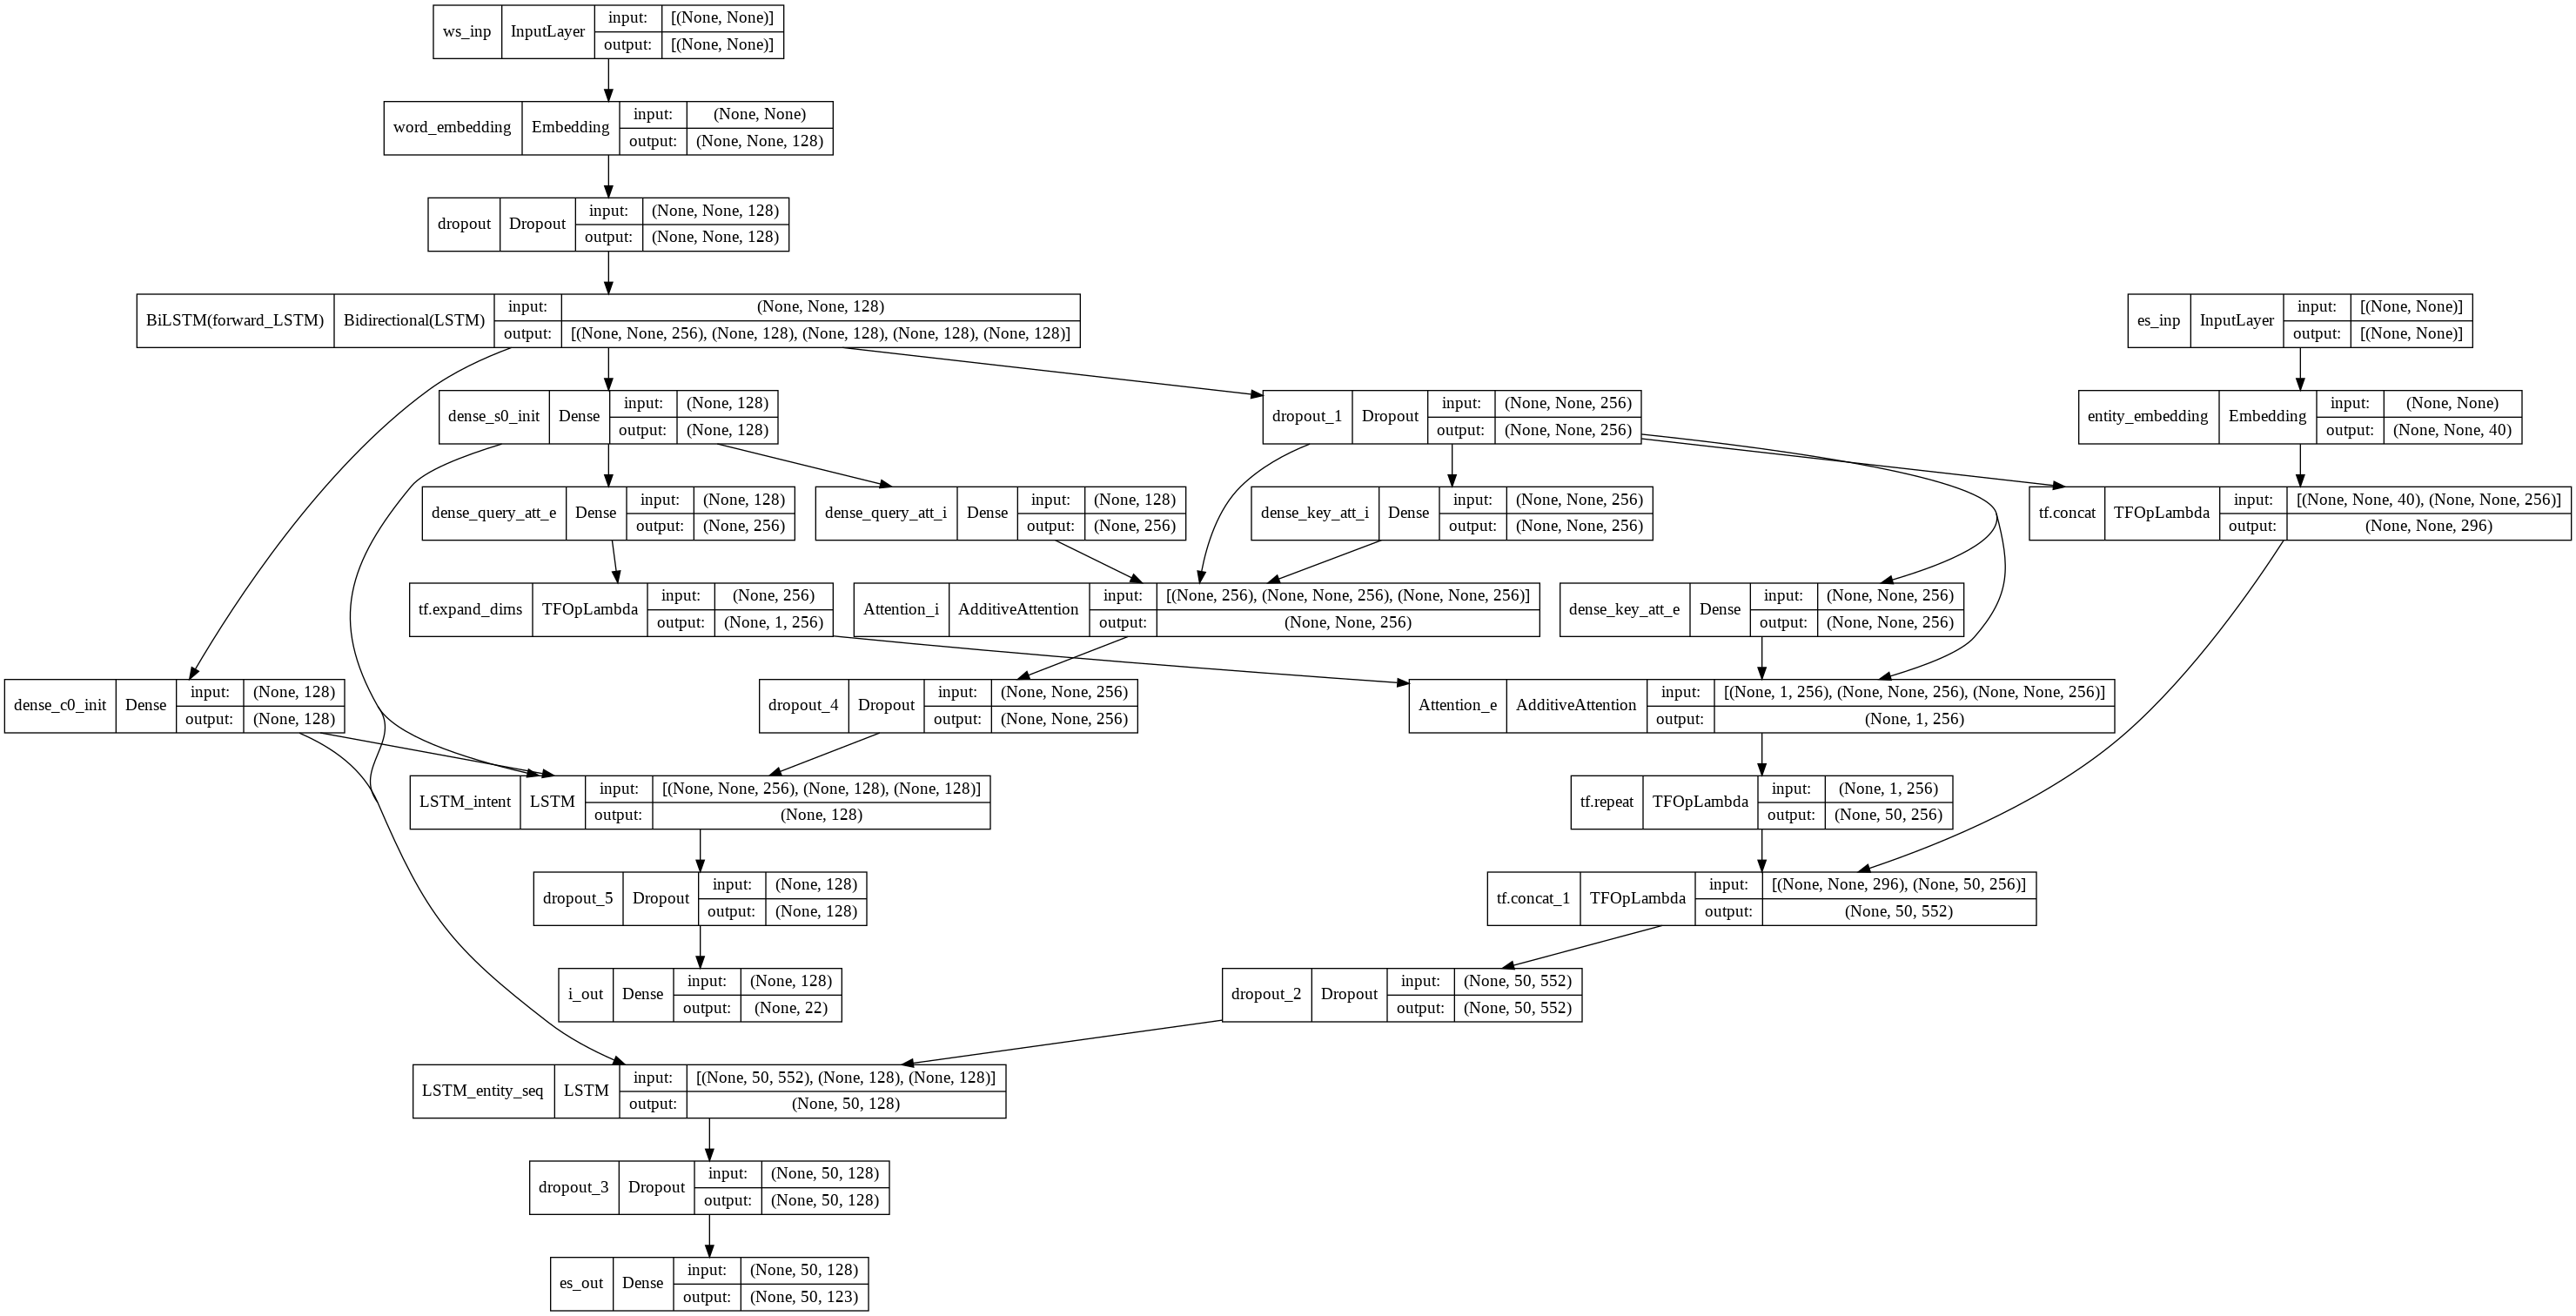

In [9]:
plot_model(model, to_file="model_seq2seq.png", show_shapes=True)

## 5. Entrenamiento

In [10]:
class F1Metrics(Callback):
  def __init__(self, id2label, val_data, pad_value=0):
    super(F1Metrics, self).__init__()
    self.id2label = id2label
    self.pad_value = pad_value
    self.validation_data = val_data
    self.is_fit = val_data is None

  def get_length(self, y):
    lens = [len([idx for idx in row if idx != self.pad_value]) for row in y]
    return lens

  def convert_idx_to_name(self, y, lens, padding):
    y_temp = []
    for row, l in zip(y, lens):
      row_temp = []
      if padding == 'pre':
        for idx in np.array(row[-l:-1]).tolist():
          if idx == self.pad_value:
            row_temp.append('O')
          elif idx == 1:
            row_temp.append('O')
          else:
            row_temp.append(self.id2label[idx])
        y_temp.append(row_temp)
      else:
        for idx in np.array(row[:(l-1)]).tolist():
          if idx == self.pad_value:
            row_temp.append('O')
          elif idx == 1:
            row_temp.append('O')
          else:
            row_temp.append(self.id2label[idx])
        y_temp.append(row_temp)
    return y_temp

  def predict(self, X, y):
    y_pred_slots, y_pred_intents = self.model.predict_on_batch(X)
    y_true_slots = y['es_out']
    y_true_intents = y['i_out']
    y_pred_slots = np.argmax(y_pred_slots, -1)
    y_pred_intents = np.argmax(y_pred_intents, -1)
    lens = self.get_length(y_true_slots)
    if np.array(y_true_slots[0]).tolist()[0] == 0:
      padding = 'pre'
    else:
      padding = 'post'
    y_true_slots = self.convert_idx_to_name(y_true_slots, lens, padding)
    y_pred_slots = self.convert_idx_to_name(y_pred_slots, lens, padding)
    return y_true_slots, y_true_intents, y_pred_slots, y_pred_intents

  def score(self, y_true, y_pred):
    score = f1_score(y_true, y_pred, mode='strict', scheme=IOB2)
    print(' - f1: {:04.2f}'.format(score * 100))
    print(classification_report(y_true, y_pred, digits=4, mode='strict', scheme=IOB2))
    return score

  def on_epoch_end(self, epoch, logs={}):
    if self.is_fit:
      self.on_epoch_end_fit(epoch, logs)
    else:
      self.on_epoch_end_fit_generator(epoch, logs)

  def on_epoch_end_fit(self, epoch, logs={}):
    X = self.validation_data[0]
    y = self.validation_data[1]
    y_true, y_pred = self.predict(X, y)
    score = self.score(y_true, y_pred)
    logs['f1'] = score

  def on_epoch_end_fit_generator(self, epoch, logs={}):
    y_true_slots = []
    y_pred_slots = []
    for X, y in self.validation_data:
      y_true_slots_batch, y_true_intents_batch, y_pred_slots_batch, y_pred_intents_batch = self.predict(X, y)
      y_true_slots.extend(y_true_slots_batch)
      y_pred_slots.extend(y_pred_slots_batch)
    slots_score = self.score(y_true_slots, y_pred_slots)
    intents_score = sklearn.metrics.f1_score(y_true_intents_batch, y_pred_intents_batch, average='micro')
    logs['slots_f1'] = slots_score
    logs['intent_f1'] = intents_score

f1score = F1Metrics(entity_tokenizer.index_word, val_dataset)

In [11]:
# Se entrena el modelo
epochs = 250

initial_learning_rate = 0.001
lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps=len(train_dataset)*5, decay_rate=0.95, staircase=True)

model.compile(optimizer=Adam(learning_rate=lr_schedule, clipnorm=5), loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

checkpoint = ModelCheckpoint('model-epoch:{epoch:02d}-loss:{loss:.3f}-val_loss:{val_loss:.3f}-slots_f1:{slots_f1:.3f}weights', monitor='slots_f1', mode='max')
early_stopping = EarlyStopping(monitor='slots_f1', patience=15, mode='max')
callbacks = [f1score, checkpoint, early_stopping]

history = model.fit(train_dataset, epochs=epochs, verbose=1, validation_data=val_dataset, callbacks=callbacks)

Epoch 1/250
139/139 [==============================] - ETA: 0s - loss: 1.5616 - es_out_loss: 0.6360 - i_out_loss: 0.9257 - es_out_sparse_categorical_accuracy: 0.8837 - i_out_sparse_categorical_accuracy: 0.7911 - f1: 32.84
                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.0000    0.0000    0.0000         9
              airline_name     0.0000    0.0000    0.0000        52
              airport_code     0.0000    0.0000    0.0000         3
              airport_name     0.0000    0.0000    0.0000         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.0000    0.0000    0.0000        10
    arrive_date.day_number     0.0000    0.0000    0.0000         4
    arrive_date.month_name     0.0000    0.0000    0.0000         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time   

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Assets written to: model-epoch:01-loss:1.562-val_loss:1.108-slots_f1:0.328weights/assets


INFO:tensorflow:Assets written to: model-epoch:01-loss:1.562-val_loss:1.108-slots_f1:0.328weights/assets


139/139 [==============================] - 86s 518ms/step - loss: 1.5616 - es_out_loss: 0.6360 - i_out_loss: 0.9257 - es_out_sparse_categorical_accuracy: 0.8837 - i_out_sparse_categorical_accuracy: 0.7911 - val_loss: 1.1077 - val_es_out_loss: 0.3757 - val_i_out_loss: 0.7320 - val_es_out_sparse_categorical_accuracy: 0.9236 - val_i_out_sparse_categorical_accuracy: 0.8326 - slots_f1: 0.3284 - intent_f1: 0.7812
Epoch 2/250
139/139 [==============================] - ETA: 0s - loss: 0.7994 - es_out_loss: 0.3126 - i_out_loss: 0.4868 - es_out_sparse_categorical_accuracy: 0.9357 - i_out_sparse_categorical_accuracy: 0.8788 - f1: 46.53
                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.0000    0.0000    0.0000         9
              airline_name     0.0000    0.0000    0.0000        55
              airport_code     0.0000    0.0000    0.0000         3
              airport_name

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Assets written to: model-epoch:02-loss:0.799-val_loss:0.884-slots_f1:0.465weights/assets


INFO:tensorflow:Assets written to: model-epoch:02-loss:0.799-val_loss:0.884-slots_f1:0.465weights/assets


139/139 [==============================] - 67s 484ms/step - loss: 0.7994 - es_out_loss: 0.3126 - i_out_loss: 0.4868 - es_out_sparse_categorical_accuracy: 0.9357 - i_out_sparse_categorical_accuracy: 0.8788 - val_loss: 0.8842 - val_es_out_loss: 0.2952 - val_i_out_loss: 0.5891 - val_es_out_sparse_categorical_accuracy: 0.9392 - val_i_out_sparse_categorical_accuracy: 0.8594 - slots_f1: 0.4653 - intent_f1: 0.9375
Epoch 3/250
139/139 [==============================] - ETA: 0s - loss: 0.6259 - es_out_loss: 0.2551 - i_out_loss: 0.3708 - es_out_sparse_categorical_accuracy: 0.9452 - i_out_sparse_categorical_accuracy: 0.9024 - f1: 53.10
                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.0000    0.0000    0.0000         8
              airline_name     0.0000    0.0000    0.0000        53
              airport_code     0.0000    0.0000    0.0000         3
              airport_name

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Assets written to: model-epoch:03-loss:0.626-val_loss:0.708-slots_f1:0.531weights/assets


INFO:tensorflow:Assets written to: model-epoch:03-loss:0.626-val_loss:0.708-slots_f1:0.531weights/assets


139/139 [==============================] - 77s 554ms/step - loss: 0.6259 - es_out_loss: 0.2551 - i_out_loss: 0.3708 - es_out_sparse_categorical_accuracy: 0.9452 - i_out_sparse_categorical_accuracy: 0.9024 - val_loss: 0.7082 - val_es_out_loss: 0.2510 - val_i_out_loss: 0.4573 - val_es_out_sparse_categorical_accuracy: 0.9465 - val_i_out_sparse_categorical_accuracy: 0.8884 - slots_f1: 0.5310 - intent_f1: 0.9062
Epoch 4/250
139/139 [==============================] - ETA: 0s - loss: 0.5268 - es_out_loss: 0.2235 - i_out_loss: 0.3033 - es_out_sparse_categorical_accuracy: 0.9511 - i_out_sparse_categorical_accuracy: 0.9186 - f1: 57.20
                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.0000    0.0000    0.0000         7
              airline_name     0.0000    0.0000    0.0000        53
              airport_code     0.0000    0.0000    0.0000         4
              airport_name

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Assets written to: model-epoch:04-loss:0.527-val_loss:0.567-slots_f1:0.572weights/assets


INFO:tensorflow:Assets written to: model-epoch:04-loss:0.527-val_loss:0.567-slots_f1:0.572weights/assets


139/139 [==============================] - 69s 497ms/step - loss: 0.5268 - es_out_loss: 0.2235 - i_out_loss: 0.3033 - es_out_sparse_categorical_accuracy: 0.9511 - i_out_sparse_categorical_accuracy: 0.9186 - val_loss: 0.5674 - val_es_out_loss: 0.2253 - val_i_out_loss: 0.3420 - val_es_out_sparse_categorical_accuracy: 0.9517 - val_i_out_sparse_categorical_accuracy: 0.9040 - slots_f1: 0.5720 - intent_f1: 0.9219
Epoch 5/250
139/139 [==============================] - ETA: 0s - loss: 0.4594 - es_out_loss: 0.2043 - i_out_loss: 0.2551 - es_out_sparse_categorical_accuracy: 0.9540 - i_out_sparse_categorical_accuracy: 0.9359 - f1: 56.26
                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.0000    0.0000    0.0000         8
              airline_name     0.0000    0.0000    0.0000        58
              airport_code     0.0000    0.0000    0.0000         4
              airport_name

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Assets written to: model-epoch:05-loss:0.459-val_loss:0.602-slots_f1:0.563weights/assets


INFO:tensorflow:Assets written to: model-epoch:05-loss:0.459-val_loss:0.602-slots_f1:0.563weights/assets


139/139 [==============================] - 68s 493ms/step - loss: 0.4594 - es_out_loss: 0.2043 - i_out_loss: 0.2551 - es_out_sparse_categorical_accuracy: 0.9540 - i_out_sparse_categorical_accuracy: 0.9359 - val_loss: 0.6022 - val_es_out_loss: 0.2092 - val_i_out_loss: 0.3930 - val_es_out_sparse_categorical_accuracy: 0.9542 - val_i_out_sparse_categorical_accuracy: 0.8973 - slots_f1: 0.5626 - intent_f1: 0.9688
Epoch 6/250
139/139 [==============================] - ETA: 0s - loss: 0.4054 - es_out_loss: 0.1888 - i_out_loss: 0.2166 - es_out_sparse_categorical_accuracy: 0.9568 - i_out_sparse_categorical_accuracy: 0.9397 - f1: 59.39
                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.0000    0.0000    0.0000         9
              airline_name     0.3750    0.0545    0.0952        55
              airport_code     0.0000    0.0000    0.0000         4
              airport_name

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Assets written to: model-epoch:06-loss:0.405-val_loss:0.553-slots_f1:0.594weights/assets


INFO:tensorflow:Assets written to: model-epoch:06-loss:0.405-val_loss:0.553-slots_f1:0.594weights/assets


139/139 [==============================] - 68s 491ms/step - loss: 0.4054 - es_out_loss: 0.1888 - i_out_loss: 0.2166 - es_out_sparse_categorical_accuracy: 0.9568 - i_out_sparse_categorical_accuracy: 0.9397 - val_loss: 0.5530 - val_es_out_loss: 0.2010 - val_i_out_loss: 0.3520 - val_es_out_sparse_categorical_accuracy: 0.9544 - val_i_out_sparse_categorical_accuracy: 0.9174 - slots_f1: 0.5939 - intent_f1: 0.9531
Epoch 7/250
139/139 [==============================] - ETA: 0s - loss: 0.3697 - es_out_loss: 0.1767 - i_out_loss: 0.1929 - es_out_sparse_categorical_accuracy: 0.9589 - i_out_sparse_categorical_accuracy: 0.9512 - f1: 60.02
                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.0000    0.0000    0.0000         9
              airline_name     0.2222    0.0784    0.1159        51
              airport_code     0.0000    0.0000    0.0000         4
              airport_name

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Assets written to: model-epoch:07-loss:0.370-val_loss:0.501-slots_f1:0.600weights/assets


INFO:tensorflow:Assets written to: model-epoch:07-loss:0.370-val_loss:0.501-slots_f1:0.600weights/assets


139/139 [==============================] - 66s 477ms/step - loss: 0.3697 - es_out_loss: 0.1767 - i_out_loss: 0.1929 - es_out_sparse_categorical_accuracy: 0.9589 - i_out_sparse_categorical_accuracy: 0.9512 - val_loss: 0.5014 - val_es_out_loss: 0.1851 - val_i_out_loss: 0.3163 - val_es_out_sparse_categorical_accuracy: 0.9588 - val_i_out_sparse_categorical_accuracy: 0.9308 - slots_f1: 0.6002 - intent_f1: 0.9219
Epoch 8/250
139/139 [==============================] - ETA: 0s - loss: 0.3237 - es_out_loss: 0.1683 - i_out_loss: 0.1554 - es_out_sparse_categorical_accuracy: 0.9608 - i_out_sparse_categorical_accuracy: 0.9589 - f1: 62.50
                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.0000    0.0000    0.0000         8
              airline_name     0.2308    0.0556    0.0896        54
              airport_code     0.0000    0.0000    0.0000         2
              airport_name

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Assets written to: model-epoch:08-loss:0.324-val_loss:0.484-slots_f1:0.625weights/assets


INFO:tensorflow:Assets written to: model-epoch:08-loss:0.324-val_loss:0.484-slots_f1:0.625weights/assets


139/139 [==============================] - 66s 481ms/step - loss: 0.3237 - es_out_loss: 0.1683 - i_out_loss: 0.1554 - es_out_sparse_categorical_accuracy: 0.9608 - i_out_sparse_categorical_accuracy: 0.9589 - val_loss: 0.4845 - val_es_out_loss: 0.1800 - val_i_out_loss: 0.3045 - val_es_out_sparse_categorical_accuracy: 0.9596 - val_i_out_sparse_categorical_accuracy: 0.9308 - slots_f1: 0.6250 - intent_f1: 0.9375
Epoch 9/250
139/139 [==============================] - ETA: 0s - loss: 0.3187 - es_out_loss: 0.1623 - i_out_loss: 0.1564 - es_out_sparse_categorical_accuracy: 0.9616 - i_out_sparse_categorical_accuracy: 0.9604 - f1: 63.69
                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.0000    0.0000    0.0000         8
              airline_name     0.4483    0.2407    0.3133        54
              airport_code     0.0000    0.0000    0.0000         4
              airport_name

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Assets written to: model-epoch:09-loss:0.319-val_loss:0.418-slots_f1:0.637weights/assets


INFO:tensorflow:Assets written to: model-epoch:09-loss:0.319-val_loss:0.418-slots_f1:0.637weights/assets


139/139 [==============================] - 68s 491ms/step - loss: 0.3187 - es_out_loss: 0.1623 - i_out_loss: 0.1564 - es_out_sparse_categorical_accuracy: 0.9616 - i_out_sparse_categorical_accuracy: 0.9604 - val_loss: 0.4176 - val_es_out_loss: 0.1683 - val_i_out_loss: 0.2493 - val_es_out_sparse_categorical_accuracy: 0.9616 - val_i_out_sparse_categorical_accuracy: 0.9531 - slots_f1: 0.6369 - intent_f1: 0.9688
Epoch 10/250
139/139 [==============================] - ETA: 0s - loss: 0.2916 - es_out_loss: 0.1553 - i_out_loss: 0.1363 - es_out_sparse_categorical_accuracy: 0.9630 - i_out_sparse_categorical_accuracy: 0.9667 - f1: 63.22
                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     1.0000    0.1429    0.2500         7
              airline_name     0.3333    0.0667    0.1111        60
              airport_code     0.0000    0.0000    0.0000         4
              airport_nam

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Assets written to: model-epoch:10-loss:0.292-val_loss:0.395-slots_f1:0.632weights/assets


INFO:tensorflow:Assets written to: model-epoch:10-loss:0.292-val_loss:0.395-slots_f1:0.632weights/assets


139/139 [==============================] - 66s 480ms/step - loss: 0.2916 - es_out_loss: 0.1553 - i_out_loss: 0.1363 - es_out_sparse_categorical_accuracy: 0.9630 - i_out_sparse_categorical_accuracy: 0.9667 - val_loss: 0.3955 - val_es_out_loss: 0.1666 - val_i_out_loss: 0.2289 - val_es_out_sparse_categorical_accuracy: 0.9617 - val_i_out_sparse_categorical_accuracy: 0.9442 - slots_f1: 0.6322 - intent_f1: 0.9531
Epoch 11/250
139/139 [==============================] - ETA: 0s - loss: 0.2648 - es_out_loss: 0.1497 - i_out_loss: 0.1152 - es_out_sparse_categorical_accuracy: 0.9641 - i_out_sparse_categorical_accuracy: 0.9696 - f1: 65.86
                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.0000    0.0000    0.0000         7
              airline_name     0.4091    0.1667    0.2368        54
              airport_code     0.0000    0.0000    0.0000         4
              airport_nam

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Assets written to: model-epoch:11-loss:0.265-val_loss:0.437-slots_f1:0.659weights/assets


INFO:tensorflow:Assets written to: model-epoch:11-loss:0.265-val_loss:0.437-slots_f1:0.659weights/assets


139/139 [==============================] - 76s 550ms/step - loss: 0.2648 - es_out_loss: 0.1497 - i_out_loss: 0.1152 - es_out_sparse_categorical_accuracy: 0.9641 - i_out_sparse_categorical_accuracy: 0.9696 - val_loss: 0.4375 - val_es_out_loss: 0.1565 - val_i_out_loss: 0.2810 - val_es_out_sparse_categorical_accuracy: 0.9636 - val_i_out_sparse_categorical_accuracy: 0.9464 - slots_f1: 0.6586 - intent_f1: 0.9844
Epoch 12/250
139/139 [==============================] - ETA: 0s - loss: 0.2527 - es_out_loss: 0.1442 - i_out_loss: 0.1084 - es_out_sparse_categorical_accuracy: 0.9651 - i_out_sparse_categorical_accuracy: 0.9699 - f1: 66.90


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.0000    0.0000    0.0000         8
              airline_name     0.5000    0.1724    0.2564        58
              airport_code     0.0000    0.0000    0.0000         4
              airport_name     0.0000    0.0000    0.0000         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.0000    0.0000    0.0000         9
    arrive_date.day_number     1.0000    0.7500    0.8571         4
    arrive_date.month_name     0.0000    0.0000    0.0000         4
      arrive_time.end_time     0.0000    0.0000    0.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     1.0000    0.1818    0.3077        11
    arrive_time.start_time     0.0000    0.0000    0.0000         3
          arrive_time.time     0.7500    0.6000

INFO:tensorflow:Assets written to: model-epoch:12-loss:0.253-val_loss:0.404-slots_f1:0.669weights/assets


INFO:tensorflow:Assets written to: model-epoch:12-loss:0.253-val_loss:0.404-slots_f1:0.669weights/assets


139/139 [==============================] - 67s 486ms/step - loss: 0.2527 - es_out_loss: 0.1442 - i_out_loss: 0.1084 - es_out_sparse_categorical_accuracy: 0.9651 - i_out_sparse_categorical_accuracy: 0.9699 - val_loss: 0.4040 - val_es_out_loss: 0.1575 - val_i_out_loss: 0.2465 - val_es_out_sparse_categorical_accuracy: 0.9633 - val_i_out_sparse_categorical_accuracy: 0.9442 - slots_f1: 0.6690 - intent_f1: 0.9531
Epoch 13/250
139/139 [==============================] - ETA: 0s - loss: 0.2572 - es_out_loss: 0.1410 - i_out_loss: 0.1163 - es_out_sparse_categorical_accuracy: 0.9657 - i_out_sparse_categorical_accuracy: 0.9685 - f1: 65.88


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.0000    0.0000    0.0000         5
              airline_name     0.3556    0.3019    0.3265        53
              airport_code     0.0000    0.0000    0.0000         4
              airport_name     1.0000    0.3333    0.5000         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.0000    0.0000    0.0000        10
    arrive_date.day_number     0.6000    0.7500    0.6667         4
    arrive_date.month_name     0.0000    0.0000    0.0000         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     0.0000    0.0000    0.0000         2
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.0000    0.0000    0.0000        12
    arrive_time.start_time     0.0000    0.0000

INFO:tensorflow:Assets written to: model-epoch:13-loss:0.257-val_loss:0.356-slots_f1:0.659weights/assets


INFO:tensorflow:Assets written to: model-epoch:13-loss:0.257-val_loss:0.356-slots_f1:0.659weights/assets


139/139 [==============================] - 78s 561ms/step - loss: 0.2572 - es_out_loss: 0.1410 - i_out_loss: 0.1163 - es_out_sparse_categorical_accuracy: 0.9657 - i_out_sparse_categorical_accuracy: 0.9685 - val_loss: 0.3556 - val_es_out_loss: 0.1516 - val_i_out_loss: 0.2041 - val_es_out_sparse_categorical_accuracy: 0.9641 - val_i_out_sparse_categorical_accuracy: 0.9554 - slots_f1: 0.6588 - intent_f1: 0.9062
Epoch 14/250
139/139 [==============================] - ETA: 0s - loss: 0.2378 - es_out_loss: 0.1366 - i_out_loss: 0.1011 - es_out_sparse_categorical_accuracy: 0.9667 - i_out_sparse_categorical_accuracy: 0.9696 - f1: 66.67
                            precision    recall  f1-score   support

              airline_code     0.5000    0.1250    0.2000         8
              airline_name     0.4865    0.3103    0.3789        58
              airport_code     0.0000    0.0000    0.0000         3
              airport_name     0.0000    0.0000    0.0000         3
 arrive_date.date_relativ

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Assets written to: model-epoch:14-loss:0.238-val_loss:0.369-slots_f1:0.667weights/assets


INFO:tensorflow:Assets written to: model-epoch:14-loss:0.238-val_loss:0.369-slots_f1:0.667weights/assets


139/139 [==============================] - 66s 481ms/step - loss: 0.2378 - es_out_loss: 0.1366 - i_out_loss: 0.1011 - es_out_sparse_categorical_accuracy: 0.9667 - i_out_sparse_categorical_accuracy: 0.9696 - val_loss: 0.3691 - val_es_out_loss: 0.1516 - val_i_out_loss: 0.2174 - val_es_out_sparse_categorical_accuracy: 0.9650 - val_i_out_sparse_categorical_accuracy: 0.9420 - slots_f1: 0.6667 - intent_f1: 1.0000
Epoch 15/250
139/139 [==============================] - ETA: 0s - loss: 0.2252 - es_out_loss: 0.1320 - i_out_loss: 0.0931 - es_out_sparse_categorical_accuracy: 0.9673 - i_out_sparse_categorical_accuracy: 0.9759 - f1: 67.92
                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.0000    0.0000    0.0000         9
              airline_name     0.3333    0.1273    0.1842        55
              airport_code     0.0000    0.0000    0.0000         4
              airport_nam

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Assets written to: model-epoch:15-loss:0.225-val_loss:0.439-slots_f1:0.679weights/assets


INFO:tensorflow:Assets written to: model-epoch:15-loss:0.225-val_loss:0.439-slots_f1:0.679weights/assets


139/139 [==============================] - 68s 489ms/step - loss: 0.2252 - es_out_loss: 0.1320 - i_out_loss: 0.0931 - es_out_sparse_categorical_accuracy: 0.9673 - i_out_sparse_categorical_accuracy: 0.9759 - val_loss: 0.4392 - val_es_out_loss: 0.1496 - val_i_out_loss: 0.2896 - val_es_out_sparse_categorical_accuracy: 0.9650 - val_i_out_sparse_categorical_accuracy: 0.9420 - slots_f1: 0.6792 - intent_f1: 0.9062
Epoch 16/250
139/139 [==============================] - ETA: 0s - loss: 0.2198 - es_out_loss: 0.1295 - i_out_loss: 0.0903 - es_out_sparse_categorical_accuracy: 0.9677 - i_out_sparse_categorical_accuracy: 0.9744 - f1: 69.63
                            precision    recall  f1-score   support

              airline_code     0.0000    0.0000    0.0000         9
              airline_name     0.5625    0.3214    0.4091        56
              airport_code     0.0000    0.0000    0.0000         4
              airport_name     0.0000    0.0000    0.0000         3
 arrive_date.date_relativ

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Assets written to: model-epoch:16-loss:0.220-val_loss:0.354-slots_f1:0.696weights/assets


INFO:tensorflow:Assets written to: model-epoch:16-loss:0.220-val_loss:0.354-slots_f1:0.696weights/assets


139/139 [==============================] - 66s 475ms/step - loss: 0.2198 - es_out_loss: 0.1295 - i_out_loss: 0.0903 - es_out_sparse_categorical_accuracy: 0.9677 - i_out_sparse_categorical_accuracy: 0.9744 - val_loss: 0.3539 - val_es_out_loss: 0.1438 - val_i_out_loss: 0.2101 - val_es_out_sparse_categorical_accuracy: 0.9667 - val_i_out_sparse_categorical_accuracy: 0.9554 - slots_f1: 0.6963 - intent_f1: 0.8906
Epoch 17/250
139/139 [==============================] - ETA: 0s - loss: 0.1972 - es_out_loss: 0.1256 - i_out_loss: 0.0716 - es_out_sparse_categorical_accuracy: 0.9687 - i_out_sparse_categorical_accuracy: 0.9807 - f1: 68.11


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.0000    0.0000    0.0000         7
              airline_name     0.3333    0.3051    0.3186        59
              airport_code     0.0000    0.0000    0.0000         3
              airport_name     0.0000    0.0000    0.0000         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.0000    0.0000    0.0000         8
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.0000    0.0000    0.0000         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     0.0000    0.0000    0.0000         2
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.0000    0.0000    0.0000        11
    arrive_time.start_time     0.0000    0.0000

INFO:tensorflow:Assets written to: model-epoch:17-loss:0.197-val_loss:0.392-slots_f1:0.681weights/assets


INFO:tensorflow:Assets written to: model-epoch:17-loss:0.197-val_loss:0.392-slots_f1:0.681weights/assets


139/139 [==============================] - 67s 486ms/step - loss: 0.1972 - es_out_loss: 0.1256 - i_out_loss: 0.0716 - es_out_sparse_categorical_accuracy: 0.9687 - i_out_sparse_categorical_accuracy: 0.9807 - val_loss: 0.3917 - val_es_out_loss: 0.1444 - val_i_out_loss: 0.2473 - val_es_out_sparse_categorical_accuracy: 0.9663 - val_i_out_sparse_categorical_accuracy: 0.9576 - slots_f1: 0.6811 - intent_f1: 0.9531
Epoch 18/250
139/139 [==============================] - ETA: 0s - loss: 0.1964 - es_out_loss: 0.1234 - i_out_loss: 0.0730 - es_out_sparse_categorical_accuracy: 0.9692 - i_out_sparse_categorical_accuracy: 0.9798 - f1: 69.22


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     1.0000    0.2222    0.3636         9
              airline_name     0.6552    0.3519    0.4578        54
              airport_code     0.0000    0.0000    0.0000         4
              airport_name     0.0000    0.0000    0.0000         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.0000    0.0000    0.0000         7
    arrive_date.day_number     1.0000    0.7500    0.8571         4
    arrive_date.month_name     0.0000    0.0000    0.0000         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     0.0000    0.0000    0.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     1.0000    0.1000    0.1818        10
    arrive_time.start_time     1.0000    0.3333

INFO:tensorflow:Assets written to: model-epoch:18-loss:0.196-val_loss:0.398-slots_f1:0.692weights/assets


INFO:tensorflow:Assets written to: model-epoch:18-loss:0.196-val_loss:0.398-slots_f1:0.692weights/assets


139/139 [==============================] - 66s 480ms/step - loss: 0.1964 - es_out_loss: 0.1234 - i_out_loss: 0.0730 - es_out_sparse_categorical_accuracy: 0.9692 - i_out_sparse_categorical_accuracy: 0.9798 - val_loss: 0.3979 - val_es_out_loss: 0.1388 - val_i_out_loss: 0.2592 - val_es_out_sparse_categorical_accuracy: 0.9688 - val_i_out_sparse_categorical_accuracy: 0.9598 - slots_f1: 0.6922 - intent_f1: 1.0000
Epoch 19/250
139/139 [==============================] - ETA: 0s - loss: 0.1826 - es_out_loss: 0.1197 - i_out_loss: 0.0629 - es_out_sparse_categorical_accuracy: 0.9699 - i_out_sparse_categorical_accuracy: 0.9840 - f1: 70.46
                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     1.0000    0.1429    0.2500         7
              airline_name     0.4634    0.3276    0.3838        58
              airport_code     0.0000    0.0000    0.0000         4
              airport_nam

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Assets written to: model-epoch:19-loss:0.183-val_loss:0.361-slots_f1:0.705weights/assets


INFO:tensorflow:Assets written to: model-epoch:19-loss:0.183-val_loss:0.361-slots_f1:0.705weights/assets


139/139 [==============================] - 76s 552ms/step - loss: 0.1826 - es_out_loss: 0.1197 - i_out_loss: 0.0629 - es_out_sparse_categorical_accuracy: 0.9699 - i_out_sparse_categorical_accuracy: 0.9840 - val_loss: 0.3611 - val_es_out_loss: 0.1312 - val_i_out_loss: 0.2298 - val_es_out_sparse_categorical_accuracy: 0.9691 - val_i_out_sparse_categorical_accuracy: 0.9531 - slots_f1: 0.7046 - intent_f1: 0.9531
Epoch 20/250
139/139 [==============================] - ETA: 0s - loss: 0.1748 - es_out_loss: 0.1167 - i_out_loss: 0.0581 - es_out_sparse_categorical_accuracy: 0.9707 - i_out_sparse_categorical_accuracy: 0.9840 - f1: 71.04


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

              airline_code     1.0000    0.1111    0.2000         9
              airline_name     0.5122    0.3818    0.4375        55
              airport_code     0.0000    0.0000    0.0000         4
              airport_name     0.5000    0.3333    0.4000         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         1
      arrive_date.day_name     0.0000    0.0000    0.0000         5
    arrive_date.day_number     0.7500    1.0000    0.8571         3
    arrive_date.month_name     0.0000    0.0000    0.0000         3
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     0.0000    0.0000    0.0000         3
 arrive_time.period_of_day     0.0000    0.0000    0.0000         8
    arrive_time.start_time     0.0000    0.0000    0.0000         3
          arrive_time.time     0.8333    0.8333    0.8333        12
 arrive_time.time_relative     0.3333    0.2500

INFO:tensorflow:Assets written to: model-epoch:20-loss:0.175-val_loss:0.390-slots_f1:0.710weights/assets


INFO:tensorflow:Assets written to: model-epoch:20-loss:0.175-val_loss:0.390-slots_f1:0.710weights/assets


139/139 [==============================] - 66s 480ms/step - loss: 0.1748 - es_out_loss: 0.1167 - i_out_loss: 0.0581 - es_out_sparse_categorical_accuracy: 0.9707 - i_out_sparse_categorical_accuracy: 0.9840 - val_loss: 0.3898 - val_es_out_loss: 0.1377 - val_i_out_loss: 0.2520 - val_es_out_sparse_categorical_accuracy: 0.9672 - val_i_out_sparse_categorical_accuracy: 0.9487 - slots_f1: 0.7104 - intent_f1: 0.9062
Epoch 21/250
139/139 [==============================] - ETA: 0s - loss: 0.1669 - es_out_loss: 0.1136 - i_out_loss: 0.0533 - es_out_sparse_categorical_accuracy: 0.9713 - i_out_sparse_categorical_accuracy: 0.9867 - f1: 71.27


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.2500    0.1429    0.1818         7
              airline_name     0.6739    0.5439    0.6019        57
              airport_code     0.0000    0.0000    0.0000         4
              airport_name     0.3333    0.2500    0.2857         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         1
      arrive_date.day_name     0.0000    0.0000    0.0000         8
    arrive_date.day_number     0.8000    1.0000    0.8889         4
    arrive_date.month_name     0.0000    0.0000    0.0000         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     0.0000    0.0000    0.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     1.0000    0.2000    0.3333        10
    arrive_time.start_time     0.0000    0.0000

INFO:tensorflow:Assets written to: model-epoch:21-loss:0.167-val_loss:0.366-slots_f1:0.713weights/assets


139/139 [==============================] - 67s 483ms/step - loss: 0.1669 - es_out_loss: 0.1136 - i_out_loss: 0.0533 - es_out_sparse_categorical_accuracy: 0.9713 - i_out_sparse_categorical_accuracy: 0.9867 - val_loss: 0.3659 - val_es_out_loss: 0.1297 - val_i_out_loss: 0.2362 - val_es_out_sparse_categorical_accuracy: 0.9697 - val_i_out_sparse_categorical_accuracy: 0.9531 - slots_f1: 0.7127 - intent_f1: 0.9375
Epoch 22/250
139/139 [==============================] - ETA: 0s - loss: 0.1642 - es_out_loss: 0.1124 - i_out_loss: 0.0519 - es_out_sparse_categorical_accuracy: 0.9714 - i_out_sparse_categorical_accuracy: 0.9861 - f1: 71.58
                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.3333    0.1250    0.1818         8
              airline_name     0.5217    0.4138    0.4615        58
              airport_code     0.0000    0.0000    0.0000         4
              airport_nam

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Assets written to: model-epoch:22-loss:0.164-val_loss:0.349-slots_f1:0.716weights/assets


INFO:tensorflow:Assets written to: model-epoch:22-loss:0.164-val_loss:0.349-slots_f1:0.716weights/assets


139/139 [==============================] - 68s 490ms/step - loss: 0.1642 - es_out_loss: 0.1124 - i_out_loss: 0.0519 - es_out_sparse_categorical_accuracy: 0.9714 - i_out_sparse_categorical_accuracy: 0.9861 - val_loss: 0.3492 - val_es_out_loss: 0.1266 - val_i_out_loss: 0.2226 - val_es_out_sparse_categorical_accuracy: 0.9700 - val_i_out_sparse_categorical_accuracy: 0.9598 - slots_f1: 0.7158 - intent_f1: 0.9531
Epoch 23/250
139/139 [==============================] - ETA: 0s - loss: 0.1602 - es_out_loss: 0.1100 - i_out_loss: 0.0502 - es_out_sparse_categorical_accuracy: 0.9718 - i_out_sparse_categorical_accuracy: 0.9852 - f1: 71.10


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.0000    0.0000    0.0000         9
              airline_name     0.6222    0.5000    0.5545        56
              airport_code     1.0000    0.2500    0.4000         4
              airport_name     0.5000    0.2500    0.3333         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.0000    0.0000    0.0000         8
    arrive_date.day_number     0.8000    1.0000    0.8889         4
    arrive_date.month_name     0.0000    0.0000    0.0000         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    0.3333    0.5000         3
 arrive_time.period_of_day     1.0000    0.2000    0.3333        10
    arrive_time.start_time     0.0000    0.0000    0.0000         3
          arrive_time.time     0.6364    0.4667

INFO:tensorflow:Assets written to: model-epoch:23-loss:0.160-val_loss:0.370-slots_f1:0.711weights/assets


INFO:tensorflow:Assets written to: model-epoch:23-loss:0.160-val_loss:0.370-slots_f1:0.711weights/assets


139/139 [==============================] - 68s 489ms/step - loss: 0.1602 - es_out_loss: 0.1100 - i_out_loss: 0.0502 - es_out_sparse_categorical_accuracy: 0.9718 - i_out_sparse_categorical_accuracy: 0.9852 - val_loss: 0.3696 - val_es_out_loss: 0.1238 - val_i_out_loss: 0.2458 - val_es_out_sparse_categorical_accuracy: 0.9700 - val_i_out_sparse_categorical_accuracy: 0.9554 - slots_f1: 0.7110 - intent_f1: 0.9375
Epoch 24/250
139/139 [==============================] - ETA: 0s - loss: 0.1649 - es_out_loss: 0.1092 - i_out_loss: 0.0558 - es_out_sparse_categorical_accuracy: 0.9722 - i_out_sparse_categorical_accuracy: 0.9831 - f1: 71.66


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.0000    0.0000    0.0000         8
              airline_name     0.7297    0.4821    0.5806        56
              airport_code     0.0000    0.0000    0.0000         4
              airport_name     0.5000    0.2500    0.3333         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         1
      arrive_date.day_name     0.0000    0.0000    0.0000         8
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.0000    0.0000    0.0000         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     0.4000    0.6667    0.5000         3
 arrive_time.period_of_day     0.7500    0.2500    0.3750        12
    arrive_time.start_time     0.0000    0.0000    0.0000         3
          arrive_time.time     0.7143    0.5882

INFO:tensorflow:Assets written to: model-epoch:24-loss:0.165-val_loss:0.395-slots_f1:0.717weights/assets


INFO:tensorflow:Assets written to: model-epoch:24-loss:0.165-val_loss:0.395-slots_f1:0.717weights/assets


139/139 [==============================] - 68s 495ms/step - loss: 0.1649 - es_out_loss: 0.1092 - i_out_loss: 0.0558 - es_out_sparse_categorical_accuracy: 0.9722 - i_out_sparse_categorical_accuracy: 0.9831 - val_loss: 0.3950 - val_es_out_loss: 0.1244 - val_i_out_loss: 0.2705 - val_es_out_sparse_categorical_accuracy: 0.9703 - val_i_out_sparse_categorical_accuracy: 0.9554 - slots_f1: 0.7166 - intent_f1: 0.9688
Epoch 25/250
139/139 [==============================] - ETA: 0s - loss: 0.1565 - es_out_loss: 0.1069 - i_out_loss: 0.0496 - es_out_sparse_categorical_accuracy: 0.9728 - i_out_sparse_categorical_accuracy: 0.9865 - f1: 71.77


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.0000    0.0000    0.0000         8
              airline_name     0.6500    0.4407    0.5253        59
              airport_code     0.0000    0.0000    0.0000         4
              airport_name     1.0000    0.2500    0.4000         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.0000    0.0000    0.0000         9
    arrive_date.day_number     1.0000    1.0000    1.0000         3
    arrive_date.month_name     1.0000    0.3333    0.5000         3
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     0.0000    0.0000    0.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     1.0000    0.2308    0.3750        13
    arrive_time.start_time     0.0000    0.0000

INFO:tensorflow:Assets written to: model-epoch:25-loss:0.156-val_loss:0.385-slots_f1:0.718weights/assets


INFO:tensorflow:Assets written to: model-epoch:25-loss:0.156-val_loss:0.385-slots_f1:0.718weights/assets


139/139 [==============================] - 67s 488ms/step - loss: 0.1565 - es_out_loss: 0.1069 - i_out_loss: 0.0496 - es_out_sparse_categorical_accuracy: 0.9728 - i_out_sparse_categorical_accuracy: 0.9865 - val_loss: 0.3845 - val_es_out_loss: 0.1236 - val_i_out_loss: 0.2609 - val_es_out_sparse_categorical_accuracy: 0.9707 - val_i_out_sparse_categorical_accuracy: 0.9531 - slots_f1: 0.7177 - intent_f1: 0.9688
Epoch 26/250
139/139 [==============================] - ETA: 0s - loss: 0.1551 - es_out_loss: 0.1051 - i_out_loss: 0.0500 - es_out_sparse_categorical_accuracy: 0.9729 - i_out_sparse_categorical_accuracy: 0.9858 - f1: 70.78


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.0000    0.0000    0.0000         8
              airline_name     0.4364    0.4528    0.4444        53
              airport_code     0.0000    0.0000    0.0000         4
              airport_name     0.0000    0.0000    0.0000         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.3333    0.1000    0.1538        10
    arrive_date.day_number     1.0000    1.0000    1.0000         3
    arrive_date.month_name     0.0000    0.0000    0.0000         3
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     0.0000    0.0000    0.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     1.0000    0.0769    0.1429        13
    arrive_time.start_time     0.0000    0.0000

INFO:tensorflow:Assets written to: model-epoch:26-loss:0.155-val_loss:0.411-slots_f1:0.708weights/assets


INFO:tensorflow:Assets written to: model-epoch:26-loss:0.155-val_loss:0.411-slots_f1:0.708weights/assets


139/139 [==============================] - 77s 557ms/step - loss: 0.1551 - es_out_loss: 0.1051 - i_out_loss: 0.0500 - es_out_sparse_categorical_accuracy: 0.9729 - i_out_sparse_categorical_accuracy: 0.9858 - val_loss: 0.4107 - val_es_out_loss: 0.1271 - val_i_out_loss: 0.2836 - val_es_out_sparse_categorical_accuracy: 0.9700 - val_i_out_sparse_categorical_accuracy: 0.9531 - slots_f1: 0.7078 - intent_f1: 0.9688
Epoch 27/250
139/139 [==============================] - ETA: 0s - loss: 0.1499 - es_out_loss: 0.1031 - i_out_loss: 0.0468 - es_out_sparse_categorical_accuracy: 0.9733 - i_out_sparse_categorical_accuracy: 0.9870 - f1: 70.36


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.0000    0.0000    0.0000         8
              airline_name     0.5625    0.4821    0.5192        56
              airport_code     0.3333    0.2500    0.2857         4
              airport_name     1.0000    0.6667    0.8000         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.0000    0.0000    0.0000         9
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.0000    0.0000    0.0000         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     0.0000    0.0000    0.0000         3
 arrive_time.period_of_day     0.0000    0.0000    0.0000        12
    arrive_time.start_time     0.0000    0.0000    0.0000         3
          arrive_time.time     0.7500    0.7500

INFO:tensorflow:Assets written to: model-epoch:27-loss:0.150-val_loss:0.389-slots_f1:0.704weights/assets


INFO:tensorflow:Assets written to: model-epoch:27-loss:0.150-val_loss:0.389-slots_f1:0.704weights/assets


139/139 [==============================] - 68s 492ms/step - loss: 0.1499 - es_out_loss: 0.1031 - i_out_loss: 0.0468 - es_out_sparse_categorical_accuracy: 0.9733 - i_out_sparse_categorical_accuracy: 0.9870 - val_loss: 0.3886 - val_es_out_loss: 0.1264 - val_i_out_loss: 0.2622 - val_es_out_sparse_categorical_accuracy: 0.9704 - val_i_out_sparse_categorical_accuracy: 0.9487 - slots_f1: 0.7036 - intent_f1: 0.9531
Epoch 28/250
139/139 [==============================] - ETA: 0s - loss: 0.1403 - es_out_loss: 0.1019 - i_out_loss: 0.0384 - es_out_sparse_categorical_accuracy: 0.9737 - i_out_sparse_categorical_accuracy: 0.9892 - f1: 71.82


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.1667    0.1429    0.1538         7
              airline_name     0.6364    0.5185    0.5714        54
              airport_code     0.6667    0.5000    0.5714         4
              airport_name     0.0000    0.0000    0.0000         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.0000    0.0000    0.0000         7
    arrive_date.day_number     0.8000    1.0000    0.8889         4
    arrive_date.month_name     0.0000    0.0000    0.0000         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     0.5000    0.3333    0.4000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.0000    0.0000    0.0000        11
    arrive_time.start_time     0.0000    0.0000

INFO:tensorflow:Assets written to: model-epoch:28-loss:0.140-val_loss:0.391-slots_f1:0.718weights/assets


139/139 [==============================] - 69s 500ms/step - loss: 0.1403 - es_out_loss: 0.1019 - i_out_loss: 0.0384 - es_out_sparse_categorical_accuracy: 0.9737 - i_out_sparse_categorical_accuracy: 0.9892 - val_loss: 0.3908 - val_es_out_loss: 0.1181 - val_i_out_loss: 0.2727 - val_es_out_sparse_categorical_accuracy: 0.9718 - val_i_out_sparse_categorical_accuracy: 0.9442 - slots_f1: 0.7182 - intent_f1: 0.9844
Epoch 29/250
139/139 [==============================] - ETA: 0s - loss: 0.1385 - es_out_loss: 0.0991 - i_out_loss: 0.0393 - es_out_sparse_categorical_accuracy: 0.9746 - i_out_sparse_categorical_accuracy: 0.9910 - f1: 72.84


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

              airline_code     0.2500    0.1250    0.1667         8
              airline_name     0.5682    0.4310    0.4902        58
              airport_code     0.0000    0.0000    0.0000         3
              airport_name     0.0000    0.0000    0.0000         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.0000    0.0000    0.0000         9
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.0000    0.0000    0.0000         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     0.0000    0.0000    0.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     1.0000    0.2000    0.3333        10
    arrive_time.start_time     0.3333    0.3333    0.3333         3
          arrive_time.time     0.6923    0.5625

INFO:tensorflow:Assets written to: model-epoch:29-loss:0.138-val_loss:0.417-slots_f1:0.728weights/assets


139/139 [==============================] - 68s 490ms/step - loss: 0.1385 - es_out_loss: 0.0991 - i_out_loss: 0.0393 - es_out_sparse_categorical_accuracy: 0.9746 - i_out_sparse_categorical_accuracy: 0.9910 - val_loss: 0.4166 - val_es_out_loss: 0.1200 - val_i_out_loss: 0.2966 - val_es_out_sparse_categorical_accuracy: 0.9719 - val_i_out_sparse_categorical_accuracy: 0.9621 - slots_f1: 0.7284 - intent_f1: 0.9531
Epoch 30/250
139/139 [==============================] - ETA: 0s - loss: 0.1299 - es_out_loss: 0.0986 - i_out_loss: 0.0313 - es_out_sparse_categorical_accuracy: 0.9742 - i_out_sparse_categorical_accuracy: 0.9919 - f1: 72.68


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

              airline_code     0.2857    0.2500    0.2667         8
              airline_name     0.5833    0.4828    0.5283        58
              airport_code     0.0000    0.0000    0.0000         4
              airport_name     0.3333    0.2500    0.2857         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         1
      arrive_date.day_name     0.0000    0.0000    0.0000         9
    arrive_date.day_number     0.6667    1.0000    0.8000         2
    arrive_date.month_name     0.0000    0.0000    0.0000         2
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     0.5000    0.3333    0.4000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     1.0000    0.3333    0.5000        12
    arrive_time.start_time     0.0000    0.0000    0.0000         3
          arrive_time.time     0.9231    0.7500

INFO:tensorflow:Assets written to: model-epoch:30-loss:0.130-val_loss:0.375-slots_f1:0.727weights/assets


INFO:tensorflow:Assets written to: model-epoch:30-loss:0.130-val_loss:0.375-slots_f1:0.727weights/assets


139/139 [==============================] - 68s 493ms/step - loss: 0.1299 - es_out_loss: 0.0986 - i_out_loss: 0.0313 - es_out_sparse_categorical_accuracy: 0.9742 - i_out_sparse_categorical_accuracy: 0.9919 - val_loss: 0.3748 - val_es_out_loss: 0.1188 - val_i_out_loss: 0.2560 - val_es_out_sparse_categorical_accuracy: 0.9718 - val_i_out_sparse_categorical_accuracy: 0.9665 - slots_f1: 0.7268 - intent_f1: 0.9844
Epoch 31/250
139/139 [==============================] - ETA: 0s - loss: 0.1274 - es_out_loss: 0.0970 - i_out_loss: 0.0304 - es_out_sparse_categorical_accuracy: 0.9746 - i_out_sparse_categorical_accuracy: 0.9908 - f1: 73.30


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.3750    0.3333    0.3529         9
              airline_name     0.5000    0.4340    0.4646        53
              airport_code     0.0000    0.0000    0.0000         3
              airport_name     0.5000    0.3333    0.4000         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         1
      arrive_date.day_name     0.0000    0.0000    0.0000         8
    arrive_date.day_number     1.0000    1.0000    1.0000         3
    arrive_date.month_name     0.0000    0.0000    0.0000         3
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     0.5000    0.5000    0.5000         2
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     1.0000    0.1538    0.2667        13
    arrive_time.start_time     0.0000    0.0000

INFO:tensorflow:Assets written to: model-epoch:31-loss:0.127-val_loss:0.356-slots_f1:0.733weights/assets


INFO:tensorflow:Assets written to: model-epoch:31-loss:0.127-val_loss:0.356-slots_f1:0.733weights/assets


139/139 [==============================] - 70s 507ms/step - loss: 0.1274 - es_out_loss: 0.0970 - i_out_loss: 0.0304 - es_out_sparse_categorical_accuracy: 0.9746 - i_out_sparse_categorical_accuracy: 0.9908 - val_loss: 0.3559 - val_es_out_loss: 0.1138 - val_i_out_loss: 0.2422 - val_es_out_sparse_categorical_accuracy: 0.9723 - val_i_out_sparse_categorical_accuracy: 0.9621 - slots_f1: 0.7330 - intent_f1: 0.9688
Epoch 32/250
139/139 [==============================] - ETA: 0s - loss: 0.1298 - es_out_loss: 0.0954 - i_out_loss: 0.0345 - es_out_sparse_categorical_accuracy: 0.9750 - i_out_sparse_categorical_accuracy: 0.9892 - f1: 74.54


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.0000    0.0000    0.0000         6
              airline_name     0.5417    0.4561    0.4952        57
              airport_code     0.0000    0.0000    0.0000         4
              airport_name     0.0000    0.0000    0.0000         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.2000    0.1000    0.1333        10
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.0000    0.0000    0.0000         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     0.0000    0.0000    0.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     1.0000    0.0833    0.1538        12
    arrive_time.start_time     0.0000    0.0000

INFO:tensorflow:Assets written to: model-epoch:32-loss:0.130-val_loss:0.381-slots_f1:0.745weights/assets


INFO:tensorflow:Assets written to: model-epoch:32-loss:0.130-val_loss:0.381-slots_f1:0.745weights/assets


139/139 [==============================] - 69s 497ms/step - loss: 0.1298 - es_out_loss: 0.0954 - i_out_loss: 0.0345 - es_out_sparse_categorical_accuracy: 0.9750 - i_out_sparse_categorical_accuracy: 0.9892 - val_loss: 0.3811 - val_es_out_loss: 0.1170 - val_i_out_loss: 0.2640 - val_es_out_sparse_categorical_accuracy: 0.9710 - val_i_out_sparse_categorical_accuracy: 0.9665 - slots_f1: 0.7454 - intent_f1: 0.9844
Epoch 33/250
139/139 [==============================] - ETA: 0s - loss: 0.1232 - es_out_loss: 0.0941 - i_out_loss: 0.0291 - es_out_sparse_categorical_accuracy: 0.9752 - i_out_sparse_categorical_accuracy: 0.9921 - f1: 72.95


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.5000    0.2857    0.3636         7
              airline_name     0.5106    0.4615    0.4848        52
              airport_code     0.0000    0.0000    0.0000         3
              airport_name     1.0000    0.3333    0.5000         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.5000    0.1111    0.1818         9
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.0000    0.0000    0.0000         4
      arrive_time.end_time     0.0000    0.0000    0.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.0000    0.0000    0.0000        12
    arrive_time.start_time     0.0000    0.0000    0.0000         3
          arrive_time.time     0.8333    0.6667

INFO:tensorflow:Assets written to: model-epoch:33-loss:0.123-val_loss:0.391-slots_f1:0.729weights/assets


INFO:tensorflow:Assets written to: model-epoch:33-loss:0.123-val_loss:0.391-slots_f1:0.729weights/assets


139/139 [==============================] - 68s 494ms/step - loss: 0.1232 - es_out_loss: 0.0941 - i_out_loss: 0.0291 - es_out_sparse_categorical_accuracy: 0.9752 - i_out_sparse_categorical_accuracy: 0.9921 - val_loss: 0.3914 - val_es_out_loss: 0.1123 - val_i_out_loss: 0.2791 - val_es_out_sparse_categorical_accuracy: 0.9721 - val_i_out_sparse_categorical_accuracy: 0.9531 - slots_f1: 0.7295 - intent_f1: 0.9375
Epoch 34/250
139/139 [==============================] - ETA: 0s - loss: 0.1164 - es_out_loss: 0.0924 - i_out_loss: 0.0240 - es_out_sparse_categorical_accuracy: 0.9756 - i_out_sparse_categorical_accuracy: 0.9926 - f1: 73.36


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.5000    0.2222    0.3077         9
              airline_name     0.6875    0.5789    0.6286        57
              airport_code     1.0000    0.3333    0.5000         3
              airport_name     1.0000    0.2500    0.4000         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.2500    0.1250    0.1667         8
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.0000    0.0000    0.0000         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     0.6000    1.0000    0.7500         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.6667    0.1667    0.2667        12
    arrive_time.start_time     0.0000    0.0000

INFO:tensorflow:Assets written to: model-epoch:34-loss:0.116-val_loss:0.299-slots_f1:0.734weights/assets


INFO:tensorflow:Assets written to: model-epoch:34-loss:0.116-val_loss:0.299-slots_f1:0.734weights/assets


139/139 [==============================] - 68s 494ms/step - loss: 0.1164 - es_out_loss: 0.0924 - i_out_loss: 0.0240 - es_out_sparse_categorical_accuracy: 0.9756 - i_out_sparse_categorical_accuracy: 0.9926 - val_loss: 0.2991 - val_es_out_loss: 0.1104 - val_i_out_loss: 0.1887 - val_es_out_sparse_categorical_accuracy: 0.9733 - val_i_out_sparse_categorical_accuracy: 0.9665 - slots_f1: 0.7336 - intent_f1: 1.0000
Epoch 35/250
139/139 [==============================] - ETA: 0s - loss: 0.1258 - es_out_loss: 0.0907 - i_out_loss: 0.0351 - es_out_sparse_categorical_accuracy: 0.9762 - i_out_sparse_categorical_accuracy: 0.9897 - f1: 73.68


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.3750    0.3750    0.3750         8
              airline_name     0.4909    0.4737    0.4821        57
              airport_code     0.0000    0.0000    0.0000         3
              airport_name     0.0000    0.0000    0.0000         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.6667    0.2500    0.3636         8
    arrive_date.day_number     0.8000    1.0000    0.8889         4
    arrive_date.month_name     0.0000    0.0000    0.0000         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     1.0000    0.2727    0.4286        11
    arrive_time.start_time     0.0000    0.0000

INFO:tensorflow:Assets written to: model-epoch:35-loss:0.126-val_loss:0.382-slots_f1:0.737weights/assets


INFO:tensorflow:Assets written to: model-epoch:35-loss:0.126-val_loss:0.382-slots_f1:0.737weights/assets


139/139 [==============================] - 69s 502ms/step - loss: 0.1258 - es_out_loss: 0.0907 - i_out_loss: 0.0351 - es_out_sparse_categorical_accuracy: 0.9762 - i_out_sparse_categorical_accuracy: 0.9897 - val_loss: 0.3820 - val_es_out_loss: 0.1110 - val_i_out_loss: 0.2710 - val_es_out_sparse_categorical_accuracy: 0.9724 - val_i_out_sparse_categorical_accuracy: 0.9509 - slots_f1: 0.7368 - intent_f1: 0.9531
Epoch 36/250
139/139 [==============================] - ETA: 0s - loss: 0.1334 - es_out_loss: 0.0907 - i_out_loss: 0.0427 - es_out_sparse_categorical_accuracy: 0.9761 - i_out_sparse_categorical_accuracy: 0.9890 - f1: 73.22


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.4000    0.2222    0.2857         9
              airline_name     0.5577    0.5179    0.5370        56
              airport_code     0.6667    0.5000    0.5714         4
              airport_name     0.3333    0.5000    0.4000         2
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.0000    0.0000    0.0000        10
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     1.0000    0.2500    0.4000         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     0.5000    0.3333    0.4000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.2500    0.0833    0.1250        12
    arrive_time.start_time     0.0000    0.0000

INFO:tensorflow:Assets written to: model-epoch:36-loss:0.133-val_loss:0.409-slots_f1:0.732weights/assets


INFO:tensorflow:Assets written to: model-epoch:36-loss:0.133-val_loss:0.409-slots_f1:0.732weights/assets


139/139 [==============================] - 69s 502ms/step - loss: 0.1334 - es_out_loss: 0.0907 - i_out_loss: 0.0427 - es_out_sparse_categorical_accuracy: 0.9761 - i_out_sparse_categorical_accuracy: 0.9890 - val_loss: 0.4093 - val_es_out_loss: 0.1144 - val_i_out_loss: 0.2949 - val_es_out_sparse_categorical_accuracy: 0.9719 - val_i_out_sparse_categorical_accuracy: 0.9464 - slots_f1: 0.7322 - intent_f1: 0.9375
Epoch 37/250
139/139 [==============================] - ETA: 0s - loss: 0.1153 - es_out_loss: 0.0895 - i_out_loss: 0.0258 - es_out_sparse_categorical_accuracy: 0.9763 - i_out_sparse_categorical_accuracy: 0.9919 - f1: 73.93


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.4000    0.2500    0.3077         8
              airline_name     0.5192    0.4821    0.5000        56
              airport_code     0.0000    0.0000    0.0000         3
              airport_name     0.2500    0.3333    0.2857         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.0000    0.0000    0.0000         9
    arrive_date.day_number     1.0000    1.0000    1.0000         3
    arrive_date.month_name     1.0000    0.3333    0.5000         3
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     0.0000    0.0000    0.0000         2
 arrive_time.period_of_day     0.5000    0.2500    0.3333        12
    arrive_time.start_time     1.0000    0.5000    0.6667         2
          arrive_time.time     0.7059    0.7059

INFO:tensorflow:Assets written to: model-epoch:37-loss:0.115-val_loss:0.317-slots_f1:0.739weights/assets


INFO:tensorflow:Assets written to: model-epoch:37-loss:0.115-val_loss:0.317-slots_f1:0.739weights/assets


139/139 [==============================] - 69s 499ms/step - loss: 0.1153 - es_out_loss: 0.0895 - i_out_loss: 0.0258 - es_out_sparse_categorical_accuracy: 0.9763 - i_out_sparse_categorical_accuracy: 0.9919 - val_loss: 0.3175 - val_es_out_loss: 0.1034 - val_i_out_loss: 0.2141 - val_es_out_sparse_categorical_accuracy: 0.9741 - val_i_out_sparse_categorical_accuracy: 0.9665 - slots_f1: 0.7393 - intent_f1: 0.9531
Epoch 38/250
139/139 [==============================] - ETA: 0s - loss: 0.1170 - es_out_loss: 0.0876 - i_out_loss: 0.0294 - es_out_sparse_categorical_accuracy: 0.9766 - i_out_sparse_categorical_accuracy: 0.9926 - f1: 75.59


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.4000    0.2500    0.3077         8
              airline_name     0.6170    0.5179    0.5631        56
              airport_code     0.0000    0.0000    0.0000         4
              airport_name     0.3333    0.3333    0.3333         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         1
      arrive_date.day_name     0.0000    0.0000    0.0000         9
    arrive_date.day_number     1.0000    1.0000    1.0000         3
    arrive_date.month_name     0.0000    0.0000    0.0000         3
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     0.5000    0.5000    0.5000         2
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.5714    0.3636    0.4444        11
    arrive_time.start_time     0.0000    0.0000

INFO:tensorflow:Assets written to: model-epoch:38-loss:0.117-val_loss:0.349-slots_f1:0.756weights/assets


INFO:tensorflow:Assets written to: model-epoch:38-loss:0.117-val_loss:0.349-slots_f1:0.756weights/assets


139/139 [==============================] - 78s 562ms/step - loss: 0.1170 - es_out_loss: 0.0876 - i_out_loss: 0.0294 - es_out_sparse_categorical_accuracy: 0.9766 - i_out_sparse_categorical_accuracy: 0.9926 - val_loss: 0.3486 - val_es_out_loss: 0.1076 - val_i_out_loss: 0.2411 - val_es_out_sparse_categorical_accuracy: 0.9729 - val_i_out_sparse_categorical_accuracy: 0.9576 - slots_f1: 0.7559 - intent_f1: 0.9062
Epoch 39/250
139/139 [==============================] - ETA: 0s - loss: 0.1071 - es_out_loss: 0.0863 - i_out_loss: 0.0208 - es_out_sparse_categorical_accuracy: 0.9769 - i_out_sparse_categorical_accuracy: 0.9937 - f1: 76.58


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.2500    0.1429    0.1818         7
              airline_name     0.6600    0.5593    0.6055        59
              airport_code     0.3333    0.2500    0.2857         4
              airport_name     1.0000    0.2500    0.4000         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.3333    0.1429    0.2000         7
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.0000    0.0000    0.0000         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.5000    0.1429    0.2222         7
    arrive_time.start_time     1.0000    0.6667

INFO:tensorflow:Assets written to: model-epoch:39-loss:0.107-val_loss:0.337-slots_f1:0.766weights/assets


INFO:tensorflow:Assets written to: model-epoch:39-loss:0.107-val_loss:0.337-slots_f1:0.766weights/assets


139/139 [==============================] - 69s 500ms/step - loss: 0.1071 - es_out_loss: 0.0863 - i_out_loss: 0.0208 - es_out_sparse_categorical_accuracy: 0.9769 - i_out_sparse_categorical_accuracy: 0.9937 - val_loss: 0.3368 - val_es_out_loss: 0.1067 - val_i_out_loss: 0.2301 - val_es_out_sparse_categorical_accuracy: 0.9733 - val_i_out_sparse_categorical_accuracy: 0.9598 - slots_f1: 0.7658 - intent_f1: 0.9844
Epoch 40/250
139/139 [==============================] - ETA: 0s - loss: 0.1059 - es_out_loss: 0.0854 - i_out_loss: 0.0205 - es_out_sparse_categorical_accuracy: 0.9771 - i_out_sparse_categorical_accuracy: 0.9937 - f1: 75.48


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.2000    0.1111    0.1429         9
              airline_name     0.6154    0.5818    0.5981        55
              airport_code     0.0000    0.0000    0.0000         4
              airport_name     0.0000    0.0000    0.0000         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.0000    0.0000    0.0000         8
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.0000    0.0000    0.0000         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    0.5000    0.6667         2
 arrive_time.period_of_day     1.0000    0.0909    0.1667        11
    arrive_time.start_time     1.0000    0.5000    0.6667         2
          arrive_time.time     0.7333    0.6471

INFO:tensorflow:Assets written to: model-epoch:40-loss:0.106-val_loss:0.265-slots_f1:0.755weights/assets


INFO:tensorflow:Assets written to: model-epoch:40-loss:0.106-val_loss:0.265-slots_f1:0.755weights/assets


139/139 [==============================] - 79s 574ms/step - loss: 0.1059 - es_out_loss: 0.0854 - i_out_loss: 0.0205 - es_out_sparse_categorical_accuracy: 0.9771 - i_out_sparse_categorical_accuracy: 0.9937 - val_loss: 0.2647 - val_es_out_loss: 0.1055 - val_i_out_loss: 0.1592 - val_es_out_sparse_categorical_accuracy: 0.9741 - val_i_out_sparse_categorical_accuracy: 0.9732 - slots_f1: 0.7548 - intent_f1: 0.9688
Epoch 41/250
139/139 [==============================] - ETA: 0s - loss: 0.1130 - es_out_loss: 0.0834 - i_out_loss: 0.0295 - es_out_sparse_categorical_accuracy: 0.9778 - i_out_sparse_categorical_accuracy: 0.9915 - f1: 74.80


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.4000    0.2857    0.3333         7
              airline_name     0.6000    0.5789    0.5893        57
              airport_code     0.0000    0.0000    0.0000         3
              airport_name     0.0000    0.0000    0.0000         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.2500    0.1000    0.1429        10
    arrive_date.day_number     0.8000    1.0000    0.8889         4
    arrive_date.month_name     1.0000    0.2500    0.4000         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    0.3333    0.5000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.5000    0.0833    0.1429        12
    arrive_time.start_time     1.0000    0.6667

INFO:tensorflow:Assets written to: model-epoch:41-loss:0.113-val_loss:0.400-slots_f1:0.748weights/assets


INFO:tensorflow:Assets written to: model-epoch:41-loss:0.113-val_loss:0.400-slots_f1:0.748weights/assets


139/139 [==============================] - 70s 506ms/step - loss: 0.1130 - es_out_loss: 0.0834 - i_out_loss: 0.0295 - es_out_sparse_categorical_accuracy: 0.9778 - i_out_sparse_categorical_accuracy: 0.9915 - val_loss: 0.4001 - val_es_out_loss: 0.1054 - val_i_out_loss: 0.2947 - val_es_out_sparse_categorical_accuracy: 0.9734 - val_i_out_sparse_categorical_accuracy: 0.9531 - slots_f1: 0.7480 - intent_f1: 0.9688
Epoch 42/250
139/139 [==============================] - ETA: 0s - loss: 0.1097 - es_out_loss: 0.0826 - i_out_loss: 0.0271 - es_out_sparse_categorical_accuracy: 0.9781 - i_out_sparse_categorical_accuracy: 0.9926 - f1: 75.79


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.7500    0.4286    0.5455         7
              airline_name     0.4776    0.5614    0.5161        57
              airport_code     0.2500    0.2500    0.2500         4
              airport_name     0.3333    0.5000    0.4000         2
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.2857    0.2222    0.2500         9
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.0000    0.0000    0.0000         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.6667    0.3333    0.4444        12
    arrive_time.start_time     1.0000    0.3333

INFO:tensorflow:Assets written to: model-epoch:42-loss:0.110-val_loss:0.307-slots_f1:0.758weights/assets


INFO:tensorflow:Assets written to: model-epoch:42-loss:0.110-val_loss:0.307-slots_f1:0.758weights/assets


139/139 [==============================] - 79s 572ms/step - loss: 0.1097 - es_out_loss: 0.0826 - i_out_loss: 0.0271 - es_out_sparse_categorical_accuracy: 0.9781 - i_out_sparse_categorical_accuracy: 0.9926 - val_loss: 0.3075 - val_es_out_loss: 0.1038 - val_i_out_loss: 0.2037 - val_es_out_sparse_categorical_accuracy: 0.9747 - val_i_out_sparse_categorical_accuracy: 0.9598 - slots_f1: 0.7579 - intent_f1: 0.9844
Epoch 43/250
139/139 [==============================] - ETA: 0s - loss: 0.0990 - es_out_loss: 0.0816 - i_out_loss: 0.0174 - es_out_sparse_categorical_accuracy: 0.9780 - i_out_sparse_categorical_accuracy: 0.9942 - f1: 76.21


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.2500    0.1250    0.1667         8
              airline_name     0.6818    0.5556    0.6122        54
              airport_code     0.0000    0.0000    0.0000         4
              airport_name     0.5000    0.2500    0.3333         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.2500    0.1250    0.1667         8
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     1.0000    0.2500    0.4000         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     0.0000    0.0000    0.0000         2
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     1.0000    0.1667    0.2857        12
    arrive_time.start_time     0.0000    0.0000

INFO:tensorflow:Assets written to: model-epoch:43-loss:0.099-val_loss:0.272-slots_f1:0.762weights/assets


INFO:tensorflow:Assets written to: model-epoch:43-loss:0.099-val_loss:0.272-slots_f1:0.762weights/assets


139/139 [==============================] - 68s 494ms/step - loss: 0.0990 - es_out_loss: 0.0816 - i_out_loss: 0.0174 - es_out_sparse_categorical_accuracy: 0.9780 - i_out_sparse_categorical_accuracy: 0.9942 - val_loss: 0.2723 - val_es_out_loss: 0.1025 - val_i_out_loss: 0.1698 - val_es_out_sparse_categorical_accuracy: 0.9754 - val_i_out_sparse_categorical_accuracy: 0.9665 - slots_f1: 0.7621 - intent_f1: 0.9688
Epoch 44/250
139/139 [==============================] - ETA: 0s - loss: 0.1049 - es_out_loss: 0.0813 - i_out_loss: 0.0236 - es_out_sparse_categorical_accuracy: 0.9784 - i_out_sparse_categorical_accuracy: 0.9924 - f1: 76.64


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.2000    0.1250    0.1538         8
              airline_name     0.5870    0.4737    0.5243        57
              airport_code     0.0000    0.0000    0.0000         2
              airport_name     0.0000    0.0000    0.0000         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.0000    0.0000    0.0000         9
    arrive_date.day_number     1.0000    1.0000    1.0000         3
    arrive_date.month_name     1.0000    0.3333    0.5000         3
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     0.6667    1.0000    0.8000         2
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     1.0000    0.2500    0.4000        12
    arrive_time.start_time     1.0000    0.5000

INFO:tensorflow:Assets written to: model-epoch:44-loss:0.105-val_loss:0.299-slots_f1:0.766weights/assets


INFO:tensorflow:Assets written to: model-epoch:44-loss:0.105-val_loss:0.299-slots_f1:0.766weights/assets


139/139 [==============================] - 69s 497ms/step - loss: 0.1049 - es_out_loss: 0.0813 - i_out_loss: 0.0236 - es_out_sparse_categorical_accuracy: 0.9784 - i_out_sparse_categorical_accuracy: 0.9924 - val_loss: 0.2994 - val_es_out_loss: 0.1001 - val_i_out_loss: 0.1993 - val_es_out_sparse_categorical_accuracy: 0.9747 - val_i_out_sparse_categorical_accuracy: 0.9665 - slots_f1: 0.7664 - intent_f1: 0.9375
Epoch 45/250
139/139 [==============================] - ETA: 0s - loss: 0.1023 - es_out_loss: 0.0792 - i_out_loss: 0.0231 - es_out_sparse_categorical_accuracy: 0.9790 - i_out_sparse_categorical_accuracy: 0.9926 - f1: 75.93


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.2500    0.1250    0.1667         8
              airline_name     0.6667    0.5714    0.6154        56
              airport_code     0.0000    0.0000    0.0000         4
              airport_name     0.5000    0.5000    0.5000         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.1667    0.1000    0.1250        10
    arrive_date.day_number     0.6667    1.0000    0.8000         4
    arrive_date.month_name     1.0000    0.2500    0.4000         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     0.6667    0.6667    0.6667         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.5556    0.3846    0.4545        13
    arrive_time.start_time     0.0000    0.0000

INFO:tensorflow:Assets written to: model-epoch:45-loss:0.102-val_loss:0.303-slots_f1:0.759weights/assets


INFO:tensorflow:Assets written to: model-epoch:45-loss:0.102-val_loss:0.303-slots_f1:0.759weights/assets


139/139 [==============================] - 70s 506ms/step - loss: 0.1023 - es_out_loss: 0.0792 - i_out_loss: 0.0231 - es_out_sparse_categorical_accuracy: 0.9790 - i_out_sparse_categorical_accuracy: 0.9926 - val_loss: 0.3028 - val_es_out_loss: 0.1034 - val_i_out_loss: 0.1993 - val_es_out_sparse_categorical_accuracy: 0.9746 - val_i_out_sparse_categorical_accuracy: 0.9643 - slots_f1: 0.7593 - intent_f1: 0.9375
Epoch 46/250
139/139 [==============================] - ETA: 0s - loss: 0.0995 - es_out_loss: 0.0782 - i_out_loss: 0.0213 - es_out_sparse_categorical_accuracy: 0.9790 - i_out_sparse_categorical_accuracy: 0.9930 - f1: 75.21


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.2500    0.1250    0.1667         8
              airline_name     0.5593    0.5690    0.5641        58
              airport_code     0.0000    0.0000    0.0000         4
              airport_name     0.5000    0.6667    0.5714         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.2500    0.2000    0.2222        10
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.2500    0.2500    0.2500         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.7500    0.2727    0.4000        11
    arrive_time.start_time     0.0000    0.0000

INFO:tensorflow:Assets written to: model-epoch:46-loss:0.099-val_loss:0.287-slots_f1:0.752weights/assets


INFO:tensorflow:Assets written to: model-epoch:46-loss:0.099-val_loss:0.287-slots_f1:0.752weights/assets


139/139 [==============================] - 69s 497ms/step - loss: 0.0995 - es_out_loss: 0.0782 - i_out_loss: 0.0213 - es_out_sparse_categorical_accuracy: 0.9790 - i_out_sparse_categorical_accuracy: 0.9930 - val_loss: 0.2865 - val_es_out_loss: 0.0981 - val_i_out_loss: 0.1884 - val_es_out_sparse_categorical_accuracy: 0.9758 - val_i_out_sparse_categorical_accuracy: 0.9643 - slots_f1: 0.7521 - intent_f1: 0.9219
Epoch 47/250
139/139 [==============================] - ETA: 0s - loss: 0.0971 - es_out_loss: 0.0772 - i_out_loss: 0.0199 - es_out_sparse_categorical_accuracy: 0.9793 - i_out_sparse_categorical_accuracy: 0.9937 - f1: 76.99


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

              airline_code     0.2857    0.2222    0.2500         9
              airline_name     0.7500    0.5789    0.6535        57
              airport_code     0.0000    0.0000    0.0000         4
              airport_name     1.0000    0.2500    0.4000         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.2500    0.1111    0.1538         9
    arrive_date.day_number     1.0000    1.0000    1.0000         3
    arrive_date.month_name     0.3333    0.3333    0.3333         3
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    0.3333    0.5000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.8000    0.3077    0.4444        13
    arrive_time.start_time     0.3333    0.3333    0.3333         3
          arrive_time.time     0.6667    0.7143

INFO:tensorflow:Assets written to: model-epoch:47-loss:0.097-val_loss:0.338-slots_f1:0.770weights/assets


INFO:tensorflow:Assets written to: model-epoch:47-loss:0.097-val_loss:0.338-slots_f1:0.770weights/assets


139/139 [==============================] - 69s 502ms/step - loss: 0.0971 - es_out_loss: 0.0772 - i_out_loss: 0.0199 - es_out_sparse_categorical_accuracy: 0.9793 - i_out_sparse_categorical_accuracy: 0.9937 - val_loss: 0.3379 - val_es_out_loss: 0.0991 - val_i_out_loss: 0.2388 - val_es_out_sparse_categorical_accuracy: 0.9757 - val_i_out_sparse_categorical_accuracy: 0.9598 - slots_f1: 0.7699 - intent_f1: 0.9219
Epoch 48/250
139/139 [==============================] - ETA: 0s - loss: 0.0968 - es_out_loss: 0.0762 - i_out_loss: 0.0206 - es_out_sparse_categorical_accuracy: 0.9794 - i_out_sparse_categorical_accuracy: 0.9937 - f1: 76.53


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.2000    0.1429    0.1667         7
              airline_name     0.6200    0.5741    0.5962        54
              airport_code     0.0000    0.0000    0.0000         3
              airport_name     0.6667    1.0000    0.8000         2
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.5714    0.4444    0.5000         9
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.6667    0.5000    0.5714         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.5000    0.2308    0.3158        13
    arrive_time.start_time     1.0000    0.6667

INFO:tensorflow:Assets written to: model-epoch:48-loss:0.097-val_loss:0.272-slots_f1:0.765weights/assets


INFO:tensorflow:Assets written to: model-epoch:48-loss:0.097-val_loss:0.272-slots_f1:0.765weights/assets


139/139 [==============================] - 68s 493ms/step - loss: 0.0968 - es_out_loss: 0.0762 - i_out_loss: 0.0206 - es_out_sparse_categorical_accuracy: 0.9794 - i_out_sparse_categorical_accuracy: 0.9937 - val_loss: 0.2716 - val_es_out_loss: 0.0968 - val_i_out_loss: 0.1748 - val_es_out_sparse_categorical_accuracy: 0.9758 - val_i_out_sparse_categorical_accuracy: 0.9732 - slots_f1: 0.7653 - intent_f1: 0.9844
Epoch 49/250
139/139 [==============================] - ETA: 0s - loss: 0.0995 - es_out_loss: 0.0765 - i_out_loss: 0.0230 - es_out_sparse_categorical_accuracy: 0.9795 - i_out_sparse_categorical_accuracy: 0.9939 - f1: 75.72


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.2000    0.1111    0.1429         9
              airline_name     0.6000    0.5893    0.5946        56
              airport_code     0.0000    0.0000    0.0000         3
              airport_name     0.2857    0.5000    0.3636         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.3333    0.1111    0.1667         9
    arrive_date.day_number     0.7500    1.0000    0.8571         3
    arrive_date.month_name     0.0000    0.0000    0.0000         3
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         2
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.5000    0.0833    0.1429        12
    arrive_time.start_time     1.0000    0.5000

INFO:tensorflow:Assets written to: model-epoch:49-loss:0.100-val_loss:0.366-slots_f1:0.757weights/assets


INFO:tensorflow:Assets written to: model-epoch:49-loss:0.100-val_loss:0.366-slots_f1:0.757weights/assets


139/139 [==============================] - 78s 567ms/step - loss: 0.0995 - es_out_loss: 0.0765 - i_out_loss: 0.0230 - es_out_sparse_categorical_accuracy: 0.9795 - i_out_sparse_categorical_accuracy: 0.9939 - val_loss: 0.3663 - val_es_out_loss: 0.1011 - val_i_out_loss: 0.2652 - val_es_out_sparse_categorical_accuracy: 0.9749 - val_i_out_sparse_categorical_accuracy: 0.9643 - slots_f1: 0.7572 - intent_f1: 0.9688
Epoch 50/250
139/139 [==============================] - ETA: 0s - loss: 0.0958 - es_out_loss: 0.0745 - i_out_loss: 0.0213 - es_out_sparse_categorical_accuracy: 0.9798 - i_out_sparse_categorical_accuracy: 0.9944 - f1: 77.08


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.3333    0.2857    0.3077         7
              airline_name     0.7021    0.5410    0.6111        61
              airport_code     0.0000    0.0000    0.0000         3
              airport_name     0.4000    0.5000    0.4444         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.3333    0.2000    0.2500        10
    arrive_date.day_number     0.8000    1.0000    0.8889         4
    arrive_date.month_name     0.3333    0.2500    0.2857         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    0.6667    0.8000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.5000    0.2000    0.2857        10
    arrive_time.start_time     0.6667    0.6667

INFO:tensorflow:Assets written to: model-epoch:50-loss:0.096-val_loss:0.292-slots_f1:0.771weights/assets


INFO:tensorflow:Assets written to: model-epoch:50-loss:0.096-val_loss:0.292-slots_f1:0.771weights/assets


139/139 [==============================] - 69s 497ms/step - loss: 0.0958 - es_out_loss: 0.0745 - i_out_loss: 0.0213 - es_out_sparse_categorical_accuracy: 0.9798 - i_out_sparse_categorical_accuracy: 0.9944 - val_loss: 0.2918 - val_es_out_loss: 0.0977 - val_i_out_loss: 0.1942 - val_es_out_sparse_categorical_accuracy: 0.9758 - val_i_out_sparse_categorical_accuracy: 0.9688 - slots_f1: 0.7708 - intent_f1: 0.9375
Epoch 51/250
139/139 [==============================] - ETA: 0s - loss: 0.0957 - es_out_loss: 0.0740 - i_out_loss: 0.0217 - es_out_sparse_categorical_accuracy: 0.9801 - i_out_sparse_categorical_accuracy: 0.9951 - f1: 77.42


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.5000    0.3750    0.4286         8
              airline_name     0.6923    0.6545    0.6729        55
              airport_code     0.5000    0.2500    0.3333         4
              airport_name     1.0000    0.3333    0.5000         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.0000    0.0000    0.0000         9
    arrive_date.day_number     1.0000    0.7500    0.8571         4
    arrive_date.month_name     0.6667    0.5000    0.5714         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     0.3333    0.5000    0.4000         2
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.6000    0.2500    0.3529        12
    arrive_time.start_time     0.0000    0.0000

INFO:tensorflow:Assets written to: model-epoch:51-loss:0.096-val_loss:0.333-slots_f1:0.774weights/assets


INFO:tensorflow:Assets written to: model-epoch:51-loss:0.096-val_loss:0.333-slots_f1:0.774weights/assets


139/139 [==============================] - 68s 494ms/step - loss: 0.0957 - es_out_loss: 0.0740 - i_out_loss: 0.0217 - es_out_sparse_categorical_accuracy: 0.9801 - i_out_sparse_categorical_accuracy: 0.9951 - val_loss: 0.3326 - val_es_out_loss: 0.0958 - val_i_out_loss: 0.2368 - val_es_out_sparse_categorical_accuracy: 0.9754 - val_i_out_sparse_categorical_accuracy: 0.9621 - slots_f1: 0.7742 - intent_f1: 0.9531
Epoch 52/250
139/139 [==============================] - ETA: 0s - loss: 0.0888 - es_out_loss: 0.0735 - i_out_loss: 0.0153 - es_out_sparse_categorical_accuracy: 0.9800 - i_out_sparse_categorical_accuracy: 0.9964 - f1: 76.29


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.7143    0.5556    0.6250         9
              airline_name     0.5593    0.6111    0.5841        54
              airport_code     1.0000    0.2500    0.4000         4
              airport_name     1.0000    0.3333    0.5000         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.0000    0.0000    0.0000        10
    arrive_date.day_number     1.0000    1.0000    1.0000         3
    arrive_date.month_name     1.0000    0.3333    0.5000         3
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     0.6667    1.0000    0.8000         2
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     1.0000    0.2308    0.3750        13
    arrive_time.start_time     1.0000    0.5000

INFO:tensorflow:Assets written to: model-epoch:52-loss:0.089-val_loss:0.398-slots_f1:0.763weights/assets


139/139 [==============================] - 68s 494ms/step - loss: 0.0888 - es_out_loss: 0.0735 - i_out_loss: 0.0153 - es_out_sparse_categorical_accuracy: 0.9800 - i_out_sparse_categorical_accuracy: 0.9964 - val_loss: 0.3983 - val_es_out_loss: 0.0972 - val_i_out_loss: 0.3011 - val_es_out_sparse_categorical_accuracy: 0.9755 - val_i_out_sparse_categorical_accuracy: 0.9531 - slots_f1: 0.7629 - intent_f1: 0.9531
Epoch 53/250
139/139 [==============================] - ETA: 0s - loss: 0.0893 - es_out_loss: 0.0727 - i_out_loss: 0.0166 - es_out_sparse_categorical_accuracy: 0.9801 - i_out_sparse_categorical_accuracy: 0.9957 - f1: 77.69


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.4286    0.3333    0.3750         9
              airline_name     0.6000    0.5660    0.5825        53
              airport_code     0.0000    0.0000    0.0000         4
              airport_name     0.2500    0.5000    0.3333         2
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.2857    0.2000    0.2353        10
    arrive_date.day_number     1.0000    1.0000    1.0000         3
    arrive_date.month_name     0.0000    0.0000    0.0000         3
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.6000    0.2500    0.3529        12
    arrive_time.start_time     1.0000    0.6667

INFO:tensorflow:Assets written to: model-epoch:53-loss:0.089-val_loss:0.256-slots_f1:0.777weights/assets


INFO:tensorflow:Assets written to: model-epoch:53-loss:0.089-val_loss:0.256-slots_f1:0.777weights/assets


139/139 [==============================] - 68s 493ms/step - loss: 0.0893 - es_out_loss: 0.0727 - i_out_loss: 0.0166 - es_out_sparse_categorical_accuracy: 0.9801 - i_out_sparse_categorical_accuracy: 0.9957 - val_loss: 0.2558 - val_es_out_loss: 0.0967 - val_i_out_loss: 0.1591 - val_es_out_sparse_categorical_accuracy: 0.9763 - val_i_out_sparse_categorical_accuracy: 0.9821 - slots_f1: 0.7769 - intent_f1: 0.9844
Epoch 54/250
139/139 [==============================] - ETA: 0s - loss: 0.0904 - es_out_loss: 0.0720 - i_out_loss: 0.0185 - es_out_sparse_categorical_accuracy: 0.9804 - i_out_sparse_categorical_accuracy: 0.9948 - f1: 77.66


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

              airline_code     0.5000    0.2500    0.3333         8
              airline_name     0.5818    0.5517    0.5664        58
              airport_code     0.5000    0.3333    0.4000         3
              airport_name     0.6667    0.6667    0.6667         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.0000    0.0000    0.0000        10
    arrive_date.day_number     0.6000    0.7500    0.6667         4
    arrive_date.month_name     1.0000    0.2500    0.4000         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.7500    0.2500    0.3750        12
    arrive_time.start_time     1.0000    0.6667    0.8000         3
          arrive_time.time     0.6667    0.5333

INFO:tensorflow:Assets written to: model-epoch:54-loss:0.090-val_loss:0.366-slots_f1:0.777weights/assets


INFO:tensorflow:Assets written to: model-epoch:54-loss:0.090-val_loss:0.366-slots_f1:0.777weights/assets


139/139 [==============================] - 80s 576ms/step - loss: 0.0904 - es_out_loss: 0.0720 - i_out_loss: 0.0185 - es_out_sparse_categorical_accuracy: 0.9804 - i_out_sparse_categorical_accuracy: 0.9948 - val_loss: 0.3664 - val_es_out_loss: 0.0964 - val_i_out_loss: 0.2700 - val_es_out_sparse_categorical_accuracy: 0.9761 - val_i_out_sparse_categorical_accuracy: 0.9531 - slots_f1: 0.7766 - intent_f1: 0.9688
Epoch 55/250
139/139 [==============================] - ETA: 0s - loss: 0.0860 - es_out_loss: 0.0708 - i_out_loss: 0.0151 - es_out_sparse_categorical_accuracy: 0.9805 - i_out_sparse_categorical_accuracy: 0.9951 - f1: 77.60


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.4000    0.5000    0.4444         8
              airline_name     0.6415    0.6415    0.6415        53
              airport_code     0.0000    0.0000    0.0000         2
              airport_name     0.0000    0.0000    0.0000         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.0000    0.0000    0.0000         9
    arrive_date.day_number     0.8000    1.0000    0.8889         4
    arrive_date.month_name     0.6667    0.5000    0.5714         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    0.6667    0.8000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.6667    0.1667    0.2667        12
    arrive_time.start_time     0.0000    0.0000

INFO:tensorflow:Assets written to: model-epoch:55-loss:0.086-val_loss:0.317-slots_f1:0.776weights/assets


139/139 [==============================] - 69s 497ms/step - loss: 0.0860 - es_out_loss: 0.0708 - i_out_loss: 0.0151 - es_out_sparse_categorical_accuracy: 0.9805 - i_out_sparse_categorical_accuracy: 0.9951 - val_loss: 0.3169 - val_es_out_loss: 0.0940 - val_i_out_loss: 0.2229 - val_es_out_sparse_categorical_accuracy: 0.9760 - val_i_out_sparse_categorical_accuracy: 0.9665 - slots_f1: 0.7760 - intent_f1: 0.9531
Epoch 56/250
139/139 [==============================] - ETA: 0s - loss: 0.0844 - es_out_loss: 0.0696 - i_out_loss: 0.0148 - es_out_sparse_categorical_accuracy: 0.9812 - i_out_sparse_categorical_accuracy: 0.9957 - f1: 76.47


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

              airline_code     0.5000    0.5000    0.5000         6
              airline_name     0.4918    0.5263    0.5085        57
              airport_code     0.0000    0.0000    0.0000         4
              airport_name     0.0000    0.0000    0.0000         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.0000    0.0000    0.0000        10
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     1.0000    0.2500    0.4000         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     0.7500    1.0000    0.8571         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.6667    0.1667    0.2667        12
    arrive_time.start_time     0.5000    0.3333    0.4000         3
          arrive_time.time     0.8333    0.7143

INFO:tensorflow:Assets written to: model-epoch:56-loss:0.084-val_loss:0.290-slots_f1:0.765weights/assets


INFO:tensorflow:Assets written to: model-epoch:56-loss:0.084-val_loss:0.290-slots_f1:0.765weights/assets


139/139 [==============================] - 68s 494ms/step - loss: 0.0844 - es_out_loss: 0.0696 - i_out_loss: 0.0148 - es_out_sparse_categorical_accuracy: 0.9812 - i_out_sparse_categorical_accuracy: 0.9957 - val_loss: 0.2902 - val_es_out_loss: 0.0903 - val_i_out_loss: 0.1999 - val_es_out_sparse_categorical_accuracy: 0.9774 - val_i_out_sparse_categorical_accuracy: 0.9665 - slots_f1: 0.7647 - intent_f1: 0.9531
Epoch 57/250
139/139 [==============================] - ETA: 0s - loss: 0.0918 - es_out_loss: 0.0697 - i_out_loss: 0.0221 - es_out_sparse_categorical_accuracy: 0.9810 - i_out_sparse_categorical_accuracy: 0.9948 - f1: 77.49


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.5000    0.2500    0.3333         8
              airline_name     0.5385    0.4828    0.5091        58
              airport_code     0.0000    0.0000    0.0000         3
              airport_name     0.5000    0.2500    0.3333         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.2500    0.2000    0.2222        10
    arrive_date.day_number     0.7500    1.0000    0.8571         3
    arrive_date.month_name     1.0000    0.6667    0.8000         3
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     0.5000    0.3333    0.4000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     1.0000    0.1538    0.2667        13
    arrive_time.start_time     0.5000    0.3333

INFO:tensorflow:Assets written to: model-epoch:57-loss:0.092-val_loss:0.340-slots_f1:0.775weights/assets


INFO:tensorflow:Assets written to: model-epoch:57-loss:0.092-val_loss:0.340-slots_f1:0.775weights/assets


139/139 [==============================] - 71s 512ms/step - loss: 0.0918 - es_out_loss: 0.0697 - i_out_loss: 0.0221 - es_out_sparse_categorical_accuracy: 0.9810 - i_out_sparse_categorical_accuracy: 0.9948 - val_loss: 0.3401 - val_es_out_loss: 0.0909 - val_i_out_loss: 0.2491 - val_es_out_sparse_categorical_accuracy: 0.9778 - val_i_out_sparse_categorical_accuracy: 0.9576 - slots_f1: 0.7749 - intent_f1: 0.9688
Epoch 58/250
139/139 [==============================] - ETA: 0s - loss: 0.0895 - es_out_loss: 0.0686 - i_out_loss: 0.0209 - es_out_sparse_categorical_accuracy: 0.9813 - i_out_sparse_categorical_accuracy: 0.9939 - f1: 76.54


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

              airline_code     0.5714    0.4444    0.5000         9
              airline_name     0.6226    0.5690    0.5946        58
              airport_code     0.3333    0.2500    0.2857         4
              airport_name     0.0000    0.0000    0.0000         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.3333    0.2222    0.2667         9
    arrive_date.day_number     0.7500    1.0000    0.8571         3
    arrive_date.month_name     0.0000    0.0000    0.0000         3
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     0.7500    1.0000    0.8571         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.7500    0.2500    0.3750        12
    arrive_time.start_time     0.3333    0.3333    0.3333         3
          arrive_time.time     0.7500    0.7500

INFO:tensorflow:Assets written to: model-epoch:58-loss:0.090-val_loss:0.297-slots_f1:0.765weights/assets


INFO:tensorflow:Assets written to: model-epoch:58-loss:0.090-val_loss:0.297-slots_f1:0.765weights/assets


139/139 [==============================] - 69s 502ms/step - loss: 0.0895 - es_out_loss: 0.0686 - i_out_loss: 0.0209 - es_out_sparse_categorical_accuracy: 0.9813 - i_out_sparse_categorical_accuracy: 0.9939 - val_loss: 0.2966 - val_es_out_loss: 0.0899 - val_i_out_loss: 0.2067 - val_es_out_sparse_categorical_accuracy: 0.9763 - val_i_out_sparse_categorical_accuracy: 0.9665 - slots_f1: 0.7654 - intent_f1: 0.9688
Epoch 59/250
139/139 [==============================] - ETA: 0s - loss: 0.0822 - es_out_loss: 0.0680 - i_out_loss: 0.0141 - es_out_sparse_categorical_accuracy: 0.9813 - i_out_sparse_categorical_accuracy: 0.9960 - f1: 78.12


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.5000    0.2222    0.3077         9
              airline_name     0.7347    0.6316    0.6792        57
              airport_code     0.0000    0.0000    0.0000         3
              airport_name     0.3333    0.3333    0.3333         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.3333    0.1000    0.1538        10
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.6667    0.5000    0.5714         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     0.5000    0.3333    0.4000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.6000    0.2500    0.3529        12
    arrive_time.start_time     0.5000    0.3333

INFO:tensorflow:Assets written to: model-epoch:59-loss:0.082-val_loss:0.284-slots_f1:0.781weights/assets


INFO:tensorflow:Assets written to: model-epoch:59-loss:0.082-val_loss:0.284-slots_f1:0.781weights/assets


139/139 [==============================] - 70s 510ms/step - loss: 0.0822 - es_out_loss: 0.0680 - i_out_loss: 0.0141 - es_out_sparse_categorical_accuracy: 0.9813 - i_out_sparse_categorical_accuracy: 0.9960 - val_loss: 0.2839 - val_es_out_loss: 0.0867 - val_i_out_loss: 0.1972 - val_es_out_sparse_categorical_accuracy: 0.9777 - val_i_out_sparse_categorical_accuracy: 0.9732 - slots_f1: 0.7812 - intent_f1: 0.9844
Epoch 60/250
139/139 [==============================] - ETA: 0s - loss: 0.0829 - es_out_loss: 0.0674 - i_out_loss: 0.0155 - es_out_sparse_categorical_accuracy: 0.9814 - i_out_sparse_categorical_accuracy: 0.9953 - f1: 77.85


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

              airline_code     0.6667    0.5000    0.5714         8
              airline_name     0.7347    0.6207    0.6729        58
              airport_code     0.5000    0.2500    0.3333         4
              airport_name     0.2000    0.2500    0.2222         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.3333    0.1250    0.1818         8
    arrive_date.day_number     1.0000    1.0000    1.0000         3
    arrive_date.month_name     0.0000    0.0000    0.0000         3
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     0.6667    0.6667    0.6667         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.8000    0.4000    0.5333        10
    arrive_time.start_time     1.0000    1.0000    1.0000         3
          arrive_time.time     0.7333    0.7333

INFO:tensorflow:Assets written to: model-epoch:60-loss:0.083-val_loss:0.246-slots_f1:0.779weights/assets


INFO:tensorflow:Assets written to: model-epoch:60-loss:0.083-val_loss:0.246-slots_f1:0.779weights/assets


139/139 [==============================] - 79s 571ms/step - loss: 0.0829 - es_out_loss: 0.0674 - i_out_loss: 0.0155 - es_out_sparse_categorical_accuracy: 0.9814 - i_out_sparse_categorical_accuracy: 0.9953 - val_loss: 0.2459 - val_es_out_loss: 0.0856 - val_i_out_loss: 0.1604 - val_es_out_sparse_categorical_accuracy: 0.9787 - val_i_out_sparse_categorical_accuracy: 0.9732 - slots_f1: 0.7785 - intent_f1: 0.9688
Epoch 61/250
139/139 [==============================] - ETA: 0s - loss: 0.0760 - es_out_loss: 0.0656 - i_out_loss: 0.0104 - es_out_sparse_categorical_accuracy: 0.9822 - i_out_sparse_categorical_accuracy: 0.9969 - f1: 79.57
                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.6667    0.4444    0.5333         9
              airline_name     0.6981    0.6167    0.6549        60
              airport_code     0.0000    0.0000    0.0000         4
              airport_nam

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Assets written to: model-epoch:61-loss:0.076-val_loss:0.328-slots_f1:0.796weights/assets


INFO:tensorflow:Assets written to: model-epoch:61-loss:0.076-val_loss:0.328-slots_f1:0.796weights/assets


139/139 [==============================] - 78s 566ms/step - loss: 0.0760 - es_out_loss: 0.0656 - i_out_loss: 0.0104 - es_out_sparse_categorical_accuracy: 0.9822 - i_out_sparse_categorical_accuracy: 0.9969 - val_loss: 0.3279 - val_es_out_loss: 0.0916 - val_i_out_loss: 0.2363 - val_es_out_sparse_categorical_accuracy: 0.9765 - val_i_out_sparse_categorical_accuracy: 0.9576 - slots_f1: 0.7957 - intent_f1: 0.9688
Epoch 62/250
139/139 [==============================] - ETA: 0s - loss: 0.0738 - es_out_loss: 0.0646 - i_out_loss: 0.0092 - es_out_sparse_categorical_accuracy: 0.9823 - i_out_sparse_categorical_accuracy: 0.9973 - f1: 79.31


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.6667    0.4000    0.5000         5
              airline_name     0.7381    0.5345    0.6200        58
              airport_code     0.5000    0.2500    0.3333         4
              airport_name     0.6667    1.0000    0.8000         2
 arrive_date.date_relative     0.0000    0.0000    0.0000         1
      arrive_date.day_name     0.0000    0.0000    0.0000         9
    arrive_date.day_number     1.0000    1.0000    1.0000         2
    arrive_date.month_name     0.5000    0.5000    0.5000         2
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.6000    0.2308    0.3333        13
    arrive_time.start_time     0.5000    0.3333

INFO:tensorflow:Assets written to: model-epoch:62-loss:0.074-val_loss:0.285-slots_f1:0.793weights/assets


INFO:tensorflow:Assets written to: model-epoch:62-loss:0.074-val_loss:0.285-slots_f1:0.793weights/assets


139/139 [==============================] - 68s 493ms/step - loss: 0.0738 - es_out_loss: 0.0646 - i_out_loss: 0.0092 - es_out_sparse_categorical_accuracy: 0.9823 - i_out_sparse_categorical_accuracy: 0.9973 - val_loss: 0.2852 - val_es_out_loss: 0.0834 - val_i_out_loss: 0.2019 - val_es_out_sparse_categorical_accuracy: 0.9789 - val_i_out_sparse_categorical_accuracy: 0.9710 - slots_f1: 0.7931 - intent_f1: 0.9531
Epoch 63/250
139/139 [==============================] - ETA: 0s - loss: 0.0776 - es_out_loss: 0.0649 - i_out_loss: 0.0126 - es_out_sparse_categorical_accuracy: 0.9822 - i_out_sparse_categorical_accuracy: 0.9964 - f1: 79.01


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.2857    0.2222    0.2500         9
              airline_name     0.5574    0.6296    0.5913        54
              airport_code     0.5000    0.3333    0.4000         3
              airport_name     0.0000    0.0000    0.0000         2
 arrive_date.date_relative     0.0000    0.0000    0.0000         1
      arrive_date.day_name     0.4000    0.2222    0.2857         9
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.6667    0.5000    0.5714         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.8000    0.3333    0.4706        12
    arrive_time.start_time     0.0000    0.0000

INFO:tensorflow:Assets written to: model-epoch:63-loss:0.078-val_loss:0.302-slots_f1:0.790weights/assets


INFO:tensorflow:Assets written to: model-epoch:63-loss:0.078-val_loss:0.302-slots_f1:0.790weights/assets


139/139 [==============================] - 69s 498ms/step - loss: 0.0776 - es_out_loss: 0.0649 - i_out_loss: 0.0126 - es_out_sparse_categorical_accuracy: 0.9822 - i_out_sparse_categorical_accuracy: 0.9964 - val_loss: 0.3022 - val_es_out_loss: 0.0904 - val_i_out_loss: 0.2118 - val_es_out_sparse_categorical_accuracy: 0.9771 - val_i_out_sparse_categorical_accuracy: 0.9688 - slots_f1: 0.7901 - intent_f1: 0.9531
Epoch 64/250
139/139 [==============================] - ETA: 0s - loss: 0.0805 - es_out_loss: 0.0637 - i_out_loss: 0.0168 - es_out_sparse_categorical_accuracy: 0.9823 - i_out_sparse_categorical_accuracy: 0.9953 - f1: 79.06
                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.5000    0.5000    0.5000         8
              airline_name     0.6129    0.6333    0.6230        60
              airport_code     0.5000    0.2500    0.3333         4
              airport_nam

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Assets written to: model-epoch:64-loss:0.081-val_loss:0.358-slots_f1:0.791weights/assets


INFO:tensorflow:Assets written to: model-epoch:64-loss:0.081-val_loss:0.358-slots_f1:0.791weights/assets


139/139 [==============================] - 68s 493ms/step - loss: 0.0805 - es_out_loss: 0.0637 - i_out_loss: 0.0168 - es_out_sparse_categorical_accuracy: 0.9823 - i_out_sparse_categorical_accuracy: 0.9953 - val_loss: 0.3580 - val_es_out_loss: 0.0846 - val_i_out_loss: 0.2734 - val_es_out_sparse_categorical_accuracy: 0.9783 - val_i_out_sparse_categorical_accuracy: 0.9688 - slots_f1: 0.7906 - intent_f1: 0.9531
Epoch 65/250
139/139 [==============================] - ETA: 0s - loss: 0.0772 - es_out_loss: 0.0637 - i_out_loss: 0.0135 - es_out_sparse_categorical_accuracy: 0.9825 - i_out_sparse_categorical_accuracy: 0.9944 - f1: 77.92


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.1667    0.1429    0.1538         7
              airline_name     0.6538    0.6071    0.6296        56
              airport_code     0.5000    0.5000    0.5000         4
              airport_name     0.3333    0.2500    0.2857         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.2222    0.2500    0.2353         8
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.3333    0.2500    0.2857         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     0.7500    1.0000    0.8571         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.6000    0.2727    0.3750        11
    arrive_time.start_time     1.0000    0.3333

INFO:tensorflow:Assets written to: model-epoch:65-loss:0.077-val_loss:0.260-slots_f1:0.779weights/assets


INFO:tensorflow:Assets written to: model-epoch:65-loss:0.077-val_loss:0.260-slots_f1:0.779weights/assets


139/139 [==============================] - 78s 564ms/step - loss: 0.0772 - es_out_loss: 0.0637 - i_out_loss: 0.0135 - es_out_sparse_categorical_accuracy: 0.9825 - i_out_sparse_categorical_accuracy: 0.9944 - val_loss: 0.2598 - val_es_out_loss: 0.0817 - val_i_out_loss: 0.1781 - val_es_out_sparse_categorical_accuracy: 0.9784 - val_i_out_sparse_categorical_accuracy: 0.9799 - slots_f1: 0.7792 - intent_f1: 1.0000
Epoch 66/250
139/139 [==============================] - ETA: 0s - loss: 0.0750 - es_out_loss: 0.0631 - i_out_loss: 0.0120 - es_out_sparse_categorical_accuracy: 0.9828 - i_out_sparse_categorical_accuracy: 0.9966 - f1: 79.10


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.1111    0.1429    0.1250         7
              airline_name     0.6230    0.6786    0.6496        56
              airport_code     0.0000    0.0000    0.0000         4
              airport_name     1.0000    0.5000    0.6667         2
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.2500    0.2222    0.2353         9
    arrive_date.day_number     1.0000    1.0000    1.0000         3
    arrive_date.month_name     0.3333    0.6667    0.4444         3
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     0.5000    0.5000    0.5000         2
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.6250    0.3846    0.4762        13
    arrive_time.start_time     0.5000    1.0000

INFO:tensorflow:Assets written to: model-epoch:66-loss:0.075-val_loss:0.335-slots_f1:0.791weights/assets


139/139 [==============================] - 68s 494ms/step - loss: 0.0750 - es_out_loss: 0.0631 - i_out_loss: 0.0120 - es_out_sparse_categorical_accuracy: 0.9828 - i_out_sparse_categorical_accuracy: 0.9966 - val_loss: 0.3347 - val_es_out_loss: 0.0887 - val_i_out_loss: 0.2460 - val_es_out_sparse_categorical_accuracy: 0.9779 - val_i_out_sparse_categorical_accuracy: 0.9688 - slots_f1: 0.7910 - intent_f1: 0.9375
Epoch 67/250
139/139 [==============================] - ETA: 0s - loss: 0.0783 - es_out_loss: 0.0628 - i_out_loss: 0.0156 - es_out_sparse_categorical_accuracy: 0.9825 - i_out_sparse_categorical_accuracy: 0.9951 - f1: 78.82


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.4444    0.5000    0.4706         8
              airline_name     0.7209    0.5849    0.6458        53
              airport_code     0.0000    0.0000    0.0000         4
              airport_name     0.5000    0.5000    0.5000         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         1
      arrive_date.day_name     0.3333    0.2857    0.3077         7
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.5000    0.2500    0.3333         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    0.6667    0.8000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.7143    0.4545    0.5556        11
    arrive_time.start_time     0.6667    0.6667

INFO:tensorflow:Assets written to: model-epoch:67-loss:0.078-val_loss:0.340-slots_f1:0.788weights/assets


INFO:tensorflow:Assets written to: model-epoch:67-loss:0.078-val_loss:0.340-slots_f1:0.788weights/assets


139/139 [==============================] - 70s 504ms/step - loss: 0.0783 - es_out_loss: 0.0628 - i_out_loss: 0.0156 - es_out_sparse_categorical_accuracy: 0.9825 - i_out_sparse_categorical_accuracy: 0.9951 - val_loss: 0.3405 - val_es_out_loss: 0.0875 - val_i_out_loss: 0.2530 - val_es_out_sparse_categorical_accuracy: 0.9781 - val_i_out_sparse_categorical_accuracy: 0.9554 - slots_f1: 0.7882 - intent_f1: 1.0000
Epoch 68/250
139/139 [==============================] - ETA: 0s - loss: 0.0761 - es_out_loss: 0.0625 - i_out_loss: 0.0136 - es_out_sparse_categorical_accuracy: 0.9828 - i_out_sparse_categorical_accuracy: 0.9960 - f1: 79.44


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.7500    0.3333    0.4615         9
              airline_name     0.5517    0.5714    0.5614        56
              airport_code     1.0000    0.5000    0.6667         4
              airport_name     0.5000    0.5000    0.5000         2
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.2000    0.2222    0.2105         9
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.0000    0.0000    0.0000         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    0.3333    0.5000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.7500    0.4615    0.5714        13
    arrive_time.start_time     0.5000    0.3333

INFO:tensorflow:Assets written to: model-epoch:68-loss:0.076-val_loss:0.335-slots_f1:0.794weights/assets


INFO:tensorflow:Assets written to: model-epoch:68-loss:0.076-val_loss:0.335-slots_f1:0.794weights/assets


139/139 [==============================] - 79s 569ms/step - loss: 0.0761 - es_out_loss: 0.0625 - i_out_loss: 0.0136 - es_out_sparse_categorical_accuracy: 0.9828 - i_out_sparse_categorical_accuracy: 0.9960 - val_loss: 0.3351 - val_es_out_loss: 0.0881 - val_i_out_loss: 0.2471 - val_es_out_sparse_categorical_accuracy: 0.9782 - val_i_out_sparse_categorical_accuracy: 0.9643 - slots_f1: 0.7944 - intent_f1: 0.8750
Epoch 69/250
139/139 [==============================] - ETA: 0s - loss: 0.0775 - es_out_loss: 0.0614 - i_out_loss: 0.0161 - es_out_sparse_categorical_accuracy: 0.9828 - i_out_sparse_categorical_accuracy: 0.9960 - f1: 78.45


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.4000    0.4444    0.4211         9
              airline_name     0.5000    0.6667    0.5714        54
              airport_code     0.0000    0.0000    0.0000         3
              airport_name     0.3333    0.2500    0.2857         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         1
      arrive_date.day_name     0.1429    0.1250    0.1333         8
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.6000    0.7500    0.6667         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.8000    0.3333    0.4706        12
    arrive_time.start_time     1.0000    0.3333

INFO:tensorflow:Assets written to: model-epoch:69-loss:0.078-val_loss:0.360-slots_f1:0.784weights/assets


INFO:tensorflow:Assets written to: model-epoch:69-loss:0.078-val_loss:0.360-slots_f1:0.784weights/assets


139/139 [==============================] - 69s 499ms/step - loss: 0.0775 - es_out_loss: 0.0614 - i_out_loss: 0.0161 - es_out_sparse_categorical_accuracy: 0.9828 - i_out_sparse_categorical_accuracy: 0.9960 - val_loss: 0.3605 - val_es_out_loss: 0.0856 - val_i_out_loss: 0.2749 - val_es_out_sparse_categorical_accuracy: 0.9783 - val_i_out_sparse_categorical_accuracy: 0.9688 - slots_f1: 0.7845 - intent_f1: 0.9688
Epoch 70/250
139/139 [==============================] - ETA: 0s - loss: 0.0760 - es_out_loss: 0.0602 - i_out_loss: 0.0159 - es_out_sparse_categorical_accuracy: 0.9831 - i_out_sparse_categorical_accuracy: 0.9955 - f1: 78.69
                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.3636    0.4444    0.4000         9
              airline_name     0.7674    0.5893    0.6667        56
              airport_code     0.0000    0.0000    0.0000         4
              airport_nam

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Assets written to: model-epoch:70-loss:0.076-val_loss:0.311-slots_f1:0.787weights/assets


INFO:tensorflow:Assets written to: model-epoch:70-loss:0.076-val_loss:0.311-slots_f1:0.787weights/assets


139/139 [==============================] - 70s 508ms/step - loss: 0.0760 - es_out_loss: 0.0602 - i_out_loss: 0.0159 - es_out_sparse_categorical_accuracy: 0.9831 - i_out_sparse_categorical_accuracy: 0.9955 - val_loss: 0.3110 - val_es_out_loss: 0.0841 - val_i_out_loss: 0.2269 - val_es_out_sparse_categorical_accuracy: 0.9791 - val_i_out_sparse_categorical_accuracy: 0.9732 - slots_f1: 0.7869 - intent_f1: 0.9844
Epoch 71/250
139/139 [==============================] - ETA: 0s - loss: 0.0675 - es_out_loss: 0.0599 - i_out_loss: 0.0076 - es_out_sparse_categorical_accuracy: 0.9833 - i_out_sparse_categorical_accuracy: 0.9978 - f1: 79.13


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     1.0000    1.0000    1.0000         1
              airline_code     0.5000    0.6667    0.5714         9
              airline_name     0.6545    0.6316    0.6429        57
              airport_code     0.5000    0.2500    0.3333         4
              airport_name     0.2500    0.3333    0.2857         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.5000    0.2222    0.3077         9
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.4000    0.5000    0.4444         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    0.6667    0.8000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     1.0000    0.2308    0.3750        13
    arrive_time.start_time     0.7500    1.0000

INFO:tensorflow:Assets written to: model-epoch:71-loss:0.068-val_loss:0.309-slots_f1:0.791weights/assets


INFO:tensorflow:Assets written to: model-epoch:71-loss:0.068-val_loss:0.309-slots_f1:0.791weights/assets


139/139 [==============================] - 70s 508ms/step - loss: 0.0675 - es_out_loss: 0.0599 - i_out_loss: 0.0076 - es_out_sparse_categorical_accuracy: 0.9833 - i_out_sparse_categorical_accuracy: 0.9978 - val_loss: 0.3088 - val_es_out_loss: 0.0839 - val_i_out_loss: 0.2249 - val_es_out_sparse_categorical_accuracy: 0.9781 - val_i_out_sparse_categorical_accuracy: 0.9621 - slots_f1: 0.7913 - intent_f1: 0.9688
Epoch 72/250
139/139 [==============================] - ETA: 0s - loss: 0.0683 - es_out_loss: 0.0594 - i_out_loss: 0.0089 - es_out_sparse_categorical_accuracy: 0.9833 - i_out_sparse_categorical_accuracy: 0.9980 - f1: 78.57


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.4000    0.2500    0.3077         8
              airline_name     0.7321    0.6949    0.7130        59
              airport_code     0.5000    0.5000    0.5000         2
              airport_name     0.2857    0.6667    0.4000         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.0000    0.0000    0.0000        10
    arrive_date.day_number     1.0000    1.0000    1.0000         3
    arrive_date.month_name     0.5000    0.3333    0.4000         3
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    0.6667    0.8000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.6667    0.1667    0.2667        12
    arrive_time.start_time     0.3333    0.3333

INFO:tensorflow:Assets written to: model-epoch:72-loss:0.068-val_loss:0.359-slots_f1:0.786weights/assets


INFO:tensorflow:Assets written to: model-epoch:72-loss:0.068-val_loss:0.359-slots_f1:0.786weights/assets


139/139 [==============================] - 71s 512ms/step - loss: 0.0683 - es_out_loss: 0.0594 - i_out_loss: 0.0089 - es_out_sparse_categorical_accuracy: 0.9833 - i_out_sparse_categorical_accuracy: 0.9980 - val_loss: 0.3594 - val_es_out_loss: 0.0829 - val_i_out_loss: 0.2765 - val_es_out_sparse_categorical_accuracy: 0.9796 - val_i_out_sparse_categorical_accuracy: 0.9576 - slots_f1: 0.7857 - intent_f1: 0.9531
Epoch 73/250
139/139 [==============================] - ETA: 0s - loss: 0.0722 - es_out_loss: 0.0588 - i_out_loss: 0.0134 - es_out_sparse_categorical_accuracy: 0.9835 - i_out_sparse_categorical_accuracy: 0.9957 - f1: 79.70


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.2857    0.3333    0.3077         6
              airline_name     0.6538    0.5862    0.6182        58
              airport_code     0.6667    0.5000    0.5714         4
              airport_name     0.0000    0.0000    0.0000         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.5000    0.3000    0.3750        10
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     1.0000    0.5000    0.6667         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.8333    0.4545    0.5882        11
    arrive_time.start_time     0.5000    0.6667

INFO:tensorflow:Assets written to: model-epoch:73-loss:0.072-val_loss:0.293-slots_f1:0.797weights/assets


INFO:tensorflow:Assets written to: model-epoch:73-loss:0.072-val_loss:0.293-slots_f1:0.797weights/assets


139/139 [==============================] - 70s 507ms/step - loss: 0.0722 - es_out_loss: 0.0588 - i_out_loss: 0.0134 - es_out_sparse_categorical_accuracy: 0.9835 - i_out_sparse_categorical_accuracy: 0.9957 - val_loss: 0.2935 - val_es_out_loss: 0.0828 - val_i_out_loss: 0.2107 - val_es_out_sparse_categorical_accuracy: 0.9792 - val_i_out_sparse_categorical_accuracy: 0.9688 - slots_f1: 0.7970 - intent_f1: 0.9844
Epoch 74/250
139/139 [==============================] - ETA: 0s - loss: 0.0712 - es_out_loss: 0.0580 - i_out_loss: 0.0131 - es_out_sparse_categorical_accuracy: 0.9839 - i_out_sparse_categorical_accuracy: 0.9969 - f1: 79.41
                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.3750    0.3750    0.3750         8
              airline_name     0.7037    0.6786    0.6909        56
              airport_code     0.0000    0.0000    0.0000         4
              airport_nam

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Assets written to: model-epoch:74-loss:0.071-val_loss:0.300-slots_f1:0.794weights/assets


INFO:tensorflow:Assets written to: model-epoch:74-loss:0.071-val_loss:0.300-slots_f1:0.794weights/assets


139/139 [==============================] - 79s 573ms/step - loss: 0.0712 - es_out_loss: 0.0580 - i_out_loss: 0.0131 - es_out_sparse_categorical_accuracy: 0.9839 - i_out_sparse_categorical_accuracy: 0.9969 - val_loss: 0.3003 - val_es_out_loss: 0.0836 - val_i_out_loss: 0.2168 - val_es_out_sparse_categorical_accuracy: 0.9790 - val_i_out_sparse_categorical_accuracy: 0.9665 - slots_f1: 0.7941 - intent_f1: 0.9531
Epoch 75/250
139/139 [==============================] - ETA: 0s - loss: 0.0667 - es_out_loss: 0.0578 - i_out_loss: 0.0089 - es_out_sparse_categorical_accuracy: 0.9839 - i_out_sparse_categorical_accuracy: 0.9971 - f1: 78.91


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.6000    0.3750    0.4615         8
              airline_name     0.6333    0.6667    0.6496        57
              airport_code     1.0000    0.2500    0.4000         4
              airport_name     0.4000    0.5000    0.4444         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         1
      arrive_date.day_name     0.6667    0.2500    0.3636         8
    arrive_date.day_number     1.0000    1.0000    1.0000         3
    arrive_date.month_name     0.5000    0.6667    0.5714         3
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     0.6667    0.6667    0.6667         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.4000    0.1667    0.2353        12
    arrive_time.start_time     0.0000    0.0000

INFO:tensorflow:Assets written to: model-epoch:75-loss:0.067-val_loss:0.284-slots_f1:0.789weights/assets


INFO:tensorflow:Assets written to: model-epoch:75-loss:0.067-val_loss:0.284-slots_f1:0.789weights/assets


139/139 [==============================] - 79s 570ms/step - loss: 0.0667 - es_out_loss: 0.0578 - i_out_loss: 0.0089 - es_out_sparse_categorical_accuracy: 0.9839 - i_out_sparse_categorical_accuracy: 0.9971 - val_loss: 0.2838 - val_es_out_loss: 0.0840 - val_i_out_loss: 0.1998 - val_es_out_sparse_categorical_accuracy: 0.9795 - val_i_out_sparse_categorical_accuracy: 0.9643 - slots_f1: 0.7891 - intent_f1: 0.9688
Epoch 76/250
139/139 [==============================] - ETA: 0s - loss: 0.0674 - es_out_loss: 0.0568 - i_out_loss: 0.0107 - es_out_sparse_categorical_accuracy: 0.9841 - i_out_sparse_categorical_accuracy: 0.9964 - f1: 80.13


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.3333    0.3333    0.3333         6
              airline_name     0.6939    0.5862    0.6355        58
              airport_code     0.0000    0.0000    0.0000         3
              airport_name     0.3333    0.2500    0.2857         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.4286    0.3000    0.3529        10
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.5000    0.2500    0.3333         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.8750    0.5385    0.6667        13
    arrive_time.start_time     1.0000    0.6667

INFO:tensorflow:Assets written to: model-epoch:76-loss:0.067-val_loss:0.331-slots_f1:0.801weights/assets


INFO:tensorflow:Assets written to: model-epoch:76-loss:0.067-val_loss:0.331-slots_f1:0.801weights/assets


139/139 [==============================] - 70s 504ms/step - loss: 0.0674 - es_out_loss: 0.0568 - i_out_loss: 0.0107 - es_out_sparse_categorical_accuracy: 0.9841 - i_out_sparse_categorical_accuracy: 0.9964 - val_loss: 0.3306 - val_es_out_loss: 0.0797 - val_i_out_loss: 0.2509 - val_es_out_sparse_categorical_accuracy: 0.9800 - val_i_out_sparse_categorical_accuracy: 0.9643 - slots_f1: 0.8013 - intent_f1: 0.9844
Epoch 77/250
139/139 [==============================] - ETA: 0s - loss: 0.0649 - es_out_loss: 0.0564 - i_out_loss: 0.0085 - es_out_sparse_categorical_accuracy: 0.9842 - i_out_sparse_categorical_accuracy: 0.9984 - f1: 80.98


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.4615    0.6667    0.5455         9
              airline_name     0.7083    0.6415    0.6733        53
              airport_code     0.0000    0.0000    0.0000         3
              airport_name     1.0000    0.7500    0.8571         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.5000    0.4444    0.4706         9
    arrive_date.day_number     0.8000    1.0000    0.8889         4
    arrive_date.month_name     0.5000    0.2500    0.3333         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         2
 arrive_time.period_of_day     0.5000    0.5000    0.5000        10
    arrive_time.start_time     0.5000    0.5000    0.5000         2
          arrive_time.time     0.8182    0.6923

INFO:tensorflow:Assets written to: model-epoch:77-loss:0.065-val_loss:0.308-slots_f1:0.810weights/assets


INFO:tensorflow:Assets written to: model-epoch:77-loss:0.065-val_loss:0.308-slots_f1:0.810weights/assets


139/139 [==============================] - 70s 507ms/step - loss: 0.0649 - es_out_loss: 0.0564 - i_out_loss: 0.0085 - es_out_sparse_categorical_accuracy: 0.9842 - i_out_sparse_categorical_accuracy: 0.9984 - val_loss: 0.3081 - val_es_out_loss: 0.0838 - val_i_out_loss: 0.2243 - val_es_out_sparse_categorical_accuracy: 0.9793 - val_i_out_sparse_categorical_accuracy: 0.9643 - slots_f1: 0.8098 - intent_f1: 0.9844
Epoch 78/250
139/139 [==============================] - ETA: 0s - loss: 0.0637 - es_out_loss: 0.0565 - i_out_loss: 0.0072 - es_out_sparse_categorical_accuracy: 0.9844 - i_out_sparse_categorical_accuracy: 0.9984 - f1: 81.03


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.5000    0.2222    0.3077         9
              airline_name     0.6667    0.6792    0.6729        53
              airport_code     0.2500    0.2500    0.2500         4
              airport_name     0.6667    0.6667    0.6667         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         1
      arrive_date.day_name     0.5000    0.4444    0.4706         9
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.6667    0.5000    0.5714         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     0.6667    1.0000    0.8000         2
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.0000    0.0000    0.0000        11
    arrive_time.start_time     1.0000    0.5000

INFO:tensorflow:Assets written to: model-epoch:78-loss:0.064-val_loss:0.349-slots_f1:0.810weights/assets


139/139 [==============================] - 69s 500ms/step - loss: 0.0637 - es_out_loss: 0.0565 - i_out_loss: 0.0072 - es_out_sparse_categorical_accuracy: 0.9844 - i_out_sparse_categorical_accuracy: 0.9984 - val_loss: 0.3495 - val_es_out_loss: 0.0832 - val_i_out_loss: 0.2663 - val_es_out_sparse_categorical_accuracy: 0.9799 - val_i_out_sparse_categorical_accuracy: 0.9621 - slots_f1: 0.8103 - intent_f1: 0.9531
Epoch 79/250
139/139 [==============================] - ETA: 0s - loss: 0.0681 - es_out_loss: 0.0551 - i_out_loss: 0.0130 - es_out_sparse_categorical_accuracy: 0.9844 - i_out_sparse_categorical_accuracy: 0.9962 - f1: 80.65


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.6000    0.4286    0.5000         7
              airline_name     0.6230    0.6786    0.6496        56
              airport_code     0.5000    0.2500    0.3333         4
              airport_name     0.5000    0.2500    0.3333         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     1.0000    0.1429    0.2500         7
    arrive_date.day_number     0.8000    1.0000    0.8889         4
    arrive_date.month_name     1.0000    0.7500    0.8571         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    0.3333    0.5000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.0000    0.0000    0.0000         9
    arrive_time.start_time     1.0000    0.6667

INFO:tensorflow:Assets written to: model-epoch:79-loss:0.068-val_loss:0.337-slots_f1:0.807weights/assets


INFO:tensorflow:Assets written to: model-epoch:79-loss:0.068-val_loss:0.337-slots_f1:0.807weights/assets


139/139 [==============================] - 80s 581ms/step - loss: 0.0681 - es_out_loss: 0.0551 - i_out_loss: 0.0130 - es_out_sparse_categorical_accuracy: 0.9844 - i_out_sparse_categorical_accuracy: 0.9962 - val_loss: 0.3372 - val_es_out_loss: 0.0823 - val_i_out_loss: 0.2549 - val_es_out_sparse_categorical_accuracy: 0.9787 - val_i_out_sparse_categorical_accuracy: 0.9598 - slots_f1: 0.8065 - intent_f1: 0.9688
Epoch 80/250
139/139 [==============================] - ETA: 0s - loss: 0.0700 - es_out_loss: 0.0561 - i_out_loss: 0.0140 - es_out_sparse_categorical_accuracy: 0.9843 - i_out_sparse_categorical_accuracy: 0.9962 - f1: 79.04


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.5000    0.4444    0.4706         9
              airline_name     0.6800    0.6071    0.6415        56
              airport_code     0.0000    0.0000    0.0000         4
              airport_name     0.4286    0.7500    0.5455         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.2857    0.2000    0.2353        10
    arrive_date.day_number     0.6667    1.0000    0.8000         2
    arrive_date.month_name     1.0000    0.5000    0.6667         2
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.5714    0.3636    0.4444        11
    arrive_time.start_time     0.0000    0.0000

INFO:tensorflow:Assets written to: model-epoch:80-loss:0.070-val_loss:0.342-slots_f1:0.790weights/assets


INFO:tensorflow:Assets written to: model-epoch:80-loss:0.070-val_loss:0.342-slots_f1:0.790weights/assets


139/139 [==============================] - 79s 575ms/step - loss: 0.0700 - es_out_loss: 0.0561 - i_out_loss: 0.0140 - es_out_sparse_categorical_accuracy: 0.9843 - i_out_sparse_categorical_accuracy: 0.9962 - val_loss: 0.3424 - val_es_out_loss: 0.0818 - val_i_out_loss: 0.2606 - val_es_out_sparse_categorical_accuracy: 0.9800 - val_i_out_sparse_categorical_accuracy: 0.9665 - slots_f1: 0.7904 - intent_f1: 0.9531
Epoch 81/250
139/139 [==============================] - ETA: 0s - loss: 0.0643 - es_out_loss: 0.0548 - i_out_loss: 0.0095 - es_out_sparse_categorical_accuracy: 0.9846 - i_out_sparse_categorical_accuracy: 0.9980 - f1: 79.35


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.3125    0.7143    0.4348         7
              airline_name     0.7037    0.6786    0.6909        56
              airport_code     0.0000    0.0000    0.0000         4
              airport_name     0.5000    0.5000    0.5000         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.0000    0.0000    0.0000        10
    arrive_date.day_number     1.0000    1.0000    1.0000         3
    arrive_date.month_name     0.0000    0.0000    0.0000         3
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.5000    0.1667    0.2500        12
    arrive_time.start_time     0.6667    0.6667

INFO:tensorflow:Assets written to: model-epoch:81-loss:0.064-val_loss:0.217-slots_f1:0.794weights/assets


INFO:tensorflow:Assets written to: model-epoch:81-loss:0.064-val_loss:0.217-slots_f1:0.794weights/assets


139/139 [==============================] - 71s 513ms/step - loss: 0.0643 - es_out_loss: 0.0548 - i_out_loss: 0.0095 - es_out_sparse_categorical_accuracy: 0.9846 - i_out_sparse_categorical_accuracy: 0.9980 - val_loss: 0.2173 - val_es_out_loss: 0.0827 - val_i_out_loss: 0.1346 - val_es_out_sparse_categorical_accuracy: 0.9800 - val_i_out_sparse_categorical_accuracy: 0.9688 - slots_f1: 0.7935 - intent_f1: 0.9688
Epoch 82/250
139/139 [==============================] - ETA: 0s - loss: 0.0653 - es_out_loss: 0.0553 - i_out_loss: 0.0100 - es_out_sparse_categorical_accuracy: 0.9845 - i_out_sparse_categorical_accuracy: 0.9971 - f1: 81.22


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.2727    0.3750    0.3158         8
              airline_name     0.7447    0.6364    0.6863        55
              airport_code     1.0000    0.2500    0.4000         4
              airport_name     0.5000    0.5000    0.5000         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.3750    0.3000    0.3333        10
    arrive_date.day_number     1.0000    1.0000    1.0000         3
    arrive_date.month_name     0.2000    0.3333    0.2500         3
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         2
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.6667    0.4615    0.5455        13
    arrive_time.start_time     1.0000    0.5000

INFO:tensorflow:Assets written to: model-epoch:82-loss:0.065-val_loss:0.280-slots_f1:0.812weights/assets


INFO:tensorflow:Assets written to: model-epoch:82-loss:0.065-val_loss:0.280-slots_f1:0.812weights/assets


139/139 [==============================] - 81s 585ms/step - loss: 0.0653 - es_out_loss: 0.0553 - i_out_loss: 0.0100 - es_out_sparse_categorical_accuracy: 0.9845 - i_out_sparse_categorical_accuracy: 0.9971 - val_loss: 0.2796 - val_es_out_loss: 0.0736 - val_i_out_loss: 0.2060 - val_es_out_sparse_categorical_accuracy: 0.9817 - val_i_out_sparse_categorical_accuracy: 0.9688 - slots_f1: 0.8122 - intent_f1: 0.9375
Epoch 83/250
139/139 [==============================] - ETA: 0s - loss: 0.0635 - es_out_loss: 0.0534 - i_out_loss: 0.0101 - es_out_sparse_categorical_accuracy: 0.9848 - i_out_sparse_categorical_accuracy: 0.9978 - f1: 80.74


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         0
              airline_code     0.3333    0.3333    0.3333         6
              airline_name     0.6852    0.6607    0.6727        56
              airport_code     0.0000    0.0000    0.0000         4
              airport_name     0.3333    0.3333    0.3333         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.4000    0.2000    0.2667        10
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.5000    0.5000    0.5000         4
      arrive_time.end_time     1.0000    0.6667    0.8000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.6000    0.5000    0.5455        12
    arrive_time.start_time     0.5000    0.3333    0.4000         3
          arrive_time.time     0.9333    0.8750

INFO:tensorflow:Assets written to: model-epoch:83-loss:0.063-val_loss:0.305-slots_f1:0.807weights/assets


INFO:tensorflow:Assets written to: model-epoch:83-loss:0.063-val_loss:0.305-slots_f1:0.807weights/assets


139/139 [==============================] - 80s 579ms/step - loss: 0.0635 - es_out_loss: 0.0534 - i_out_loss: 0.0101 - es_out_sparse_categorical_accuracy: 0.9848 - i_out_sparse_categorical_accuracy: 0.9978 - val_loss: 0.3045 - val_es_out_loss: 0.0819 - val_i_out_loss: 0.2226 - val_es_out_sparse_categorical_accuracy: 0.9788 - val_i_out_sparse_categorical_accuracy: 0.9665 - slots_f1: 0.8074 - intent_f1: 0.9375
Epoch 84/250
139/139 [==============================] - ETA: 0s - loss: 0.0657 - es_out_loss: 0.0540 - i_out_loss: 0.0117 - es_out_sparse_categorical_accuracy: 0.9850 - i_out_sparse_categorical_accuracy: 0.9971 - f1: 80.75


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.4167    0.6250    0.5000         8
              airline_name     0.5690    0.6346    0.6000        52
              airport_code     0.5000    0.2500    0.3333         4
              airport_name     1.0000    0.5000    0.6667         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         1
      arrive_date.day_name     0.1667    0.1111    0.1333         9
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     1.0000    0.7500    0.8571         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         2
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.7143    0.3846    0.5000        13
    arrive_time.start_time     1.0000    0.5000

INFO:tensorflow:Assets written to: model-epoch:84-loss:0.066-val_loss:0.247-slots_f1:0.807weights/assets


INFO:tensorflow:Assets written to: model-epoch:84-loss:0.066-val_loss:0.247-slots_f1:0.807weights/assets


139/139 [==============================] - 71s 513ms/step - loss: 0.0657 - es_out_loss: 0.0540 - i_out_loss: 0.0117 - es_out_sparse_categorical_accuracy: 0.9850 - i_out_sparse_categorical_accuracy: 0.9971 - val_loss: 0.2474 - val_es_out_loss: 0.0822 - val_i_out_loss: 0.1652 - val_es_out_sparse_categorical_accuracy: 0.9800 - val_i_out_sparse_categorical_accuracy: 0.9665 - slots_f1: 0.8075 - intent_f1: 0.9688
Epoch 85/250
139/139 [==============================] - ETA: 0s - loss: 0.0650 - es_out_loss: 0.0539 - i_out_loss: 0.0110 - es_out_sparse_categorical_accuracy: 0.9849 - i_out_sparse_categorical_accuracy: 0.9969 - f1: 81.90


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.6000    0.8571    0.7059         7
              airline_name     0.6735    0.6346    0.6535        52
              airport_code     0.0000    0.0000    0.0000         4
              airport_name     0.5000    0.5000    0.5000         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.5000    0.3333    0.4000         9
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.5000    0.7500    0.6000         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.7500    0.2500    0.3750        12
    arrive_time.start_time     1.0000    1.0000

INFO:tensorflow:Assets written to: model-epoch:85-loss:0.065-val_loss:0.361-slots_f1:0.819weights/assets


INFO:tensorflow:Assets written to: model-epoch:85-loss:0.065-val_loss:0.361-slots_f1:0.819weights/assets


139/139 [==============================] - 70s 505ms/step - loss: 0.0650 - es_out_loss: 0.0539 - i_out_loss: 0.0110 - es_out_sparse_categorical_accuracy: 0.9849 - i_out_sparse_categorical_accuracy: 0.9969 - val_loss: 0.3605 - val_es_out_loss: 0.0781 - val_i_out_loss: 0.2824 - val_es_out_sparse_categorical_accuracy: 0.9808 - val_i_out_sparse_categorical_accuracy: 0.9621 - slots_f1: 0.8190 - intent_f1: 0.9688
Epoch 86/250
139/139 [==============================] - ETA: 0s - loss: 0.0611 - es_out_loss: 0.0529 - i_out_loss: 0.0082 - es_out_sparse_categorical_accuracy: 0.9852 - i_out_sparse_categorical_accuracy: 0.9980 - f1: 82.27


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.7500    0.3750    0.5000         8
              airline_name     0.7455    0.6949    0.7193        59
              airport_code     0.5000    0.6667    0.5714         3
              airport_name     0.6667    0.6667    0.6667         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.5714    0.4000    0.4706        10
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     1.0000    0.5000    0.6667         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     1.0000    0.3846    0.5556        13
    arrive_time.start_time     0.5000    0.6667

INFO:tensorflow:Assets written to: model-epoch:86-loss:0.061-val_loss:0.276-slots_f1:0.823weights/assets


INFO:tensorflow:Assets written to: model-epoch:86-loss:0.061-val_loss:0.276-slots_f1:0.823weights/assets


139/139 [==============================] - 80s 577ms/step - loss: 0.0611 - es_out_loss: 0.0529 - i_out_loss: 0.0082 - es_out_sparse_categorical_accuracy: 0.9852 - i_out_sparse_categorical_accuracy: 0.9980 - val_loss: 0.2761 - val_es_out_loss: 0.0775 - val_i_out_loss: 0.1987 - val_es_out_sparse_categorical_accuracy: 0.9807 - val_i_out_sparse_categorical_accuracy: 0.9732 - slots_f1: 0.8227 - intent_f1: 0.9688
Epoch 87/250
139/139 [==============================] - ETA: 0s - loss: 0.0580 - es_out_loss: 0.0527 - i_out_loss: 0.0053 - es_out_sparse_categorical_accuracy: 0.9853 - i_out_sparse_categorical_accuracy: 0.9984 - f1: 81.66


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.2222    0.2500    0.2353         8
              airline_name     0.6731    0.6604    0.6667        53
              airport_code     0.0000    0.0000    0.0000         4
              airport_name     0.3333    0.3333    0.3333         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.4545    0.5000    0.4762        10
    arrive_date.day_number     0.7500    1.0000    0.8571         3
    arrive_date.month_name     0.5000    0.3333    0.4000         3
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.8000    0.3333    0.4706        12
    arrive_time.start_time     0.3333    0.3333

INFO:tensorflow:Assets written to: model-epoch:87-loss:0.058-val_loss:0.273-slots_f1:0.817weights/assets


INFO:tensorflow:Assets written to: model-epoch:87-loss:0.058-val_loss:0.273-slots_f1:0.817weights/assets


139/139 [==============================] - 80s 578ms/step - loss: 0.0580 - es_out_loss: 0.0527 - i_out_loss: 0.0053 - es_out_sparse_categorical_accuracy: 0.9853 - i_out_sparse_categorical_accuracy: 0.9984 - val_loss: 0.2734 - val_es_out_loss: 0.0764 - val_i_out_loss: 0.1970 - val_es_out_sparse_categorical_accuracy: 0.9804 - val_i_out_sparse_categorical_accuracy: 0.9688 - slots_f1: 0.8166 - intent_f1: 0.9844
Epoch 88/250
139/139 [==============================] - ETA: 0s - loss: 0.0559 - es_out_loss: 0.0525 - i_out_loss: 0.0034 - es_out_sparse_categorical_accuracy: 0.9854 - i_out_sparse_categorical_accuracy: 0.9996 - f1: 80.38


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.4286    0.3750    0.4000         8
              airline_name     0.6792    0.7200    0.6990        50
              airport_code     0.5000    0.3333    0.4000         3
              airport_name     0.5000    0.2500    0.3333         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.1250    0.1000    0.1111        10
    arrive_date.day_number     1.0000    1.0000    1.0000         3
    arrive_date.month_name     1.0000    0.6667    0.8000         3
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.8000    0.3333    0.4706        12
    arrive_time.start_time     1.0000    0.6667

INFO:tensorflow:Assets written to: model-epoch:88-loss:0.056-val_loss:0.222-slots_f1:0.804weights/assets


INFO:tensorflow:Assets written to: model-epoch:88-loss:0.056-val_loss:0.222-slots_f1:0.804weights/assets


139/139 [==============================] - 71s 511ms/step - loss: 0.0559 - es_out_loss: 0.0525 - i_out_loss: 0.0034 - es_out_sparse_categorical_accuracy: 0.9854 - i_out_sparse_categorical_accuracy: 0.9996 - val_loss: 0.2225 - val_es_out_loss: 0.0758 - val_i_out_loss: 0.1466 - val_es_out_sparse_categorical_accuracy: 0.9804 - val_i_out_sparse_categorical_accuracy: 0.9799 - slots_f1: 0.8038 - intent_f1: 0.9375
Epoch 89/250
139/139 [==============================] - ETA: 0s - loss: 0.0630 - es_out_loss: 0.0512 - i_out_loss: 0.0118 - es_out_sparse_categorical_accuracy: 0.9857 - i_out_sparse_categorical_accuracy: 0.9971 - f1: 80.97


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.5000    0.5000    0.5000         8
              airline_name     0.7037    0.6552    0.6786        58
              airport_code     0.5000    0.2500    0.3333         4
              airport_name     0.5000    0.5000    0.5000         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.5000    0.3333    0.4000         9
    arrive_date.day_number     0.8000    1.0000    0.8889         4
    arrive_date.month_name     0.5000    0.5000    0.5000         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         2
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.8000    0.3636    0.5000        11
    arrive_time.start_time     1.0000    1.0000

INFO:tensorflow:Assets written to: model-epoch:89-loss:0.063-val_loss:0.283-slots_f1:0.810weights/assets


INFO:tensorflow:Assets written to: model-epoch:89-loss:0.063-val_loss:0.283-slots_f1:0.810weights/assets


139/139 [==============================] - 81s 589ms/step - loss: 0.0630 - es_out_loss: 0.0512 - i_out_loss: 0.0118 - es_out_sparse_categorical_accuracy: 0.9857 - i_out_sparse_categorical_accuracy: 0.9971 - val_loss: 0.2831 - val_es_out_loss: 0.0759 - val_i_out_loss: 0.2072 - val_es_out_sparse_categorical_accuracy: 0.9812 - val_i_out_sparse_categorical_accuracy: 0.9732 - slots_f1: 0.8097 - intent_f1: 0.9688
Epoch 90/250
139/139 [==============================] - ETA: 0s - loss: 0.0597 - es_out_loss: 0.0515 - i_out_loss: 0.0082 - es_out_sparse_categorical_accuracy: 0.9854 - i_out_sparse_categorical_accuracy: 0.9980 - f1: 82.90


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.5000    0.7143    0.5882         7
              airline_name     0.7414    0.7679    0.7544        56
              airport_code     0.0000    0.0000    0.0000         4
              airport_name     0.6000    1.0000    0.7500         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.7143    0.6250    0.6667         8
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.5000    0.2500    0.3333         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.7500    0.4286    0.5455         7
    arrive_time.start_time     0.5000    0.6667

INFO:tensorflow:Assets written to: model-epoch:90-loss:0.060-val_loss:0.280-slots_f1:0.829weights/assets


INFO:tensorflow:Assets written to: model-epoch:90-loss:0.060-val_loss:0.280-slots_f1:0.829weights/assets


139/139 [==============================] - 71s 510ms/step - loss: 0.0597 - es_out_loss: 0.0515 - i_out_loss: 0.0082 - es_out_sparse_categorical_accuracy: 0.9854 - i_out_sparse_categorical_accuracy: 0.9980 - val_loss: 0.2797 - val_es_out_loss: 0.0777 - val_i_out_loss: 0.2021 - val_es_out_sparse_categorical_accuracy: 0.9816 - val_i_out_sparse_categorical_accuracy: 0.9754 - slots_f1: 0.8290 - intent_f1: 0.9688
Epoch 91/250
139/139 [==============================] - ETA: 0s - loss: 0.0561 - es_out_loss: 0.0509 - i_out_loss: 0.0052 - es_out_sparse_categorical_accuracy: 0.9858 - i_out_sparse_categorical_accuracy: 0.9989 - f1: 81.02


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.4167    0.6250    0.5000         8
              airline_name     0.7021    0.6111    0.6535        54
              airport_code     0.0000    0.0000    0.0000         4
              airport_name     0.6667    0.6667    0.6667         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.3333    0.2000    0.2500        10
    arrive_date.day_number     0.6667    1.0000    0.8000         2
    arrive_date.month_name     0.6667    1.0000    0.8000         2
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.6667    0.3077    0.4211        13
    arrive_time.start_time     0.5000    0.6667

INFO:tensorflow:Assets written to: model-epoch:91-loss:0.056-val_loss:0.426-slots_f1:0.810weights/assets


INFO:tensorflow:Assets written to: model-epoch:91-loss:0.056-val_loss:0.426-slots_f1:0.810weights/assets


139/139 [==============================] - 71s 516ms/step - loss: 0.0561 - es_out_loss: 0.0509 - i_out_loss: 0.0052 - es_out_sparse_categorical_accuracy: 0.9858 - i_out_sparse_categorical_accuracy: 0.9989 - val_loss: 0.4256 - val_es_out_loss: 0.0764 - val_i_out_loss: 0.3491 - val_es_out_sparse_categorical_accuracy: 0.9811 - val_i_out_sparse_categorical_accuracy: 0.9554 - slots_f1: 0.8102 - intent_f1: 0.9844
Epoch 92/250
139/139 [==============================] - ETA: 0s - loss: 0.0568 - es_out_loss: 0.0500 - i_out_loss: 0.0068 - es_out_sparse_categorical_accuracy: 0.9857 - i_out_sparse_categorical_accuracy: 0.9984 - f1: 81.61


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.4444    0.5000    0.4706         8
              airline_name     0.7500    0.6667    0.7059        54
              airport_code     0.0000    0.0000    0.0000         3
              airport_name     0.5000    0.6667    0.5714         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.3333    0.2500    0.2857         8
    arrive_date.day_number     1.0000    1.0000    1.0000         3
    arrive_date.month_name     0.5000    0.3333    0.4000         3
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    0.5000    0.6667         2
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.7500    0.4615    0.5714        13
    arrive_time.start_time     1.0000    1.0000

INFO:tensorflow:Assets written to: model-epoch:92-loss:0.057-val_loss:0.299-slots_f1:0.816weights/assets


INFO:tensorflow:Assets written to: model-epoch:92-loss:0.057-val_loss:0.299-slots_f1:0.816weights/assets


139/139 [==============================] - 70s 509ms/step - loss: 0.0568 - es_out_loss: 0.0500 - i_out_loss: 0.0068 - es_out_sparse_categorical_accuracy: 0.9857 - i_out_sparse_categorical_accuracy: 0.9984 - val_loss: 0.2988 - val_es_out_loss: 0.0767 - val_i_out_loss: 0.2221 - val_es_out_sparse_categorical_accuracy: 0.9820 - val_i_out_sparse_categorical_accuracy: 0.9665 - slots_f1: 0.8161 - intent_f1: 0.9688
Epoch 93/250
139/139 [==============================] - ETA: 0s - loss: 0.0635 - es_out_loss: 0.0497 - i_out_loss: 0.0139 - es_out_sparse_categorical_accuracy: 0.9859 - i_out_sparse_categorical_accuracy: 0.9978 - f1: 80.01
                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.3000    0.4286    0.3529         7
              airline_name     0.6545    0.6316    0.6429        57
              airport_code     0.0000    0.0000    0.0000         3
              airport_nam

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Assets written to: model-epoch:93-loss:0.064-val_loss:0.342-slots_f1:0.800weights/assets


INFO:tensorflow:Assets written to: model-epoch:93-loss:0.064-val_loss:0.342-slots_f1:0.800weights/assets


139/139 [==============================] - 72s 520ms/step - loss: 0.0635 - es_out_loss: 0.0497 - i_out_loss: 0.0139 - es_out_sparse_categorical_accuracy: 0.9859 - i_out_sparse_categorical_accuracy: 0.9978 - val_loss: 0.3424 - val_es_out_loss: 0.0760 - val_i_out_loss: 0.2664 - val_es_out_sparse_categorical_accuracy: 0.9804 - val_i_out_sparse_categorical_accuracy: 0.9688 - slots_f1: 0.8001 - intent_f1: 0.9688
Epoch 94/250
139/139 [==============================] - ETA: 0s - loss: 0.0588 - es_out_loss: 0.0502 - i_out_loss: 0.0085 - es_out_sparse_categorical_accuracy: 0.9859 - i_out_sparse_categorical_accuracy: 0.9973 - f1: 81.66


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.3636    0.5000    0.4211         8
              airline_name     0.8200    0.7193    0.7664        57
              airport_code     1.0000    0.2500    0.4000         4
              airport_name     1.0000    0.6667    0.8000         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.5000    0.3000    0.3750        10
    arrive_date.day_number     0.8000    1.0000    0.8889         4
    arrive_date.month_name     0.5000    0.5000    0.5000         4
      arrive_time.end_time     1.0000    1.0000    1.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.7500    0.4615    0.5714        13
    arrive_time.start_time     0.6667    0.6667    0.6667         3
          arrive_time.time     0.9231    0.8571

INFO:tensorflow:Assets written to: model-epoch:94-loss:0.059-val_loss:0.285-slots_f1:0.817weights/assets


INFO:tensorflow:Assets written to: model-epoch:94-loss:0.059-val_loss:0.285-slots_f1:0.817weights/assets


139/139 [==============================] - 80s 580ms/step - loss: 0.0588 - es_out_loss: 0.0502 - i_out_loss: 0.0085 - es_out_sparse_categorical_accuracy: 0.9859 - i_out_sparse_categorical_accuracy: 0.9973 - val_loss: 0.2851 - val_es_out_loss: 0.0753 - val_i_out_loss: 0.2098 - val_es_out_sparse_categorical_accuracy: 0.9805 - val_i_out_sparse_categorical_accuracy: 0.9688 - slots_f1: 0.8166 - intent_f1: 1.0000
Epoch 95/250
139/139 [==============================] - ETA: 0s - loss: 0.0599 - es_out_loss: 0.0489 - i_out_loss: 0.0110 - es_out_sparse_categorical_accuracy: 0.9860 - i_out_sparse_categorical_accuracy: 0.9971 - f1: 82.34


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.5833    0.7778    0.6667         9
              airline_name     0.7500    0.6842    0.7156        57
              airport_code     0.5000    0.2500    0.3333         4
              airport_name     1.0000    1.0000    1.0000         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.3333    0.3000    0.3158        10
    arrive_date.day_number     1.0000    1.0000    1.0000         3
    arrive_date.month_name     1.0000    0.3333    0.5000         3
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.6667    0.5455    0.6000        11
    arrive_time.start_time     1.0000    0.6667

INFO:tensorflow:Assets written to: model-epoch:95-loss:0.060-val_loss:0.253-slots_f1:0.823weights/assets


INFO:tensorflow:Assets written to: model-epoch:95-loss:0.060-val_loss:0.253-slots_f1:0.823weights/assets


139/139 [==============================] - 71s 517ms/step - loss: 0.0599 - es_out_loss: 0.0489 - i_out_loss: 0.0110 - es_out_sparse_categorical_accuracy: 0.9860 - i_out_sparse_categorical_accuracy: 0.9971 - val_loss: 0.2525 - val_es_out_loss: 0.0738 - val_i_out_loss: 0.1787 - val_es_out_sparse_categorical_accuracy: 0.9809 - val_i_out_sparse_categorical_accuracy: 0.9688 - slots_f1: 0.8234 - intent_f1: 1.0000
Epoch 96/250
139/139 [==============================] - ETA: 0s - loss: 0.0597 - es_out_loss: 0.0489 - i_out_loss: 0.0108 - es_out_sparse_categorical_accuracy: 0.9862 - i_out_sparse_categorical_accuracy: 0.9973 - f1: 82.71


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.3333    0.5714    0.4211         7
              airline_name     0.7407    0.7273    0.7339        55
              airport_code     0.5000    0.2500    0.3333         4
              airport_name     1.0000    0.3333    0.5000         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.5000    0.2222    0.3077         9
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.5000    0.5000    0.5000         4
      arrive_time.end_time     1.0000    1.0000    1.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.8750    0.5833    0.7000        12
    arrive_time.start_time     0.6667    0.6667    0.6667         3
          arrive_time.time     0.7857    0.8462

INFO:tensorflow:Assets written to: model-epoch:96-loss:0.060-val_loss:0.265-slots_f1:0.827weights/assets


INFO:tensorflow:Assets written to: model-epoch:96-loss:0.060-val_loss:0.265-slots_f1:0.827weights/assets


139/139 [==============================] - 71s 513ms/step - loss: 0.0597 - es_out_loss: 0.0489 - i_out_loss: 0.0108 - es_out_sparse_categorical_accuracy: 0.9862 - i_out_sparse_categorical_accuracy: 0.9973 - val_loss: 0.2651 - val_es_out_loss: 0.0704 - val_i_out_loss: 0.1947 - val_es_out_sparse_categorical_accuracy: 0.9827 - val_i_out_sparse_categorical_accuracy: 0.9710 - slots_f1: 0.8271 - intent_f1: 0.9688
Epoch 97/250
139/139 [==============================] - ETA: 0s - loss: 0.0549 - es_out_loss: 0.0482 - i_out_loss: 0.0068 - es_out_sparse_categorical_accuracy: 0.9864 - i_out_sparse_categorical_accuracy: 0.9980 - f1: 82.20
                            precision    recall  f1-score   support

              airline_code     0.4000    0.7500    0.5217         8
              airline_name     0.7037    0.6552    0.6786        58
              airport_code     0.5000    0.2500    0.3333         4
              airport_name     0.4286    0.7500    0.5455         4
 arrive_date.date_relativ

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Assets written to: model-epoch:97-loss:0.055-val_loss:0.281-slots_f1:0.822weights/assets


INFO:tensorflow:Assets written to: model-epoch:97-loss:0.055-val_loss:0.281-slots_f1:0.822weights/assets


139/139 [==============================] - 71s 517ms/step - loss: 0.0549 - es_out_loss: 0.0482 - i_out_loss: 0.0068 - es_out_sparse_categorical_accuracy: 0.9864 - i_out_sparse_categorical_accuracy: 0.9980 - val_loss: 0.2805 - val_es_out_loss: 0.0719 - val_i_out_loss: 0.2086 - val_es_out_sparse_categorical_accuracy: 0.9824 - val_i_out_sparse_categorical_accuracy: 0.9688 - slots_f1: 0.8220 - intent_f1: 0.9844
Epoch 98/250
139/139 [==============================] - ETA: 0s - loss: 0.0532 - es_out_loss: 0.0486 - i_out_loss: 0.0046 - es_out_sparse_categorical_accuracy: 0.9863 - i_out_sparse_categorical_accuracy: 0.9984 - f1: 82.24


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.5000    0.6250    0.5556         8
              airline_name     0.7255    0.6607    0.6916        56
              airport_code     0.0000    0.0000    0.0000         3
              airport_name     0.6667    0.5000    0.5714         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.3333    0.2222    0.2667         9
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.3333    0.2500    0.2857         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         3
 arrive_time.period_of_day     0.5000    0.3750    0.4286         8
    arrive_time.start_time     1.0000    0.6667    0.8000         3
          arrive_time.time     0.8333    0.7143

INFO:tensorflow:Assets written to: model-epoch:98-loss:0.053-val_loss:0.269-slots_f1:0.822weights/assets


INFO:tensorflow:Assets written to: model-epoch:98-loss:0.053-val_loss:0.269-slots_f1:0.822weights/assets


139/139 [==============================] - 71s 513ms/step - loss: 0.0532 - es_out_loss: 0.0486 - i_out_loss: 0.0046 - es_out_sparse_categorical_accuracy: 0.9863 - i_out_sparse_categorical_accuracy: 0.9984 - val_loss: 0.2692 - val_es_out_loss: 0.0739 - val_i_out_loss: 0.1953 - val_es_out_sparse_categorical_accuracy: 0.9812 - val_i_out_sparse_categorical_accuracy: 0.9710 - slots_f1: 0.8224 - intent_f1: 0.9375
Epoch 99/250
139/139 [==============================] - ETA: 0s - loss: 0.0527 - es_out_loss: 0.0476 - i_out_loss: 0.0052 - es_out_sparse_categorical_accuracy: 0.9866 - i_out_sparse_categorical_accuracy: 0.9984 - f1: 82.49


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.4444    0.4444    0.4444         9
              airline_name     0.7451    0.6552    0.6972        58
              airport_code     0.0000    0.0000    0.0000         4
              airport_name     0.3333    0.3333    0.3333         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.6667    0.4444    0.5333         9
    arrive_date.day_number     1.0000    1.0000    1.0000         3
    arrive_date.month_name     0.5000    0.3333    0.4000         3
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.8000    0.3077    0.4444        13
    arrive_time.start_time     1.0000    1.0000

INFO:tensorflow:Assets written to: model-epoch:99-loss:0.053-val_loss:0.315-slots_f1:0.825weights/assets


INFO:tensorflow:Assets written to: model-epoch:99-loss:0.053-val_loss:0.315-slots_f1:0.825weights/assets


139/139 [==============================] - 72s 520ms/step - loss: 0.0527 - es_out_loss: 0.0476 - i_out_loss: 0.0052 - es_out_sparse_categorical_accuracy: 0.9866 - i_out_sparse_categorical_accuracy: 0.9984 - val_loss: 0.3152 - val_es_out_loss: 0.0754 - val_i_out_loss: 0.2398 - val_es_out_sparse_categorical_accuracy: 0.9812 - val_i_out_sparse_categorical_accuracy: 0.9665 - slots_f1: 0.8249 - intent_f1: 0.9375
Epoch 100/250
139/139 [==============================] - ETA: 0s - loss: 0.0523 - es_out_loss: 0.0467 - i_out_loss: 0.0055 - es_out_sparse_categorical_accuracy: 0.9868 - i_out_sparse_categorical_accuracy: 0.9982 - f1: 81.50


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.3750    0.4286    0.4000         7
              airline_name     0.6939    0.6182    0.6538        55
              airport_code     0.3333    0.2500    0.2857         4
              airport_name     1.0000    0.3333    0.5000         3
      arrive_date.day_name     0.4000    0.2500    0.3077         8
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.6667    0.5000    0.5714         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.6667    0.3636    0.4706        11
    arrive_time.start_time     0.5000    0.3333    0.4000         3
          arrive_time.time     0.7333    0.7857

INFO:tensorflow:Assets written to: model-epoch:100-loss:0.052-val_loss:0.249-slots_f1:0.815weights/assets


INFO:tensorflow:Assets written to: model-epoch:100-loss:0.052-val_loss:0.249-slots_f1:0.815weights/assets


139/139 [==============================] - 72s 520ms/step - loss: 0.0523 - es_out_loss: 0.0467 - i_out_loss: 0.0055 - es_out_sparse_categorical_accuracy: 0.9868 - i_out_sparse_categorical_accuracy: 0.9982 - val_loss: 0.2490 - val_es_out_loss: 0.0726 - val_i_out_loss: 0.1763 - val_es_out_sparse_categorical_accuracy: 0.9826 - val_i_out_sparse_categorical_accuracy: 0.9710 - slots_f1: 0.8150 - intent_f1: 0.9375
Epoch 101/250
139/139 [==============================] - ETA: 0s - loss: 0.0521 - es_out_loss: 0.0468 - i_out_loss: 0.0053 - es_out_sparse_categorical_accuracy: 0.9866 - i_out_sparse_categorical_accuracy: 0.9982 - f1: 81.31


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.5000    0.3750    0.4286         8
              airline_name     0.7000    0.7241    0.7119        58
              airport_code     0.0000    0.0000    0.0000         3
              airport_name     1.0000    1.0000    1.0000         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.4286    0.3000    0.3529        10
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.6667    0.5000    0.5714         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    0.3333    0.5000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.7500    0.2308    0.3529        13
    arrive_time.start_time     0.0000    0.0000

INFO:tensorflow:Assets written to: model-epoch:101-loss:0.052-val_loss:0.311-slots_f1:0.813weights/assets


INFO:tensorflow:Assets written to: model-epoch:101-loss:0.052-val_loss:0.311-slots_f1:0.813weights/assets


139/139 [==============================] - 81s 585ms/step - loss: 0.0521 - es_out_loss: 0.0468 - i_out_loss: 0.0053 - es_out_sparse_categorical_accuracy: 0.9866 - i_out_sparse_categorical_accuracy: 0.9982 - val_loss: 0.3109 - val_es_out_loss: 0.0782 - val_i_out_loss: 0.2327 - val_es_out_sparse_categorical_accuracy: 0.9807 - val_i_out_sparse_categorical_accuracy: 0.9688 - slots_f1: 0.8131 - intent_f1: 0.9531
Epoch 102/250
139/139 [==============================] - ETA: 0s - loss: 0.0515 - es_out_loss: 0.0462 - i_out_loss: 0.0053 - es_out_sparse_categorical_accuracy: 0.9868 - i_out_sparse_categorical_accuracy: 0.9984 - f1: 82.66


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.4167    0.7143    0.5263         7
              airline_name     0.7736    0.7455    0.7593        55
              airport_code     0.0000    0.0000    0.0000         3
              airport_name     0.5000    0.5000    0.5000         2
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.3000    0.3333    0.3158         9
    arrive_date.day_number     1.0000    1.0000    1.0000         3
    arrive_date.month_name     1.0000    0.3333    0.5000         3
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.6154    0.6154    0.6154        13
    arrive_time.start_time     0.5000    0.3333

INFO:tensorflow:Assets written to: model-epoch:102-loss:0.051-val_loss:0.355-slots_f1:0.827weights/assets


INFO:tensorflow:Assets written to: model-epoch:102-loss:0.051-val_loss:0.355-slots_f1:0.827weights/assets


139/139 [==============================] - 71s 516ms/step - loss: 0.0515 - es_out_loss: 0.0462 - i_out_loss: 0.0053 - es_out_sparse_categorical_accuracy: 0.9868 - i_out_sparse_categorical_accuracy: 0.9984 - val_loss: 0.3550 - val_es_out_loss: 0.0729 - val_i_out_loss: 0.2821 - val_es_out_sparse_categorical_accuracy: 0.9814 - val_i_out_sparse_categorical_accuracy: 0.9576 - slots_f1: 0.8266 - intent_f1: 0.9219
Epoch 103/250
139/139 [==============================] - ETA: 0s - loss: 0.0558 - es_out_loss: 0.0459 - i_out_loss: 0.0100 - es_out_sparse_categorical_accuracy: 0.9873 - i_out_sparse_categorical_accuracy: 0.9973 - f1: 81.03


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         0
              airline_code     0.5714    0.5714    0.5714         7
              airline_name     0.7347    0.6792    0.7059        53
              airport_code     0.5000    0.5000    0.5000         4
              airport_name     0.6667    0.5000    0.5714         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         0
      arrive_date.day_name     0.2857    0.2857    0.2857         7
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.6667    0.5000    0.5714         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     0.5000    0.3333    0.4000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.3333    0.1667    0.2222        12
    arrive_time.start_time     0.0000    0.0000

INFO:tensorflow:Assets written to: model-epoch:103-loss:0.056-val_loss:0.341-slots_f1:0.810weights/assets


INFO:tensorflow:Assets written to: model-epoch:103-loss:0.056-val_loss:0.341-slots_f1:0.810weights/assets


139/139 [==============================] - 81s 583ms/step - loss: 0.0558 - es_out_loss: 0.0459 - i_out_loss: 0.0100 - es_out_sparse_categorical_accuracy: 0.9873 - i_out_sparse_categorical_accuracy: 0.9973 - val_loss: 0.3413 - val_es_out_loss: 0.0709 - val_i_out_loss: 0.2705 - val_es_out_sparse_categorical_accuracy: 0.9828 - val_i_out_sparse_categorical_accuracy: 0.9643 - slots_f1: 0.8103 - intent_f1: 0.9531
Epoch 104/250
139/139 [==============================] - ETA: 0s - loss: 0.0562 - es_out_loss: 0.0458 - i_out_loss: 0.0104 - es_out_sparse_categorical_accuracy: 0.9872 - i_out_sparse_categorical_accuracy: 0.9969 - f1: 83.87


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.5455    0.6667    0.6000         9
              airline_name     0.7000    0.7925    0.7434        53
              airport_code     1.0000    0.2500    0.4000         4
              airport_name     1.0000    0.5000    0.6667         2
 arrive_date.date_relative     0.0000    0.0000    0.0000         1
      arrive_date.day_name     0.6250    0.6250    0.6250         8
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.7500    0.7500    0.7500         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         3
 arrive_time.period_of_day     1.0000    0.3000    0.4615        10
    arrive_time.start_time     0.7500    1.0000    0.8571         3
          arrive_time.time     0.8667    0.8125

INFO:tensorflow:Assets written to: model-epoch:104-loss:0.056-val_loss:0.336-slots_f1:0.839weights/assets


INFO:tensorflow:Assets written to: model-epoch:104-loss:0.056-val_loss:0.336-slots_f1:0.839weights/assets


139/139 [==============================] - 72s 523ms/step - loss: 0.0562 - es_out_loss: 0.0458 - i_out_loss: 0.0104 - es_out_sparse_categorical_accuracy: 0.9872 - i_out_sparse_categorical_accuracy: 0.9969 - val_loss: 0.3356 - val_es_out_loss: 0.0713 - val_i_out_loss: 0.2643 - val_es_out_sparse_categorical_accuracy: 0.9826 - val_i_out_sparse_categorical_accuracy: 0.9688 - slots_f1: 0.8387 - intent_f1: 0.9844
Epoch 105/250
139/139 [==============================] - ETA: 0s - loss: 0.0515 - es_out_loss: 0.0454 - i_out_loss: 0.0061 - es_out_sparse_categorical_accuracy: 0.9870 - i_out_sparse_categorical_accuracy: 0.9982 - f1: 81.90


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.4375    0.7778    0.5600         9
              airline_name     0.7222    0.6842    0.7027        57
              airport_code     0.0000    0.0000    0.0000         4
              airport_name     1.0000    0.3333    0.5000         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.7500    0.4286    0.5455         7
    arrive_date.day_number     1.0000    1.0000    1.0000         3
    arrive_date.month_name     1.0000    0.6667    0.8000         3
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     0.6667    0.6667    0.6667         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.7143    0.4545    0.5556        11
    arrive_time.start_time     1.0000    0.3333

INFO:tensorflow:Assets written to: model-epoch:105-loss:0.052-val_loss:0.235-slots_f1:0.819weights/assets


INFO:tensorflow:Assets written to: model-epoch:105-loss:0.052-val_loss:0.235-slots_f1:0.819weights/assets


139/139 [==============================] - 71s 514ms/step - loss: 0.0515 - es_out_loss: 0.0454 - i_out_loss: 0.0061 - es_out_sparse_categorical_accuracy: 0.9870 - i_out_sparse_categorical_accuracy: 0.9982 - val_loss: 0.2353 - val_es_out_loss: 0.0735 - val_i_out_loss: 0.1618 - val_es_out_sparse_categorical_accuracy: 0.9829 - val_i_out_sparse_categorical_accuracy: 0.9754 - slots_f1: 0.8190 - intent_f1: 0.9531
Epoch 106/250
139/139 [==============================] - ETA: 0s - loss: 0.0530 - es_out_loss: 0.0450 - i_out_loss: 0.0080 - es_out_sparse_categorical_accuracy: 0.9871 - i_out_sparse_categorical_accuracy: 0.9984 - f1: 83.38
                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.4444    0.5714    0.5000         7
              airline_name     0.7231    0.7966    0.7581        59
              airport_code     1.0000    0.6667    0.8000         3
              airport_na

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Assets written to: model-epoch:106-loss:0.053-val_loss:0.338-slots_f1:0.834weights/assets


INFO:tensorflow:Assets written to: model-epoch:106-loss:0.053-val_loss:0.338-slots_f1:0.834weights/assets


139/139 [==============================] - 71s 517ms/step - loss: 0.0530 - es_out_loss: 0.0450 - i_out_loss: 0.0080 - es_out_sparse_categorical_accuracy: 0.9871 - i_out_sparse_categorical_accuracy: 0.9984 - val_loss: 0.3376 - val_es_out_loss: 0.0661 - val_i_out_loss: 0.2715 - val_es_out_sparse_categorical_accuracy: 0.9831 - val_i_out_sparse_categorical_accuracy: 0.9665 - slots_f1: 0.8338 - intent_f1: 0.9844
Epoch 107/250
139/139 [==============================] - ETA: 0s - loss: 0.0487 - es_out_loss: 0.0449 - i_out_loss: 0.0038 - es_out_sparse_categorical_accuracy: 0.9871 - i_out_sparse_categorical_accuracy: 0.9987 - f1: 81.63


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.7143    0.5556    0.6250         9
              airline_name     0.6610    0.6842    0.6724        57
              airport_code     0.0000    0.0000    0.0000         4
              airport_name     0.5000    0.2500    0.3333         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.2500    0.1111    0.1538         9
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.3333    0.2500    0.2857         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.7500    0.4615    0.5714        13
    arrive_time.start_time     1.0000    0.3333

INFO:tensorflow:Assets written to: model-epoch:107-loss:0.049-val_loss:0.404-slots_f1:0.816weights/assets


INFO:tensorflow:Assets written to: model-epoch:107-loss:0.049-val_loss:0.404-slots_f1:0.816weights/assets


139/139 [==============================] - 71s 516ms/step - loss: 0.0487 - es_out_loss: 0.0449 - i_out_loss: 0.0038 - es_out_sparse_categorical_accuracy: 0.9871 - i_out_sparse_categorical_accuracy: 0.9987 - val_loss: 0.4037 - val_es_out_loss: 0.0723 - val_i_out_loss: 0.3314 - val_es_out_sparse_categorical_accuracy: 0.9830 - val_i_out_sparse_categorical_accuracy: 0.9531 - slots_f1: 0.8163 - intent_f1: 0.9219
Epoch 108/250
139/139 [==============================] - ETA: 0s - loss: 0.0508 - es_out_loss: 0.0448 - i_out_loss: 0.0060 - es_out_sparse_categorical_accuracy: 0.9872 - i_out_sparse_categorical_accuracy: 0.9982 - f1: 82.41


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.4444    0.4444    0.4444         9
              airline_name     0.7000    0.7636    0.7304        55
              airport_code     0.5000    0.3333    0.4000         3
              airport_name     0.5000    0.5000    0.5000         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         0
      arrive_date.day_name     0.4286    0.3750    0.4000         8
    arrive_date.day_number     1.0000    1.0000    1.0000         3
    arrive_date.month_name     0.6000    1.0000    0.7500         3
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     0.6667    1.0000    0.8000         2
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.8000    0.4000    0.5333        10
    arrive_time.start_time     0.5000    0.5000

INFO:tensorflow:Assets written to: model-epoch:108-loss:0.051-val_loss:0.320-slots_f1:0.824weights/assets


INFO:tensorflow:Assets written to: model-epoch:108-loss:0.051-val_loss:0.320-slots_f1:0.824weights/assets


139/139 [==============================] - 71s 514ms/step - loss: 0.0508 - es_out_loss: 0.0448 - i_out_loss: 0.0060 - es_out_sparse_categorical_accuracy: 0.9872 - i_out_sparse_categorical_accuracy: 0.9982 - val_loss: 0.3198 - val_es_out_loss: 0.0718 - val_i_out_loss: 0.2480 - val_es_out_sparse_categorical_accuracy: 0.9825 - val_i_out_sparse_categorical_accuracy: 0.9643 - slots_f1: 0.8241 - intent_f1: 0.9688
Epoch 109/250
139/139 [==============================] - ETA: 0s - loss: 0.0470 - es_out_loss: 0.0441 - i_out_loss: 0.0028 - es_out_sparse_categorical_accuracy: 0.9872 - i_out_sparse_categorical_accuracy: 0.9991 - f1: 82.13


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.4286    0.7500    0.5455         8
              airline_name     0.6909    0.7037    0.6972        54
              airport_code     0.6667    0.5000    0.5714         4
              airport_name     0.5000    0.6667    0.5714         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.5000    0.5714    0.5333         7
    arrive_date.day_number     0.8000    1.0000    0.8889         4
    arrive_date.month_name     0.5000    0.5000    0.5000         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         3
 arrive_time.period_of_day     0.6667    0.5000    0.5714         8
    arrive_time.start_time     1.0000    1.0000    1.0000         3
          arrive_time.time     0.8333    0.7692

INFO:tensorflow:Assets written to: model-epoch:109-loss:0.047-val_loss:0.311-slots_f1:0.821weights/assets


INFO:tensorflow:Assets written to: model-epoch:109-loss:0.047-val_loss:0.311-slots_f1:0.821weights/assets


139/139 [==============================] - 72s 518ms/step - loss: 0.0470 - es_out_loss: 0.0441 - i_out_loss: 0.0028 - es_out_sparse_categorical_accuracy: 0.9872 - i_out_sparse_categorical_accuracy: 0.9991 - val_loss: 0.3112 - val_es_out_loss: 0.0679 - val_i_out_loss: 0.2434 - val_es_out_sparse_categorical_accuracy: 0.9832 - val_i_out_sparse_categorical_accuracy: 0.9710 - slots_f1: 0.8213 - intent_f1: 0.9688
Epoch 110/250
139/139 [==============================] - ETA: 0s - loss: 0.0485 - es_out_loss: 0.0441 - i_out_loss: 0.0044 - es_out_sparse_categorical_accuracy: 0.9872 - i_out_sparse_categorical_accuracy: 0.9984 - f1: 82.48


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.2308    0.3750    0.2857         8
              airline_name     0.7308    0.7037    0.7170        54
              airport_code     0.5000    0.2500    0.3333         4
              airport_name     0.6000    0.7500    0.6667         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.5714    0.4444    0.5000         9
    arrive_date.day_number     1.0000    0.7500    0.8571         4
    arrive_date.month_name     0.7500    0.7500    0.7500         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     1.0000    0.5000    0.6667        12
    arrive_time.start_time     1.0000    0.6667

INFO:tensorflow:Assets written to: model-epoch:110-loss:0.048-val_loss:0.291-slots_f1:0.825weights/assets


INFO:tensorflow:Assets written to: model-epoch:110-loss:0.048-val_loss:0.291-slots_f1:0.825weights/assets


139/139 [==============================] - 80s 581ms/step - loss: 0.0485 - es_out_loss: 0.0441 - i_out_loss: 0.0044 - es_out_sparse_categorical_accuracy: 0.9872 - i_out_sparse_categorical_accuracy: 0.9984 - val_loss: 0.2914 - val_es_out_loss: 0.0694 - val_i_out_loss: 0.2220 - val_es_out_sparse_categorical_accuracy: 0.9825 - val_i_out_sparse_categorical_accuracy: 0.9732 - slots_f1: 0.8248 - intent_f1: 0.9688
Epoch 111/250
139/139 [==============================] - ETA: 0s - loss: 0.0502 - es_out_loss: 0.0435 - i_out_loss: 0.0066 - es_out_sparse_categorical_accuracy: 0.9875 - i_out_sparse_categorical_accuracy: 0.9987 - f1: 82.39


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.6250    0.6250    0.6250         8
              airline_name     0.7544    0.7414    0.7478        58
              airport_code     0.0000    0.0000    0.0000         4
              airport_name     0.5000    1.0000    0.6667         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.2857    0.2000    0.2353        10
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.7500    0.7500    0.7500         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     0.6667    1.0000    0.8000         2
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.6667    0.3636    0.4706        11
    arrive_time.start_time     0.5000    0.5000

INFO:tensorflow:Assets written to: model-epoch:111-loss:0.050-val_loss:0.373-slots_f1:0.824weights/assets


INFO:tensorflow:Assets written to: model-epoch:111-loss:0.050-val_loss:0.373-slots_f1:0.824weights/assets


139/139 [==============================] - 80s 581ms/step - loss: 0.0502 - es_out_loss: 0.0435 - i_out_loss: 0.0066 - es_out_sparse_categorical_accuracy: 0.9875 - i_out_sparse_categorical_accuracy: 0.9987 - val_loss: 0.3734 - val_es_out_loss: 0.0693 - val_i_out_loss: 0.3041 - val_es_out_sparse_categorical_accuracy: 0.9833 - val_i_out_sparse_categorical_accuracy: 0.9665 - slots_f1: 0.8239 - intent_f1: 0.9844
Epoch 112/250
139/139 [==============================] - ETA: 0s - loss: 0.0481 - es_out_loss: 0.0429 - i_out_loss: 0.0052 - es_out_sparse_categorical_accuracy: 0.9876 - i_out_sparse_categorical_accuracy: 0.9989 - f1: 82.67


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.2500    0.2500    0.2500         8
              airline_name     0.6949    0.7736    0.7321        53
              airport_code     0.0000    0.0000    0.0000         4
              airport_name     0.6000    0.7500    0.6667         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.5000    0.3000    0.3750        10
    arrive_date.day_number     1.0000    1.0000    1.0000         2
    arrive_date.month_name     0.5000    1.0000    0.6667         2
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    0.6667    0.8000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.8000    0.3636    0.5000        11
    arrive_time.start_time     1.0000    1.0000

INFO:tensorflow:Assets written to: model-epoch:112-loss:0.048-val_loss:0.341-slots_f1:0.827weights/assets


INFO:tensorflow:Assets written to: model-epoch:112-loss:0.048-val_loss:0.341-slots_f1:0.827weights/assets


139/139 [==============================] - 71s 511ms/step - loss: 0.0481 - es_out_loss: 0.0429 - i_out_loss: 0.0052 - es_out_sparse_categorical_accuracy: 0.9876 - i_out_sparse_categorical_accuracy: 0.9989 - val_loss: 0.3410 - val_es_out_loss: 0.0711 - val_i_out_loss: 0.2700 - val_es_out_sparse_categorical_accuracy: 0.9823 - val_i_out_sparse_categorical_accuracy: 0.9665 - slots_f1: 0.8267 - intent_f1: 0.9688
Epoch 113/250
139/139 [==============================] - ETA: 0s - loss: 0.0487 - es_out_loss: 0.0426 - i_out_loss: 0.0060 - es_out_sparse_categorical_accuracy: 0.9878 - i_out_sparse_categorical_accuracy: 0.9978 - f1: 82.62


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.3846    0.5556    0.4545         9
              airline_name     0.7959    0.7358    0.7647        53
              airport_code     0.0000    0.0000    0.0000         3
              airport_name     0.6667    0.5000    0.5714         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.3000    0.3000    0.3000        10
    arrive_date.day_number     1.0000    1.0000    1.0000         3
    arrive_date.month_name     1.0000    0.3333    0.5000         3
      arrive_time.end_time     0.6667    0.6667    0.6667         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.7778    0.5833    0.6667        12
    arrive_time.start_time     1.0000    0.6667    0.8000         3
          arrive_time.time     0.8571    0.8000

INFO:tensorflow:Assets written to: model-epoch:113-loss:0.049-val_loss:0.308-slots_f1:0.826weights/assets


INFO:tensorflow:Assets written to: model-epoch:113-loss:0.049-val_loss:0.308-slots_f1:0.826weights/assets


139/139 [==============================] - 80s 581ms/step - loss: 0.0487 - es_out_loss: 0.0426 - i_out_loss: 0.0060 - es_out_sparse_categorical_accuracy: 0.9878 - i_out_sparse_categorical_accuracy: 0.9978 - val_loss: 0.3075 - val_es_out_loss: 0.0698 - val_i_out_loss: 0.2377 - val_es_out_sparse_categorical_accuracy: 0.9833 - val_i_out_sparse_categorical_accuracy: 0.9710 - slots_f1: 0.8262 - intent_f1: 0.9531
Epoch 114/250
139/139 [==============================] - ETA: 0s - loss: 0.0488 - es_out_loss: 0.0421 - i_out_loss: 0.0067 - es_out_sparse_categorical_accuracy: 0.9879 - i_out_sparse_categorical_accuracy: 0.9987 - f1: 83.38


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.6667    0.6667    0.6667         9
              airline_name     0.7292    0.6140    0.6667        57
              airport_code     0.0000    0.0000    0.0000         4
              airport_name     0.7500    1.0000    0.8571         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.4286    0.3750    0.4000         8
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.8000    1.0000    0.8889         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     0.6667    0.6667    0.6667         3
 arrive_time.period_of_day     1.0000    0.4000    0.5714        10
    arrive_time.start_time     0.5000    0.3333    0.4000         3
          arrive_time.time     0.8000    0.8000

INFO:tensorflow:Assets written to: model-epoch:114-loss:0.049-val_loss:0.327-slots_f1:0.834weights/assets


INFO:tensorflow:Assets written to: model-epoch:114-loss:0.049-val_loss:0.327-slots_f1:0.834weights/assets


139/139 [==============================] - 71s 513ms/step - loss: 0.0488 - es_out_loss: 0.0421 - i_out_loss: 0.0067 - es_out_sparse_categorical_accuracy: 0.9879 - i_out_sparse_categorical_accuracy: 0.9987 - val_loss: 0.3274 - val_es_out_loss: 0.0738 - val_i_out_loss: 0.2536 - val_es_out_sparse_categorical_accuracy: 0.9831 - val_i_out_sparse_categorical_accuracy: 0.9688 - slots_f1: 0.8338 - intent_f1: 1.0000
Epoch 115/250
139/139 [==============================] - ETA: 0s - loss: 0.0515 - es_out_loss: 0.0424 - i_out_loss: 0.0091 - es_out_sparse_categorical_accuracy: 0.9878 - i_out_sparse_categorical_accuracy: 0.9973 - f1: 82.18


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.4375    0.7778    0.5600         9
              airline_name     0.5932    0.6731    0.6306        52
              airport_code     1.0000    0.2500    0.4000         4
              airport_name     1.0000    0.5000    0.6667         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.6667    0.4444    0.5333         9
    arrive_date.day_number     1.0000    1.0000    1.0000         3
    arrive_date.month_name     0.7500    1.0000    0.8571         3
      arrive_time.end_time     1.0000    0.6667    0.8000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.7273    0.6667    0.6957        12
    arrive_time.start_time     0.6667    0.6667    0.6667         3
          arrive_time.time     0.7647    0.8667

INFO:tensorflow:Assets written to: model-epoch:115-loss:0.052-val_loss:0.281-slots_f1:0.822weights/assets


INFO:tensorflow:Assets written to: model-epoch:115-loss:0.052-val_loss:0.281-slots_f1:0.822weights/assets


139/139 [==============================] - 71s 512ms/step - loss: 0.0515 - es_out_loss: 0.0424 - i_out_loss: 0.0091 - es_out_sparse_categorical_accuracy: 0.9878 - i_out_sparse_categorical_accuracy: 0.9973 - val_loss: 0.2812 - val_es_out_loss: 0.0728 - val_i_out_loss: 0.2084 - val_es_out_sparse_categorical_accuracy: 0.9821 - val_i_out_sparse_categorical_accuracy: 0.9643 - slots_f1: 0.8218 - intent_f1: 0.9688
Epoch 116/250
139/139 [==============================] - ETA: 0s - loss: 0.0522 - es_out_loss: 0.0426 - i_out_loss: 0.0096 - es_out_sparse_categorical_accuracy: 0.9878 - i_out_sparse_categorical_accuracy: 0.9975 - f1: 83.05
                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.2500    0.3750    0.3000         8
              airline_name     0.7826    0.6545    0.7129        55
              airport_code     0.0000    0.0000    0.0000         3
              airport_na

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Assets written to: model-epoch:116-loss:0.052-val_loss:0.286-slots_f1:0.830weights/assets


INFO:tensorflow:Assets written to: model-epoch:116-loss:0.052-val_loss:0.286-slots_f1:0.830weights/assets


139/139 [==============================] - 71s 514ms/step - loss: 0.0522 - es_out_loss: 0.0426 - i_out_loss: 0.0096 - es_out_sparse_categorical_accuracy: 0.9878 - i_out_sparse_categorical_accuracy: 0.9975 - val_loss: 0.2865 - val_es_out_loss: 0.0699 - val_i_out_loss: 0.2166 - val_es_out_sparse_categorical_accuracy: 0.9825 - val_i_out_sparse_categorical_accuracy: 0.9688 - slots_f1: 0.8305 - intent_f1: 0.9375
Epoch 117/250
139/139 [==============================] - ETA: 0s - loss: 0.0451 - es_out_loss: 0.0421 - i_out_loss: 0.0030 - es_out_sparse_categorical_accuracy: 0.9879 - i_out_sparse_categorical_accuracy: 0.9991 - f1: 83.98


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.2667    0.5000    0.3478         8
              airline_name     0.8077    0.7119    0.7568        59
              airport_code     0.0000    0.0000    0.0000         2
              airport_name     0.6667    0.5000    0.5714         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.5556    0.5556    0.5556         9
    arrive_date.day_number     1.0000    1.0000    1.0000         3
    arrive_date.month_name     1.0000    1.0000    1.0000         3
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.6667    0.3333    0.4444        12
    arrive_time.start_time     1.0000    0.3333

INFO:tensorflow:Assets written to: model-epoch:117-loss:0.045-val_loss:0.307-slots_f1:0.840weights/assets


INFO:tensorflow:Assets written to: model-epoch:117-loss:0.045-val_loss:0.307-slots_f1:0.840weights/assets


139/139 [==============================] - 70s 508ms/step - loss: 0.0451 - es_out_loss: 0.0421 - i_out_loss: 0.0030 - es_out_sparse_categorical_accuracy: 0.9879 - i_out_sparse_categorical_accuracy: 0.9991 - val_loss: 0.3072 - val_es_out_loss: 0.0681 - val_i_out_loss: 0.2391 - val_es_out_sparse_categorical_accuracy: 0.9838 - val_i_out_sparse_categorical_accuracy: 0.9754 - slots_f1: 0.8398 - intent_f1: 0.9844
Epoch 118/250
139/139 [==============================] - ETA: 0s - loss: 0.0434 - es_out_loss: 0.0414 - i_out_loss: 0.0020 - es_out_sparse_categorical_accuracy: 0.9881 - i_out_sparse_categorical_accuracy: 0.9993 - f1: 83.07


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.5556    0.6250    0.5882         8
              airline_name     0.6545    0.7200    0.6857        50
              airport_code     0.6000    0.7500    0.6667         4
              airport_name     0.5000    0.5000    0.5000         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         1
      arrive_date.day_name     0.3333    0.2222    0.2667         9
    arrive_date.day_number     0.8000    1.0000    0.8889         4
    arrive_date.month_name     0.7500    0.7500    0.7500         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.5714    0.3333    0.4211        12
    arrive_time.start_time     1.0000    1.0000

INFO:tensorflow:Assets written to: model-epoch:118-loss:0.043-val_loss:0.276-slots_f1:0.831weights/assets


INFO:tensorflow:Assets written to: model-epoch:118-loss:0.043-val_loss:0.276-slots_f1:0.831weights/assets


139/139 [==============================] - 81s 584ms/step - loss: 0.0434 - es_out_loss: 0.0414 - i_out_loss: 0.0020 - es_out_sparse_categorical_accuracy: 0.9881 - i_out_sparse_categorical_accuracy: 0.9993 - val_loss: 0.2761 - val_es_out_loss: 0.0723 - val_i_out_loss: 0.2038 - val_es_out_sparse_categorical_accuracy: 0.9825 - val_i_out_sparse_categorical_accuracy: 0.9665 - slots_f1: 0.8307 - intent_f1: 0.9375
Epoch 119/250
139/139 [==============================] - ETA: 0s - loss: 0.0441 - es_out_loss: 0.0412 - i_out_loss: 0.0029 - es_out_sparse_categorical_accuracy: 0.9881 - i_out_sparse_categorical_accuracy: 0.9991 - f1: 81.85


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.5455    0.6667    0.6000         9
              airline_name     0.6316    0.6545    0.6429        55
              airport_code     0.0000    0.0000    0.0000         4
              airport_name     0.5000    0.3333    0.4000         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.5000    0.3750    0.4286         8
    arrive_date.day_number     0.6000    1.0000    0.7500         3
    arrive_date.month_name     1.0000    0.3333    0.5000         3
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.5714    0.3077    0.4000        13
    arrive_time.start_time     1.0000    0.6667

INFO:tensorflow:Assets written to: model-epoch:119-loss:0.044-val_loss:0.355-slots_f1:0.819weights/assets


INFO:tensorflow:Assets written to: model-epoch:119-loss:0.044-val_loss:0.355-slots_f1:0.819weights/assets


139/139 [==============================] - 80s 582ms/step - loss: 0.0441 - es_out_loss: 0.0412 - i_out_loss: 0.0029 - es_out_sparse_categorical_accuracy: 0.9881 - i_out_sparse_categorical_accuracy: 0.9991 - val_loss: 0.3549 - val_es_out_loss: 0.0703 - val_i_out_loss: 0.2846 - val_es_out_sparse_categorical_accuracy: 0.9833 - val_i_out_sparse_categorical_accuracy: 0.9621 - slots_f1: 0.8185 - intent_f1: 0.9375
Epoch 120/250
139/139 [==============================] - ETA: 0s - loss: 0.0456 - es_out_loss: 0.0411 - i_out_loss: 0.0046 - es_out_sparse_categorical_accuracy: 0.9882 - i_out_sparse_categorical_accuracy: 0.9982 - f1: 82.65


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.4000    0.2222    0.2857         9
              airline_name     0.7273    0.7407    0.7339        54
              airport_code     0.5000    0.2500    0.3333         4
              airport_name     0.7500    0.7500    0.7500         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.3077    0.4444    0.3636         9
    arrive_date.day_number     0.8000    1.0000    0.8889         4
    arrive_date.month_name     0.6667    1.0000    0.8000         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.3333    0.1000    0.1538        10
    arrive_time.start_time     0.5000    0.3333

INFO:tensorflow:Assets written to: model-epoch:120-loss:0.046-val_loss:0.388-slots_f1:0.827weights/assets


INFO:tensorflow:Assets written to: model-epoch:120-loss:0.046-val_loss:0.388-slots_f1:0.827weights/assets


139/139 [==============================] - 70s 508ms/step - loss: 0.0456 - es_out_loss: 0.0411 - i_out_loss: 0.0046 - es_out_sparse_categorical_accuracy: 0.9882 - i_out_sparse_categorical_accuracy: 0.9982 - val_loss: 0.3879 - val_es_out_loss: 0.0722 - val_i_out_loss: 0.3157 - val_es_out_sparse_categorical_accuracy: 0.9826 - val_i_out_sparse_categorical_accuracy: 0.9621 - slots_f1: 0.8265 - intent_f1: 0.9844
Epoch 121/250
139/139 [==============================] - ETA: 0s - loss: 0.0449 - es_out_loss: 0.0414 - i_out_loss: 0.0035 - es_out_sparse_categorical_accuracy: 0.9881 - i_out_sparse_categorical_accuracy: 0.9984 - f1: 82.74


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.6667    0.4444    0.5333         9
              airline_name     0.8235    0.7368    0.7778        57
              airport_code     0.0000    0.0000    0.0000         4
              airport_name     0.5000    0.5000    0.5000         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         0
      arrive_date.day_name     0.1667    0.1667    0.1667         6
    arrive_date.day_number     1.0000    1.0000    1.0000         3
    arrive_date.month_name     1.0000    0.6667    0.8000         3
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     0.7500    1.0000    0.8571         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.7778    0.5833    0.6667        12
    arrive_time.start_time     1.0000    0.6667

INFO:tensorflow:Assets written to: model-epoch:121-loss:0.045-val_loss:0.357-slots_f1:0.827weights/assets


INFO:tensorflow:Assets written to: model-epoch:121-loss:0.045-val_loss:0.357-slots_f1:0.827weights/assets


139/139 [==============================] - 71s 514ms/step - loss: 0.0449 - es_out_loss: 0.0414 - i_out_loss: 0.0035 - es_out_sparse_categorical_accuracy: 0.9881 - i_out_sparse_categorical_accuracy: 0.9984 - val_loss: 0.3567 - val_es_out_loss: 0.0685 - val_i_out_loss: 0.2882 - val_es_out_sparse_categorical_accuracy: 0.9846 - val_i_out_sparse_categorical_accuracy: 0.9710 - slots_f1: 0.8274 - intent_f1: 0.9375
Epoch 122/250
139/139 [==============================] - ETA: 0s - loss: 0.0520 - es_out_loss: 0.0407 - i_out_loss: 0.0113 - es_out_sparse_categorical_accuracy: 0.9884 - i_out_sparse_categorical_accuracy: 0.9975 - f1: 84.08


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.4118    0.7778    0.5385         9
              airline_name     0.7544    0.7963    0.7748        54
              airport_code     0.0000    0.0000    0.0000         3
              airport_name     1.0000    0.7500    0.8571         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.5000    0.2222    0.3077         9
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.5000    0.7500    0.6000         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         2
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.6364    0.5833    0.6087        12
    arrive_time.start_time     1.0000    0.5000

INFO:tensorflow:Assets written to: model-epoch:122-loss:0.052-val_loss:0.294-slots_f1:0.841weights/assets


INFO:tensorflow:Assets written to: model-epoch:122-loss:0.052-val_loss:0.294-slots_f1:0.841weights/assets


139/139 [==============================] - 81s 583ms/step - loss: 0.0520 - es_out_loss: 0.0407 - i_out_loss: 0.0113 - es_out_sparse_categorical_accuracy: 0.9884 - i_out_sparse_categorical_accuracy: 0.9975 - val_loss: 0.2935 - val_es_out_loss: 0.0668 - val_i_out_loss: 0.2267 - val_es_out_sparse_categorical_accuracy: 0.9841 - val_i_out_sparse_categorical_accuracy: 0.9643 - slots_f1: 0.8408 - intent_f1: 0.9531
Epoch 123/250
139/139 [==============================] - ETA: 0s - loss: 0.0467 - es_out_loss: 0.0408 - i_out_loss: 0.0059 - es_out_sparse_categorical_accuracy: 0.9882 - i_out_sparse_categorical_accuracy: 0.9989 - f1: 83.44


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     1.0000    1.0000    1.0000         1
              airline_code     0.4286    0.7500    0.5455         8
              airline_name     0.7414    0.7818    0.7611        55
              airport_code     0.0000    0.0000    0.0000         3
              airport_name     0.7500    0.7500    0.7500         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.4286    0.3000    0.3529        10
    arrive_date.day_number     1.0000    1.0000    1.0000         3
    arrive_date.month_name     0.3333    0.6667    0.4444         3
arrive_date.today_relative     1.0000    1.0000    1.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.7143    0.4167    0.5263        12
    arrive_time.start_time     1.0000    1.0000

INFO:tensorflow:Assets written to: model-epoch:123-loss:0.047-val_loss:0.243-slots_f1:0.834weights/assets


INFO:tensorflow:Assets written to: model-epoch:123-loss:0.047-val_loss:0.243-slots_f1:0.834weights/assets


139/139 [==============================] - 72s 517ms/step - loss: 0.0467 - es_out_loss: 0.0408 - i_out_loss: 0.0059 - es_out_sparse_categorical_accuracy: 0.9882 - i_out_sparse_categorical_accuracy: 0.9989 - val_loss: 0.2431 - val_es_out_loss: 0.0628 - val_i_out_loss: 0.1803 - val_es_out_sparse_categorical_accuracy: 0.9840 - val_i_out_sparse_categorical_accuracy: 0.9777 - slots_f1: 0.8344 - intent_f1: 1.0000
Epoch 124/250
139/139 [==============================] - ETA: 0s - loss: 0.0457 - es_out_loss: 0.0404 - i_out_loss: 0.0053 - es_out_sparse_categorical_accuracy: 0.9884 - i_out_sparse_categorical_accuracy: 0.9984 - f1: 83.42


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.6667    0.5000    0.5714         8
              airline_name     0.6833    0.7455    0.7130        55
              airport_code     0.3333    0.3333    0.3333         3
              airport_name     0.5000    0.5000    0.5000         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.5000    0.4000    0.4444        10
    arrive_date.day_number     1.0000    1.0000    1.0000         2
    arrive_date.month_name     0.5000    0.5000    0.5000         2
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         1
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.7273    0.6154    0.6667        13
    arrive_time.start_time     0.0000    0.0000

INFO:tensorflow:Assets written to: model-epoch:124-loss:0.046-val_loss:0.293-slots_f1:0.834weights/assets


INFO:tensorflow:Assets written to: model-epoch:124-loss:0.046-val_loss:0.293-slots_f1:0.834weights/assets


139/139 [==============================] - 70s 510ms/step - loss: 0.0457 - es_out_loss: 0.0404 - i_out_loss: 0.0053 - es_out_sparse_categorical_accuracy: 0.9884 - i_out_sparse_categorical_accuracy: 0.9984 - val_loss: 0.2930 - val_es_out_loss: 0.0657 - val_i_out_loss: 0.2274 - val_es_out_sparse_categorical_accuracy: 0.9842 - val_i_out_sparse_categorical_accuracy: 0.9688 - slots_f1: 0.8342 - intent_f1: 0.9375
Epoch 125/250
139/139 [==============================] - ETA: 0s - loss: 0.0470 - es_out_loss: 0.0396 - i_out_loss: 0.0074 - es_out_sparse_categorical_accuracy: 0.9888 - i_out_sparse_categorical_accuracy: 0.9978 - f1: 84.33


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.5833    0.7778    0.6667         9
              airline_name     0.8077    0.7241    0.7636        58
              airport_code     0.0000    0.0000    0.0000         3
              airport_name     0.3333    0.2500    0.2857         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         1
      arrive_date.day_name     0.5000    0.2222    0.3077         9
    arrive_date.day_number     1.0000    1.0000    1.0000         3
    arrive_date.month_name     0.5000    0.3333    0.4000         3
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         2
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.6667    0.4000    0.5000        10
    arrive_time.start_time     1.0000    1.0000

INFO:tensorflow:Assets written to: model-epoch:125-loss:0.047-val_loss:0.249-slots_f1:0.843weights/assets


INFO:tensorflow:Assets written to: model-epoch:125-loss:0.047-val_loss:0.249-slots_f1:0.843weights/assets


139/139 [==============================] - 71s 513ms/step - loss: 0.0470 - es_out_loss: 0.0396 - i_out_loss: 0.0074 - es_out_sparse_categorical_accuracy: 0.9888 - i_out_sparse_categorical_accuracy: 0.9978 - val_loss: 0.2489 - val_es_out_loss: 0.0639 - val_i_out_loss: 0.1849 - val_es_out_sparse_categorical_accuracy: 0.9845 - val_i_out_sparse_categorical_accuracy: 0.9732 - slots_f1: 0.8433 - intent_f1: 0.9375
Epoch 126/250
139/139 [==============================] - ETA: 0s - loss: 0.0464 - es_out_loss: 0.0394 - i_out_loss: 0.0070 - es_out_sparse_categorical_accuracy: 0.9886 - i_out_sparse_categorical_accuracy: 0.9982 - f1: 82.98


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.4444    0.5714    0.5000         7
              airline_name     0.8261    0.6909    0.7525        55
              airport_code     0.5000    0.3333    0.4000         3
              airport_name     0.3333    0.6667    0.4444         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.3636    0.4444    0.4000         9
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.5000    0.5000    0.5000         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         3
 arrive_time.period_of_day     0.6667    0.3636    0.4706        11
    arrive_time.start_time     1.0000    0.3333    0.5000         3
          arrive_time.time     0.7500    0.7500

INFO:tensorflow:Assets written to: model-epoch:126-loss:0.046-val_loss:0.278-slots_f1:0.830weights/assets


INFO:tensorflow:Assets written to: model-epoch:126-loss:0.046-val_loss:0.278-slots_f1:0.830weights/assets


139/139 [==============================] - 71s 512ms/step - loss: 0.0464 - es_out_loss: 0.0394 - i_out_loss: 0.0070 - es_out_sparse_categorical_accuracy: 0.9886 - i_out_sparse_categorical_accuracy: 0.9982 - val_loss: 0.2777 - val_es_out_loss: 0.0682 - val_i_out_loss: 0.2095 - val_es_out_sparse_categorical_accuracy: 0.9831 - val_i_out_sparse_categorical_accuracy: 0.9754 - slots_f1: 0.8298 - intent_f1: 0.9688
Epoch 127/250
139/139 [==============================] - ETA: 0s - loss: 0.0462 - es_out_loss: 0.0402 - i_out_loss: 0.0061 - es_out_sparse_categorical_accuracy: 0.9884 - i_out_sparse_categorical_accuracy: 0.9982 - f1: 83.85


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.4545    0.5556    0.5000         9
              airline_name     0.7143    0.7895    0.7500        57
              airport_code     1.0000    0.5000    0.6667         4
              airport_name     0.6000    0.7500    0.6667         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.3333    0.3000    0.3158        10
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     1.0000    0.7500    0.8571         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.8571    0.5000    0.6316        12
    arrive_time.start_time     1.0000    1.0000

INFO:tensorflow:Assets written to: model-epoch:127-loss:0.046-val_loss:0.331-slots_f1:0.839weights/assets


INFO:tensorflow:Assets written to: model-epoch:127-loss:0.046-val_loss:0.331-slots_f1:0.839weights/assets


139/139 [==============================] - 72s 522ms/step - loss: 0.0462 - es_out_loss: 0.0402 - i_out_loss: 0.0061 - es_out_sparse_categorical_accuracy: 0.9884 - i_out_sparse_categorical_accuracy: 0.9982 - val_loss: 0.3310 - val_es_out_loss: 0.0709 - val_i_out_loss: 0.2601 - val_es_out_sparse_categorical_accuracy: 0.9830 - val_i_out_sparse_categorical_accuracy: 0.9665 - slots_f1: 0.8385 - intent_f1: 1.0000
Epoch 128/250
139/139 [==============================] - ETA: 0s - loss: 0.0421 - es_out_loss: 0.0394 - i_out_loss: 0.0027 - es_out_sparse_categorical_accuracy: 0.9886 - i_out_sparse_categorical_accuracy: 0.9993 - f1: 82.51


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.2727    0.3333    0.3000         9
              airline_name     0.7500    0.7222    0.7358        54
              airport_code     0.0000    0.0000    0.0000         3
              airport_name     1.0000    0.5000    0.6667         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.4444    0.4000    0.4211        10
    arrive_date.day_number     1.0000    1.0000    1.0000         3
    arrive_date.month_name     0.7500    1.0000    0.8571         3
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     0.7500    1.0000    0.8571         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.7143    0.4167    0.5263        12
    arrive_time.start_time     1.0000    0.3333

INFO:tensorflow:Assets written to: model-epoch:128-loss:0.042-val_loss:0.313-slots_f1:0.825weights/assets


INFO:tensorflow:Assets written to: model-epoch:128-loss:0.042-val_loss:0.313-slots_f1:0.825weights/assets


139/139 [==============================] - 71s 511ms/step - loss: 0.0421 - es_out_loss: 0.0394 - i_out_loss: 0.0027 - es_out_sparse_categorical_accuracy: 0.9886 - i_out_sparse_categorical_accuracy: 0.9993 - val_loss: 0.3134 - val_es_out_loss: 0.0652 - val_i_out_loss: 0.2482 - val_es_out_sparse_categorical_accuracy: 0.9837 - val_i_out_sparse_categorical_accuracy: 0.9710 - slots_f1: 0.8251 - intent_f1: 0.9844
Epoch 129/250
139/139 [==============================] - ETA: 0s - loss: 0.0426 - es_out_loss: 0.0392 - i_out_loss: 0.0034 - es_out_sparse_categorical_accuracy: 0.9888 - i_out_sparse_categorical_accuracy: 0.9984 - f1: 83.98


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.3750    0.4286    0.4000         7
              airline_name     0.8654    0.7895    0.8257        57
              airport_code     0.0000    0.0000    0.0000         3
              airport_name     0.8000    1.0000    0.8889         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.5000    0.3333    0.4000         6
    arrive_date.day_number     0.7500    1.0000    0.8571         3
    arrive_date.month_name     0.7500    1.0000    0.8571         3
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    0.6667    0.8000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.6667    0.6000    0.6316        10
    arrive_time.start_time     1.0000    0.3333

INFO:tensorflow:Assets written to: model-epoch:129-loss:0.043-val_loss:0.221-slots_f1:0.840weights/assets


INFO:tensorflow:Assets written to: model-epoch:129-loss:0.043-val_loss:0.221-slots_f1:0.840weights/assets


139/139 [==============================] - 71s 517ms/step - loss: 0.0426 - es_out_loss: 0.0392 - i_out_loss: 0.0034 - es_out_sparse_categorical_accuracy: 0.9888 - i_out_sparse_categorical_accuracy: 0.9984 - val_loss: 0.2213 - val_es_out_loss: 0.0695 - val_i_out_loss: 0.1518 - val_es_out_sparse_categorical_accuracy: 0.9835 - val_i_out_sparse_categorical_accuracy: 0.9732 - slots_f1: 0.8398 - intent_f1: 0.9688
Epoch 130/250
139/139 [==============================] - ETA: 0s - loss: 0.0411 - es_out_loss: 0.0386 - i_out_loss: 0.0025 - es_out_sparse_categorical_accuracy: 0.9888 - i_out_sparse_categorical_accuracy: 0.9993 - f1: 84.39


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.5000    0.8571    0.6316         7
              airline_name     0.6491    0.7400    0.6916        50
              airport_code     0.3333    0.2500    0.2857         4
              airport_name     1.0000    1.0000    1.0000         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.2500    0.2222    0.2353         9
    arrive_date.day_number     0.6000    1.0000    0.7500         3
    arrive_date.month_name     0.6667    0.6667    0.6667         3
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.5455    0.4615    0.5000        13
    arrive_time.start_time     1.0000    1.0000

INFO:tensorflow:Assets written to: model-epoch:130-loss:0.041-val_loss:0.336-slots_f1:0.844weights/assets


INFO:tensorflow:Assets written to: model-epoch:130-loss:0.041-val_loss:0.336-slots_f1:0.844weights/assets


139/139 [==============================] - 71s 513ms/step - loss: 0.0411 - es_out_loss: 0.0386 - i_out_loss: 0.0025 - es_out_sparse_categorical_accuracy: 0.9888 - i_out_sparse_categorical_accuracy: 0.9993 - val_loss: 0.3357 - val_es_out_loss: 0.0649 - val_i_out_loss: 0.2708 - val_es_out_sparse_categorical_accuracy: 0.9846 - val_i_out_sparse_categorical_accuracy: 0.9665 - slots_f1: 0.8439 - intent_f1: 0.9375
Epoch 131/250
139/139 [==============================] - ETA: 0s - loss: 0.0423 - es_out_loss: 0.0382 - i_out_loss: 0.0041 - es_out_sparse_categorical_accuracy: 0.9891 - i_out_sparse_categorical_accuracy: 0.9987 - f1: 83.79


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.3333    0.7143    0.4545         7
              airline_name     0.7400    0.6981    0.7184        53
              airport_code     0.0000    0.0000    0.0000         4
              airport_name     0.6000    0.7500    0.6667         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.5000    0.4000    0.4444        10
    arrive_date.day_number     1.0000    1.0000    1.0000         2
    arrive_date.month_name     0.2500    0.5000    0.3333         2
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.6000    0.2727    0.3750        11
    arrive_time.start_time     1.0000    0.3333

INFO:tensorflow:Assets written to: model-epoch:131-loss:0.042-val_loss:0.281-slots_f1:0.838weights/assets


INFO:tensorflow:Assets written to: model-epoch:131-loss:0.042-val_loss:0.281-slots_f1:0.838weights/assets


139/139 [==============================] - 72s 521ms/step - loss: 0.0423 - es_out_loss: 0.0382 - i_out_loss: 0.0041 - es_out_sparse_categorical_accuracy: 0.9891 - i_out_sparse_categorical_accuracy: 0.9987 - val_loss: 0.2809 - val_es_out_loss: 0.0634 - val_i_out_loss: 0.2176 - val_es_out_sparse_categorical_accuracy: 0.9839 - val_i_out_sparse_categorical_accuracy: 0.9754 - slots_f1: 0.8379 - intent_f1: 0.9375
Epoch 132/250
139/139 [==============================] - ETA: 0s - loss: 0.0426 - es_out_loss: 0.0381 - i_out_loss: 0.0045 - es_out_sparse_categorical_accuracy: 0.9889 - i_out_sparse_categorical_accuracy: 0.9978 - f1: 83.52


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.3750    0.3750    0.3750         8
              airline_name     0.7302    0.8070    0.7667        57
              airport_code     0.0000    0.0000    0.0000         3
              airport_name     0.7500    0.7500    0.7500         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.6250    0.5000    0.5556        10
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.3333    0.5000    0.4000         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         2
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.7500    0.2727    0.4000        11
    arrive_time.start_time     1.0000    1.0000

INFO:tensorflow:Assets written to: model-epoch:132-loss:0.043-val_loss:0.352-slots_f1:0.835weights/assets


INFO:tensorflow:Assets written to: model-epoch:132-loss:0.043-val_loss:0.352-slots_f1:0.835weights/assets


139/139 [==============================] - 80s 581ms/step - loss: 0.0426 - es_out_loss: 0.0381 - i_out_loss: 0.0045 - es_out_sparse_categorical_accuracy: 0.9889 - i_out_sparse_categorical_accuracy: 0.9978 - val_loss: 0.3517 - val_es_out_loss: 0.0655 - val_i_out_loss: 0.2862 - val_es_out_sparse_categorical_accuracy: 0.9839 - val_i_out_sparse_categorical_accuracy: 0.9710 - slots_f1: 0.8352 - intent_f1: 0.9219
Epoch 133/250
139/139 [==============================] - ETA: 0s - loss: 0.0394 - es_out_loss: 0.0375 - i_out_loss: 0.0019 - es_out_sparse_categorical_accuracy: 0.9890 - i_out_sparse_categorical_accuracy: 0.9996 - f1: 83.79


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.4444    0.4444    0.4444         9
              airline_name     0.7455    0.7193    0.7321        57
              airport_code     0.0000    0.0000    0.0000         2
              airport_name     0.3333    0.3333    0.3333         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.4286    0.3750    0.4000         8
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     1.0000    0.5000    0.6667         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         3
 arrive_time.period_of_day     0.6000    0.5455    0.5714        11
    arrive_time.start_time     1.0000    1.0000    1.0000         3
          arrive_time.time     0.9333    0.8750

INFO:tensorflow:Assets written to: model-epoch:133-loss:0.039-val_loss:0.302-slots_f1:0.838weights/assets


INFO:tensorflow:Assets written to: model-epoch:133-loss:0.039-val_loss:0.302-slots_f1:0.838weights/assets


139/139 [==============================] - 80s 580ms/step - loss: 0.0394 - es_out_loss: 0.0375 - i_out_loss: 0.0019 - es_out_sparse_categorical_accuracy: 0.9890 - i_out_sparse_categorical_accuracy: 0.9996 - val_loss: 0.3019 - val_es_out_loss: 0.0657 - val_i_out_loss: 0.2363 - val_es_out_sparse_categorical_accuracy: 0.9833 - val_i_out_sparse_categorical_accuracy: 0.9754 - slots_f1: 0.8379 - intent_f1: 0.9688
Epoch 134/250
139/139 [==============================] - ETA: 0s - loss: 0.0408 - es_out_loss: 0.0370 - i_out_loss: 0.0038 - es_out_sparse_categorical_accuracy: 0.9894 - i_out_sparse_categorical_accuracy: 0.9982 - f1: 83.65


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.5000    0.7500    0.6000         8
              airline_name     0.7778    0.6364    0.7000        55
              airport_code     0.0000    0.0000    0.0000         3
              airport_name     0.5000    0.2500    0.3333         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         1
      arrive_date.day_name     0.2500    0.1250    0.1667         8
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.4000    0.5000    0.4444         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         2
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.7778    0.5833    0.6667        12
    arrive_time.start_time     1.0000    1.0000

INFO:tensorflow:Assets written to: model-epoch:134-loss:0.041-val_loss:0.347-slots_f1:0.837weights/assets


INFO:tensorflow:Assets written to: model-epoch:134-loss:0.041-val_loss:0.347-slots_f1:0.837weights/assets


139/139 [==============================] - 71s 510ms/step - loss: 0.0408 - es_out_loss: 0.0370 - i_out_loss: 0.0038 - es_out_sparse_categorical_accuracy: 0.9894 - i_out_sparse_categorical_accuracy: 0.9982 - val_loss: 0.3467 - val_es_out_loss: 0.0668 - val_i_out_loss: 0.2799 - val_es_out_sparse_categorical_accuracy: 0.9847 - val_i_out_sparse_categorical_accuracy: 0.9732 - slots_f1: 0.8365 - intent_f1: 0.9688
Epoch 135/250
139/139 [==============================] - ETA: 0s - loss: 0.0437 - es_out_loss: 0.0382 - i_out_loss: 0.0054 - es_out_sparse_categorical_accuracy: 0.9887 - i_out_sparse_categorical_accuracy: 0.9980 - f1: 83.95
                            precision    recall  f1-score   support

             aircraft_code     0.3333    1.0000    0.5000         1
              airline_code     0.2500    0.3333    0.2857         9
              airline_name     0.7407    0.7143    0.7273        56
              airport_code     0.0000    0.0000    0.0000         4
              airport_na

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Assets written to: model-epoch:135-loss:0.044-val_loss:0.282-slots_f1:0.840weights/assets


INFO:tensorflow:Assets written to: model-epoch:135-loss:0.044-val_loss:0.282-slots_f1:0.840weights/assets


139/139 [==============================] - 79s 575ms/step - loss: 0.0437 - es_out_loss: 0.0382 - i_out_loss: 0.0054 - es_out_sparse_categorical_accuracy: 0.9887 - i_out_sparse_categorical_accuracy: 0.9980 - val_loss: 0.2825 - val_es_out_loss: 0.0640 - val_i_out_loss: 0.2185 - val_es_out_sparse_categorical_accuracy: 0.9846 - val_i_out_sparse_categorical_accuracy: 0.9777 - slots_f1: 0.8395 - intent_f1: 0.9688
Epoch 136/250
139/139 [==============================] - ETA: 0s - loss: 0.0397 - es_out_loss: 0.0367 - i_out_loss: 0.0030 - es_out_sparse_categorical_accuracy: 0.9894 - i_out_sparse_categorical_accuracy: 0.9993 - f1: 83.31


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.3333    0.3750    0.3529         8
              airline_name     0.8478    0.6964    0.7647        56
              airport_code     0.0000    0.0000    0.0000         4
              airport_name     0.7500    0.7500    0.7500         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.5556    0.5000    0.5263        10
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     1.0000    0.5000    0.6667         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     1.0000    0.3000    0.4615        10
    arrive_time.start_time     1.0000    0.6667

INFO:tensorflow:Assets written to: model-epoch:136-loss:0.040-val_loss:0.305-slots_f1:0.833weights/assets


INFO:tensorflow:Assets written to: model-epoch:136-loss:0.040-val_loss:0.305-slots_f1:0.833weights/assets


139/139 [==============================] - 80s 582ms/step - loss: 0.0397 - es_out_loss: 0.0367 - i_out_loss: 0.0030 - es_out_sparse_categorical_accuracy: 0.9894 - i_out_sparse_categorical_accuracy: 0.9993 - val_loss: 0.3053 - val_es_out_loss: 0.0649 - val_i_out_loss: 0.2404 - val_es_out_sparse_categorical_accuracy: 0.9841 - val_i_out_sparse_categorical_accuracy: 0.9688 - slots_f1: 0.8331 - intent_f1: 0.9688
Epoch 137/250
139/139 [==============================] - ETA: 0s - loss: 0.0386 - es_out_loss: 0.0373 - i_out_loss: 0.0013 - es_out_sparse_categorical_accuracy: 0.9894 - i_out_sparse_categorical_accuracy: 0.9998 - f1: 83.92


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.6250    0.5556    0.5882         9
              airline_name     0.7143    0.6863    0.7000        51
              airport_code     0.0000    0.0000    0.0000         4
              airport_name     0.5000    0.7500    0.6000         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.3750    0.3000    0.3333        10
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.6667    0.5000    0.5714         4
      arrive_time.end_time     1.0000    1.0000    1.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.8750    0.5833    0.7000        12
    arrive_time.start_time     1.0000    0.3333    0.5000         3
          arrive_time.time     0.7692    0.7143

INFO:tensorflow:Assets written to: model-epoch:137-loss:0.039-val_loss:0.392-slots_f1:0.839weights/assets


INFO:tensorflow:Assets written to: model-epoch:137-loss:0.039-val_loss:0.392-slots_f1:0.839weights/assets


139/139 [==============================] - 81s 584ms/step - loss: 0.0386 - es_out_loss: 0.0373 - i_out_loss: 0.0013 - es_out_sparse_categorical_accuracy: 0.9894 - i_out_sparse_categorical_accuracy: 0.9998 - val_loss: 0.3919 - val_es_out_loss: 0.0638 - val_i_out_loss: 0.3281 - val_es_out_sparse_categorical_accuracy: 0.9847 - val_i_out_sparse_categorical_accuracy: 0.9710 - slots_f1: 0.8392 - intent_f1: 0.9844
Epoch 138/250
139/139 [==============================] - ETA: 0s - loss: 0.0416 - es_out_loss: 0.0372 - i_out_loss: 0.0044 - es_out_sparse_categorical_accuracy: 0.9892 - i_out_sparse_categorical_accuracy: 0.9989 - f1: 84.84


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.5000    0.7778    0.6087         9
              airline_name     0.8222    0.7115    0.7629        52
              airport_code     1.0000    0.5000    0.6667         4
              airport_name     0.5000    0.5000    0.5000         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.4286    0.3333    0.3750         9
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     1.0000    1.0000    1.0000         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.5556    0.4167    0.4762        12
    arrive_time.start_time     1.0000    1.0000

INFO:tensorflow:Assets written to: model-epoch:138-loss:0.042-val_loss:0.260-slots_f1:0.848weights/assets


INFO:tensorflow:Assets written to: model-epoch:138-loss:0.042-val_loss:0.260-slots_f1:0.848weights/assets


139/139 [==============================] - 71s 513ms/step - loss: 0.0416 - es_out_loss: 0.0372 - i_out_loss: 0.0044 - es_out_sparse_categorical_accuracy: 0.9892 - i_out_sparse_categorical_accuracy: 0.9989 - val_loss: 0.2600 - val_es_out_loss: 0.0622 - val_i_out_loss: 0.1978 - val_es_out_sparse_categorical_accuracy: 0.9848 - val_i_out_sparse_categorical_accuracy: 0.9799 - slots_f1: 0.8484 - intent_f1: 0.9531
Epoch 139/250
139/139 [==============================] - ETA: 0s - loss: 0.0444 - es_out_loss: 0.0367 - i_out_loss: 0.0077 - es_out_sparse_categorical_accuracy: 0.9894 - i_out_sparse_categorical_accuracy: 0.9982 - f1: 84.71


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.5000    0.3750    0.4286         8
              airline_name     0.6393    0.7222    0.6783        54
              airport_code     0.5000    0.3333    0.4000         3
              airport_name     0.6000    0.7500    0.6667         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         1
      arrive_date.day_name     0.3333    0.2857    0.3077         7
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.7500    0.7500    0.7500         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    0.6667    0.8000         3
 arrive_time.period_of_day     1.0000    0.4545    0.6250        11
    arrive_time.start_time     1.0000    0.6667    0.8000         3
          arrive_time.time     0.8750    0.8235

INFO:tensorflow:Assets written to: model-epoch:139-loss:0.044-val_loss:0.348-slots_f1:0.847weights/assets


INFO:tensorflow:Assets written to: model-epoch:139-loss:0.044-val_loss:0.348-slots_f1:0.847weights/assets


139/139 [==============================] - 80s 583ms/step - loss: 0.0444 - es_out_loss: 0.0367 - i_out_loss: 0.0077 - es_out_sparse_categorical_accuracy: 0.9894 - i_out_sparse_categorical_accuracy: 0.9982 - val_loss: 0.3476 - val_es_out_loss: 0.0636 - val_i_out_loss: 0.2839 - val_es_out_sparse_categorical_accuracy: 0.9839 - val_i_out_sparse_categorical_accuracy: 0.9621 - slots_f1: 0.8471 - intent_f1: 0.9531
Epoch 140/250
139/139 [==============================] - ETA: 0s - loss: 0.0412 - es_out_loss: 0.0367 - i_out_loss: 0.0045 - es_out_sparse_categorical_accuracy: 0.9895 - i_out_sparse_categorical_accuracy: 0.9987 - f1: 84.08


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.6364    0.8750    0.7368         8
              airline_name     0.7174    0.6875    0.7021        48
              airport_code     0.3333    0.2500    0.2857         4
              airport_name     0.3750    0.7500    0.5000         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.4545    0.5000    0.4762        10
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     1.0000    0.7500    0.8571         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.8889    0.6154    0.7273        13
    arrive_time.start_time     0.3333    0.3333

INFO:tensorflow:Assets written to: model-epoch:140-loss:0.041-val_loss:0.361-slots_f1:0.841weights/assets


INFO:tensorflow:Assets written to: model-epoch:140-loss:0.041-val_loss:0.361-slots_f1:0.841weights/assets


139/139 [==============================] - 71s 510ms/step - loss: 0.0412 - es_out_loss: 0.0367 - i_out_loss: 0.0045 - es_out_sparse_categorical_accuracy: 0.9895 - i_out_sparse_categorical_accuracy: 0.9987 - val_loss: 0.3605 - val_es_out_loss: 0.0649 - val_i_out_loss: 0.2957 - val_es_out_sparse_categorical_accuracy: 0.9847 - val_i_out_sparse_categorical_accuracy: 0.9621 - slots_f1: 0.8408 - intent_f1: 0.9688
Epoch 141/250
139/139 [==============================] - ETA: 0s - loss: 0.0422 - es_out_loss: 0.0368 - i_out_loss: 0.0054 - es_out_sparse_categorical_accuracy: 0.9894 - i_out_sparse_categorical_accuracy: 0.9984 - f1: 84.49


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.3750    0.3333    0.3529         9
              airline_name     0.8182    0.8654    0.8411        52
              airport_code     1.0000    0.6667    0.8000         3
              airport_name     0.6000    0.7500    0.6667         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.3333    0.3333    0.3333         9
    arrive_date.day_number     0.8000    1.0000    0.8889         4
    arrive_date.month_name     1.0000    0.7500    0.8571         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         2
 arrive_time.period_of_day     0.4000    0.1818    0.2500        11
    arrive_time.start_time     1.0000    0.5000    0.6667         2
          arrive_time.time     0.8462    0.7333

INFO:tensorflow:Assets written to: model-epoch:141-loss:0.042-val_loss:0.284-slots_f1:0.845weights/assets


INFO:tensorflow:Assets written to: model-epoch:141-loss:0.042-val_loss:0.284-slots_f1:0.845weights/assets


139/139 [==============================] - 71s 511ms/step - loss: 0.0422 - es_out_loss: 0.0368 - i_out_loss: 0.0054 - es_out_sparse_categorical_accuracy: 0.9894 - i_out_sparse_categorical_accuracy: 0.9984 - val_loss: 0.2845 - val_es_out_loss: 0.0638 - val_i_out_loss: 0.2207 - val_es_out_sparse_categorical_accuracy: 0.9848 - val_i_out_sparse_categorical_accuracy: 0.9688 - slots_f1: 0.8449 - intent_f1: 0.9844
Epoch 142/250
139/139 [==============================] - ETA: 0s - loss: 0.0412 - es_out_loss: 0.0368 - i_out_loss: 0.0045 - es_out_sparse_categorical_accuracy: 0.9894 - i_out_sparse_categorical_accuracy: 0.9982 - f1: 84.67


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.6000    0.6667    0.6316         9
              airline_name     0.7368    0.8077    0.7706        52
              airport_code     0.0000    0.0000    0.0000         4
              airport_name     0.5000    0.5000    0.5000         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.4444    0.4000    0.4211        10
    arrive_date.day_number     0.7500    1.0000    0.8571         3
    arrive_date.month_name     1.0000    0.6667    0.8000         3
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     0.6667    0.6667    0.6667         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.7143    0.4167    0.5263        12
    arrive_time.start_time     1.0000    1.0000

INFO:tensorflow:Assets written to: model-epoch:142-loss:0.041-val_loss:0.338-slots_f1:0.847weights/assets


INFO:tensorflow:Assets written to: model-epoch:142-loss:0.041-val_loss:0.338-slots_f1:0.847weights/assets


139/139 [==============================] - 71s 511ms/step - loss: 0.0412 - es_out_loss: 0.0368 - i_out_loss: 0.0045 - es_out_sparse_categorical_accuracy: 0.9894 - i_out_sparse_categorical_accuracy: 0.9982 - val_loss: 0.3384 - val_es_out_loss: 0.0628 - val_i_out_loss: 0.2756 - val_es_out_sparse_categorical_accuracy: 0.9842 - val_i_out_sparse_categorical_accuracy: 0.9643 - slots_f1: 0.8467 - intent_f1: 0.9688
Epoch 143/250
139/139 [==============================] - ETA: 0s - loss: 0.0397 - es_out_loss: 0.0357 - i_out_loss: 0.0040 - es_out_sparse_categorical_accuracy: 0.9895 - i_out_sparse_categorical_accuracy: 0.9989 - f1: 83.65


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.5000    0.5000    0.5000         8
              airline_name     0.7500    0.7500    0.7500        52
              airport_code     0.0000    0.0000    0.0000         4
              airport_name     0.5000    0.3333    0.4000         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.1667    0.1000    0.1250        10
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.7500    0.7500    0.7500         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.8333    0.4545    0.5882        11
    arrive_time.start_time     1.0000    0.6667

INFO:tensorflow:Assets written to: model-epoch:143-loss:0.040-val_loss:0.262-slots_f1:0.837weights/assets


INFO:tensorflow:Assets written to: model-epoch:143-loss:0.040-val_loss:0.262-slots_f1:0.837weights/assets


139/139 [==============================] - 80s 580ms/step - loss: 0.0397 - es_out_loss: 0.0357 - i_out_loss: 0.0040 - es_out_sparse_categorical_accuracy: 0.9895 - i_out_sparse_categorical_accuracy: 0.9989 - val_loss: 0.2616 - val_es_out_loss: 0.0599 - val_i_out_loss: 0.2018 - val_es_out_sparse_categorical_accuracy: 0.9854 - val_i_out_sparse_categorical_accuracy: 0.9754 - slots_f1: 0.8365 - intent_f1: 0.9844
Epoch 144/250
139/139 [==============================] - ETA: 0s - loss: 0.0401 - es_out_loss: 0.0355 - i_out_loss: 0.0046 - es_out_sparse_categorical_accuracy: 0.9898 - i_out_sparse_categorical_accuracy: 0.9987 - f1: 84.59


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         0
              airline_code     0.4615    0.6667    0.5455         9
              airline_name     0.6774    0.7500    0.7119        56
              airport_code     0.0000    0.0000    0.0000         4
              airport_name     0.5000    0.5000    0.5000         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.4444    0.4444    0.4444         9
    arrive_date.day_number     1.0000    1.0000    1.0000         3
    arrive_date.month_name     0.6000    1.0000    0.7500         3
      arrive_time.end_time     1.0000    1.0000    1.0000         2
 arrive_time.period_of_day     0.7500    0.5455    0.6316        11
    arrive_time.start_time     0.5000    0.5000    0.5000         2
          arrive_time.time     0.7857    0.7857    0.7857        14
 arrive_time.time_relative     0.6923    0.6923

INFO:tensorflow:Assets written to: model-epoch:144-loss:0.040-val_loss:0.312-slots_f1:0.846weights/assets


INFO:tensorflow:Assets written to: model-epoch:144-loss:0.040-val_loss:0.312-slots_f1:0.846weights/assets


139/139 [==============================] - 71s 510ms/step - loss: 0.0401 - es_out_loss: 0.0355 - i_out_loss: 0.0046 - es_out_sparse_categorical_accuracy: 0.9898 - i_out_sparse_categorical_accuracy: 0.9987 - val_loss: 0.3121 - val_es_out_loss: 0.0622 - val_i_out_loss: 0.2499 - val_es_out_sparse_categorical_accuracy: 0.9852 - val_i_out_sparse_categorical_accuracy: 0.9688 - slots_f1: 0.8459 - intent_f1: 0.9531
Epoch 145/250
139/139 [==============================] - ETA: 0s - loss: 0.0381 - es_out_loss: 0.0355 - i_out_loss: 0.0025 - es_out_sparse_categorical_accuracy: 0.9898 - i_out_sparse_categorical_accuracy: 0.9991 - f1: 85.91


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.6667    1.0000    0.8000         8
              airline_name     0.8214    0.7797    0.8000        59
              airport_code     0.5000    0.5000    0.5000         4
              airport_name     0.0000    0.0000    0.0000         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         1
      arrive_date.day_name     0.5000    0.4444    0.4706         9
    arrive_date.day_number     1.0000    1.0000    1.0000         3
    arrive_date.month_name     0.6667    0.6667    0.6667         3
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         2
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.8889    0.6154    0.7273        13
    arrive_time.start_time     1.0000    1.0000

INFO:tensorflow:Assets written to: model-epoch:145-loss:0.038-val_loss:0.259-slots_f1:0.859weights/assets


INFO:tensorflow:Assets written to: model-epoch:145-loss:0.038-val_loss:0.259-slots_f1:0.859weights/assets


139/139 [==============================] - 70s 507ms/step - loss: 0.0381 - es_out_loss: 0.0355 - i_out_loss: 0.0025 - es_out_sparse_categorical_accuracy: 0.9898 - i_out_sparse_categorical_accuracy: 0.9991 - val_loss: 0.2585 - val_es_out_loss: 0.0647 - val_i_out_loss: 0.1939 - val_es_out_sparse_categorical_accuracy: 0.9843 - val_i_out_sparse_categorical_accuracy: 0.9732 - slots_f1: 0.8591 - intent_f1: 1.0000
Epoch 146/250
139/139 [==============================] - ETA: 0s - loss: 0.0369 - es_out_loss: 0.0346 - i_out_loss: 0.0023 - es_out_sparse_categorical_accuracy: 0.9899 - i_out_sparse_categorical_accuracy: 0.9993 - f1: 84.90
                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.6364    0.8750    0.7368         8
              airline_name     0.7377    0.8036    0.7692        56
              airport_code     0.0000    0.0000    0.0000         4
              airport_na

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Assets written to: model-epoch:146-loss:0.037-val_loss:0.358-slots_f1:0.849weights/assets


INFO:tensorflow:Assets written to: model-epoch:146-loss:0.037-val_loss:0.358-slots_f1:0.849weights/assets


139/139 [==============================] - 80s 578ms/step - loss: 0.0369 - es_out_loss: 0.0346 - i_out_loss: 0.0023 - es_out_sparse_categorical_accuracy: 0.9899 - i_out_sparse_categorical_accuracy: 0.9993 - val_loss: 0.3581 - val_es_out_loss: 0.0620 - val_i_out_loss: 0.2961 - val_es_out_sparse_categorical_accuracy: 0.9847 - val_i_out_sparse_categorical_accuracy: 0.9665 - slots_f1: 0.8490 - intent_f1: 0.9688
Epoch 147/250
139/139 [==============================] - ETA: 0s - loss: 0.0435 - es_out_loss: 0.0355 - i_out_loss: 0.0080 - es_out_sparse_categorical_accuracy: 0.9894 - i_out_sparse_categorical_accuracy: 0.9984 - f1: 84.79


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.5714    0.5714    0.5714         7
              airline_name     0.8302    0.7719    0.8000        57
              airport_code     0.0000    0.0000    0.0000         1
              airport_name     0.6000    0.7500    0.6667         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.6250    0.5000    0.5556        10
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.6667    0.5000    0.5714         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    0.5000    0.6667         2
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.7778    0.5385    0.6364        13
    arrive_time.start_time     1.0000    1.0000

INFO:tensorflow:Assets written to: model-epoch:147-loss:0.044-val_loss:0.336-slots_f1:0.848weights/assets


INFO:tensorflow:Assets written to: model-epoch:147-loss:0.044-val_loss:0.336-slots_f1:0.848weights/assets


139/139 [==============================] - 80s 581ms/step - loss: 0.0435 - es_out_loss: 0.0355 - i_out_loss: 0.0080 - es_out_sparse_categorical_accuracy: 0.9894 - i_out_sparse_categorical_accuracy: 0.9984 - val_loss: 0.3355 - val_es_out_loss: 0.0653 - val_i_out_loss: 0.2703 - val_es_out_sparse_categorical_accuracy: 0.9852 - val_i_out_sparse_categorical_accuracy: 0.9665 - slots_f1: 0.8479 - intent_f1: 0.9688
Epoch 148/250
139/139 [==============================] - ETA: 0s - loss: 0.0408 - es_out_loss: 0.0353 - i_out_loss: 0.0055 - es_out_sparse_categorical_accuracy: 0.9898 - i_out_sparse_categorical_accuracy: 0.9987 - f1: 84.62


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.4167    0.6250    0.5000         8
              airline_name     0.7742    0.8136    0.7934        59
              airport_code     1.0000    0.3333    0.5000         3
              airport_name     0.3333    0.3333    0.3333         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.6000    0.6000    0.6000        10
    arrive_date.day_number     1.0000    1.0000    1.0000         3
    arrive_date.month_name     0.6667    0.6667    0.6667         3
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.6667    0.3077    0.4211        13
    arrive_time.start_time     0.6667    0.6667

INFO:tensorflow:Assets written to: model-epoch:148-loss:0.041-val_loss:0.366-slots_f1:0.846weights/assets


INFO:tensorflow:Assets written to: model-epoch:148-loss:0.041-val_loss:0.366-slots_f1:0.846weights/assets


139/139 [==============================] - 82s 597ms/step - loss: 0.0408 - es_out_loss: 0.0353 - i_out_loss: 0.0055 - es_out_sparse_categorical_accuracy: 0.9898 - i_out_sparse_categorical_accuracy: 0.9987 - val_loss: 0.3657 - val_es_out_loss: 0.0663 - val_i_out_loss: 0.2994 - val_es_out_sparse_categorical_accuracy: 0.9849 - val_i_out_sparse_categorical_accuracy: 0.9598 - slots_f1: 0.8462 - intent_f1: 0.9531
Epoch 149/250
139/139 [==============================] - ETA: 0s - loss: 0.0377 - es_out_loss: 0.0343 - i_out_loss: 0.0035 - es_out_sparse_categorical_accuracy: 0.9900 - i_out_sparse_categorical_accuracy: 0.9991 - f1: 84.40


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.4545    0.6250    0.5263         8
              airline_name     0.7833    0.8103    0.7966        58
              airport_code     0.0000    0.0000    0.0000         2
              airport_name     1.0000    1.0000    1.0000         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.5000    0.3000    0.3750        10
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     1.0000    0.7500    0.8571         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.8889    0.6667    0.7619        12
    arrive_time.start_time     1.0000    1.0000

INFO:tensorflow:Assets written to: model-epoch:149-loss:0.038-val_loss:0.311-slots_f1:0.844weights/assets


INFO:tensorflow:Assets written to: model-epoch:149-loss:0.038-val_loss:0.311-slots_f1:0.844weights/assets


139/139 [==============================] - 71s 517ms/step - loss: 0.0377 - es_out_loss: 0.0343 - i_out_loss: 0.0035 - es_out_sparse_categorical_accuracy: 0.9900 - i_out_sparse_categorical_accuracy: 0.9991 - val_loss: 0.3114 - val_es_out_loss: 0.0630 - val_i_out_loss: 0.2484 - val_es_out_sparse_categorical_accuracy: 0.9859 - val_i_out_sparse_categorical_accuracy: 0.9710 - slots_f1: 0.8440 - intent_f1: 0.9844
Epoch 150/250
139/139 [==============================] - ETA: 0s - loss: 0.0423 - es_out_loss: 0.0344 - i_out_loss: 0.0079 - es_out_sparse_categorical_accuracy: 0.9900 - i_out_sparse_categorical_accuracy: 0.9978 - f1: 84.68


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.6364    0.7778    0.7000         9
              airline_name     0.8400    0.7368    0.7850        57
              airport_code     0.3333    0.2500    0.2857         4
              airport_name     0.6000    0.7500    0.6667         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.5000    0.3333    0.4000         9
    arrive_date.day_number     1.0000    1.0000    1.0000         3
    arrive_date.month_name     0.4000    0.6667    0.5000         3
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.8571    0.4615    0.6000        13
    arrive_time.start_time     1.0000    0.6667

INFO:tensorflow:Assets written to: model-epoch:150-loss:0.042-val_loss:0.293-slots_f1:0.847weights/assets


INFO:tensorflow:Assets written to: model-epoch:150-loss:0.042-val_loss:0.293-slots_f1:0.847weights/assets


139/139 [==============================] - 79s 575ms/step - loss: 0.0423 - es_out_loss: 0.0344 - i_out_loss: 0.0079 - es_out_sparse_categorical_accuracy: 0.9900 - i_out_sparse_categorical_accuracy: 0.9978 - val_loss: 0.2932 - val_es_out_loss: 0.0568 - val_i_out_loss: 0.2364 - val_es_out_sparse_categorical_accuracy: 0.9857 - val_i_out_sparse_categorical_accuracy: 0.9688 - slots_f1: 0.8468 - intent_f1: 0.9844
Epoch 151/250
139/139 [==============================] - ETA: 0s - loss: 0.0373 - es_out_loss: 0.0347 - i_out_loss: 0.0026 - es_out_sparse_categorical_accuracy: 0.9897 - i_out_sparse_categorical_accuracy: 0.9993 - f1: 85.81


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.3000    0.3333    0.3158         9
              airline_name     0.7288    0.7963    0.7611        54
              airport_code     1.0000    0.2500    0.4000         4
              airport_name     0.5000    0.5000    0.5000         2
 arrive_date.date_relative     0.0000    0.0000    0.0000         1
      arrive_date.day_name     0.4286    0.3333    0.3750         9
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.5000    0.5000    0.5000         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.8750    0.5833    0.7000        12
    arrive_time.start_time     0.6667    0.6667

INFO:tensorflow:Assets written to: model-epoch:151-loss:0.037-val_loss:0.253-slots_f1:0.858weights/assets


INFO:tensorflow:Assets written to: model-epoch:151-loss:0.037-val_loss:0.253-slots_f1:0.858weights/assets


139/139 [==============================] - 72s 518ms/step - loss: 0.0373 - es_out_loss: 0.0347 - i_out_loss: 0.0026 - es_out_sparse_categorical_accuracy: 0.9897 - i_out_sparse_categorical_accuracy: 0.9993 - val_loss: 0.2533 - val_es_out_loss: 0.0651 - val_i_out_loss: 0.1882 - val_es_out_sparse_categorical_accuracy: 0.9848 - val_i_out_sparse_categorical_accuracy: 0.9710 - slots_f1: 0.8581 - intent_f1: 0.9844
Epoch 152/250
139/139 [==============================] - ETA: 0s - loss: 0.0371 - es_out_loss: 0.0347 - i_out_loss: 0.0024 - es_out_sparse_categorical_accuracy: 0.9902 - i_out_sparse_categorical_accuracy: 0.9993 - f1: 84.17


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.5000    0.6250    0.5556         8
              airline_name     0.7843    0.7018    0.7407        57
              airport_code     1.0000    0.6667    0.8000         3
              airport_name     0.6000    0.7500    0.6667         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.5000    0.3750    0.4286         8
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.7500    0.7500    0.7500         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.7143    0.4167    0.5263        12
    arrive_time.start_time     1.0000    1.0000

INFO:tensorflow:Assets written to: model-epoch:152-loss:0.037-val_loss:0.293-slots_f1:0.842weights/assets


INFO:tensorflow:Assets written to: model-epoch:152-loss:0.037-val_loss:0.293-slots_f1:0.842weights/assets


139/139 [==============================] - 71s 512ms/step - loss: 0.0371 - es_out_loss: 0.0347 - i_out_loss: 0.0024 - es_out_sparse_categorical_accuracy: 0.9902 - i_out_sparse_categorical_accuracy: 0.9993 - val_loss: 0.2929 - val_es_out_loss: 0.0650 - val_i_out_loss: 0.2279 - val_es_out_sparse_categorical_accuracy: 0.9847 - val_i_out_sparse_categorical_accuracy: 0.9754 - slots_f1: 0.8417 - intent_f1: 0.9375
Epoch 153/250
139/139 [==============================] - ETA: 0s - loss: 0.0397 - es_out_loss: 0.0342 - i_out_loss: 0.0055 - es_out_sparse_categorical_accuracy: 0.9902 - i_out_sparse_categorical_accuracy: 0.9982 - f1: 83.11


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.5000    0.7143    0.5882         7
              airline_name     0.7857    0.7458    0.7652        59
              airport_code     1.0000    0.2500    0.4000         4
              airport_name     0.5000    0.6667    0.5714         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         1
      arrive_date.day_name     0.2500    0.2222    0.2353         9
    arrive_date.day_number     1.0000    1.0000    1.0000         3
    arrive_date.month_name     0.2500    0.3333    0.2857         3
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     0.6667    0.6667    0.6667         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.3000    0.2308    0.2609        13
    arrive_time.start_time     1.0000    1.0000

INFO:tensorflow:Assets written to: model-epoch:153-loss:0.040-val_loss:0.240-slots_f1:0.831weights/assets


INFO:tensorflow:Assets written to: model-epoch:153-loss:0.040-val_loss:0.240-slots_f1:0.831weights/assets


139/139 [==============================] - 81s 589ms/step - loss: 0.0397 - es_out_loss: 0.0342 - i_out_loss: 0.0055 - es_out_sparse_categorical_accuracy: 0.9902 - i_out_sparse_categorical_accuracy: 0.9982 - val_loss: 0.2401 - val_es_out_loss: 0.0667 - val_i_out_loss: 0.1735 - val_es_out_sparse_categorical_accuracy: 0.9847 - val_i_out_sparse_categorical_accuracy: 0.9777 - slots_f1: 0.8311 - intent_f1: 0.9219
Epoch 154/250
139/139 [==============================] - ETA: 0s - loss: 0.0380 - es_out_loss: 0.0344 - i_out_loss: 0.0036 - es_out_sparse_categorical_accuracy: 0.9902 - i_out_sparse_categorical_accuracy: 0.9989 - f1: 85.73


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.6250    0.5556    0.5882         9
              airline_name     0.8148    0.7857    0.8000        56
              airport_code     0.5000    0.2500    0.3333         4
              airport_name     0.6667    0.5000    0.5714         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         1
      arrive_date.day_name     0.2857    0.2222    0.2500         9
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.8000    1.0000    0.8889         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.7500    0.6000    0.6667        10
    arrive_time.start_time     1.0000    0.6667

INFO:tensorflow:Assets written to: model-epoch:154-loss:0.038-val_loss:0.296-slots_f1:0.857weights/assets


INFO:tensorflow:Assets written to: model-epoch:154-loss:0.038-val_loss:0.296-slots_f1:0.857weights/assets


139/139 [==============================] - 73s 528ms/step - loss: 0.0380 - es_out_loss: 0.0344 - i_out_loss: 0.0036 - es_out_sparse_categorical_accuracy: 0.9902 - i_out_sparse_categorical_accuracy: 0.9989 - val_loss: 0.2962 - val_es_out_loss: 0.0624 - val_i_out_loss: 0.2338 - val_es_out_sparse_categorical_accuracy: 0.9848 - val_i_out_sparse_categorical_accuracy: 0.9665 - slots_f1: 0.8573 - intent_f1: 0.9844
Epoch 155/250
139/139 [==============================] - ETA: 0s - loss: 0.0370 - es_out_loss: 0.0343 - i_out_loss: 0.0027 - es_out_sparse_categorical_accuracy: 0.9901 - i_out_sparse_categorical_accuracy: 0.9993 - f1: 84.52


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.6364    0.7778    0.7000         9
              airline_name     0.7069    0.6721    0.6891        61
              airport_code     0.5000    0.2500    0.3333         4
              airport_name     0.6000    0.7500    0.6667         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.6250    0.5556    0.5882         9
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.6667    1.0000    0.8000         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.6364    0.5833    0.6087        12
    arrive_time.start_time     1.0000    0.6667

INFO:tensorflow:Assets written to: model-epoch:155-loss:0.037-val_loss:0.281-slots_f1:0.845weights/assets


INFO:tensorflow:Assets written to: model-epoch:155-loss:0.037-val_loss:0.281-slots_f1:0.845weights/assets


139/139 [==============================] - 71s 512ms/step - loss: 0.0370 - es_out_loss: 0.0343 - i_out_loss: 0.0027 - es_out_sparse_categorical_accuracy: 0.9901 - i_out_sparse_categorical_accuracy: 0.9993 - val_loss: 0.2812 - val_es_out_loss: 0.0601 - val_i_out_loss: 0.2211 - val_es_out_sparse_categorical_accuracy: 0.9853 - val_i_out_sparse_categorical_accuracy: 0.9710 - slots_f1: 0.8452 - intent_f1: 0.9688
Epoch 156/250
139/139 [==============================] - ETA: 0s - loss: 0.0384 - es_out_loss: 0.0338 - i_out_loss: 0.0047 - es_out_sparse_categorical_accuracy: 0.9903 - i_out_sparse_categorical_accuracy: 0.9989 - f1: 83.70


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.4545    0.6250    0.5263         8
              airline_name     0.7895    0.7627    0.7759        59
              airport_code     0.5000    0.2500    0.3333         4
              airport_name     0.5000    0.6667    0.5714         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.4444    0.4444    0.4444         9
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.6667    0.5000    0.5714         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.7273    0.6667    0.6957        12
    arrive_time.start_time     1.0000    0.6667

INFO:tensorflow:Assets written to: model-epoch:156-loss:0.038-val_loss:0.257-slots_f1:0.837weights/assets


INFO:tensorflow:Assets written to: model-epoch:156-loss:0.038-val_loss:0.257-slots_f1:0.837weights/assets


139/139 [==============================] - 73s 525ms/step - loss: 0.0384 - es_out_loss: 0.0338 - i_out_loss: 0.0047 - es_out_sparse_categorical_accuracy: 0.9903 - i_out_sparse_categorical_accuracy: 0.9989 - val_loss: 0.2571 - val_es_out_loss: 0.0606 - val_i_out_loss: 0.1965 - val_es_out_sparse_categorical_accuracy: 0.9860 - val_i_out_sparse_categorical_accuracy: 0.9799 - slots_f1: 0.8370 - intent_f1: 0.9844
Epoch 157/250
139/139 [==============================] - ETA: 0s - loss: 0.0356 - es_out_loss: 0.0333 - i_out_loss: 0.0023 - es_out_sparse_categorical_accuracy: 0.9902 - i_out_sparse_categorical_accuracy: 0.9993 - f1: 84.95


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

              airline_code     0.6000    0.6667    0.6316         9
              airline_name     0.8367    0.7321    0.7810        56
              airport_code     0.3333    0.2500    0.2857         4
              airport_name     0.5714    1.0000    0.7273         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.6154    0.8000    0.6957        10
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.6667    1.0000    0.8000         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         2
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.6667    0.4000    0.5000        10
    arrive_time.start_time     1.0000    0.5000    0.6667         2
          arrive_time.time     0.8000    0.8000

INFO:tensorflow:Assets written to: model-epoch:157-loss:0.036-val_loss:0.363-slots_f1:0.850weights/assets


INFO:tensorflow:Assets written to: model-epoch:157-loss:0.036-val_loss:0.363-slots_f1:0.850weights/assets


139/139 [==============================] - 74s 535ms/step - loss: 0.0356 - es_out_loss: 0.0333 - i_out_loss: 0.0023 - es_out_sparse_categorical_accuracy: 0.9902 - i_out_sparse_categorical_accuracy: 0.9993 - val_loss: 0.3633 - val_es_out_loss: 0.0615 - val_i_out_loss: 0.3018 - val_es_out_sparse_categorical_accuracy: 0.9854 - val_i_out_sparse_categorical_accuracy: 0.9710 - slots_f1: 0.8495 - intent_f1: 0.9844
Epoch 158/250
139/139 [==============================] - ETA: 0s - loss: 0.0373 - es_out_loss: 0.0337 - i_out_loss: 0.0036 - es_out_sparse_categorical_accuracy: 0.9901 - i_out_sparse_categorical_accuracy: 0.9991 - f1: 84.69


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.5000    0.3333    0.4000         9
              airline_name     0.8000    0.7018    0.7477        57
              airport_code     0.0000    0.0000    0.0000         3
              airport_name     0.5000    0.5000    0.5000         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.5714    0.4000    0.4706        10
    arrive_date.day_number     0.6667    1.0000    0.8000         4
    arrive_date.month_name     0.5000    0.5000    0.5000         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    0.3333    0.5000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.7778    0.6364    0.7000        11
    arrive_time.start_time     0.7500    1.0000

INFO:tensorflow:Assets written to: model-epoch:158-loss:0.037-val_loss:0.237-slots_f1:0.847weights/assets


INFO:tensorflow:Assets written to: model-epoch:158-loss:0.037-val_loss:0.237-slots_f1:0.847weights/assets


139/139 [==============================] - 82s 590ms/step - loss: 0.0373 - es_out_loss: 0.0337 - i_out_loss: 0.0036 - es_out_sparse_categorical_accuracy: 0.9901 - i_out_sparse_categorical_accuracy: 0.9991 - val_loss: 0.2374 - val_es_out_loss: 0.0637 - val_i_out_loss: 0.1736 - val_es_out_sparse_categorical_accuracy: 0.9843 - val_i_out_sparse_categorical_accuracy: 0.9754 - slots_f1: 0.8469 - intent_f1: 0.9531
Epoch 159/250
139/139 [==============================] - ETA: 0s - loss: 0.0361 - es_out_loss: 0.0335 - i_out_loss: 0.0027 - es_out_sparse_categorical_accuracy: 0.9904 - i_out_sparse_categorical_accuracy: 0.9991 - f1: 84.02


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.3125    0.5556    0.4000         9
              airline_name     0.7797    0.8519    0.8142        54
              airport_code     0.0000    0.0000    0.0000         4
              airport_name     0.8000    1.0000    0.8889         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         1
      arrive_date.day_name     0.3333    0.5000    0.4000         6
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.5000    0.5000    0.5000         4
      arrive_time.end_time     0.5000    0.5000    0.5000         2
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.6250    0.4167    0.5000        12
    arrive_time.start_time     0.5000    0.5000    0.5000         2
          arrive_time.time     0.8333    0.7692

INFO:tensorflow:Assets written to: model-epoch:159-loss:0.036-val_loss:0.285-slots_f1:0.840weights/assets


INFO:tensorflow:Assets written to: model-epoch:159-loss:0.036-val_loss:0.285-slots_f1:0.840weights/assets


139/139 [==============================] - 72s 522ms/step - loss: 0.0361 - es_out_loss: 0.0335 - i_out_loss: 0.0027 - es_out_sparse_categorical_accuracy: 0.9904 - i_out_sparse_categorical_accuracy: 0.9991 - val_loss: 0.2852 - val_es_out_loss: 0.0609 - val_i_out_loss: 0.2244 - val_es_out_sparse_categorical_accuracy: 0.9852 - val_i_out_sparse_categorical_accuracy: 0.9732 - slots_f1: 0.8402 - intent_f1: 0.9844
Epoch 160/250
139/139 [==============================] - ETA: 0s - loss: 0.0325 - es_out_loss: 0.0318 - i_out_loss: 7.1688e-04 - es_out_sparse_categorical_accuracy: 0.9907 - i_out_sparse_categorical_accuracy: 1.0000 - f1: 86.00


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

              airline_code     0.6250    0.6250    0.6250         8
              airline_name     0.7797    0.7931    0.7863        58
              airport_code     0.5000    0.2500    0.3333         4
              airport_name     0.6000    1.0000    0.7500         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.5714    0.4444    0.5000         9
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.8000    1.0000    0.8889         4
      arrive_time.end_time     1.0000    1.0000    1.0000         2
 arrive_time.period_of_day     0.6250    0.5000    0.5556        10
    arrive_time.start_time     1.0000    1.0000    1.0000         2
          arrive_time.time     0.8182    0.6923    0.7500        13
 arrive_time.time_relative     0.6364    0.7000    0.6667        10
                 city_name     1.0000    0.9091

INFO:tensorflow:Assets written to: model-epoch:160-loss:0.033-val_loss:0.328-slots_f1:0.860weights/assets


INFO:tensorflow:Assets written to: model-epoch:160-loss:0.033-val_loss:0.328-slots_f1:0.860weights/assets


139/139 [==============================] - 74s 534ms/step - loss: 0.0325 - es_out_loss: 0.0318 - i_out_loss: 7.1688e-04 - es_out_sparse_categorical_accuracy: 0.9907 - i_out_sparse_categorical_accuracy: 1.0000 - val_loss: 0.3281 - val_es_out_loss: 0.0655 - val_i_out_loss: 0.2626 - val_es_out_sparse_categorical_accuracy: 0.9850 - val_i_out_sparse_categorical_accuracy: 0.9710 - slots_f1: 0.8600 - intent_f1: 0.9531
Epoch 161/250
139/139 [==============================] - ETA: 0s - loss: 0.0386 - es_out_loss: 0.0325 - i_out_loss: 0.0061 - es_out_sparse_categorical_accuracy: 0.9908 - i_out_sparse_categorical_accuracy: 0.9980 - f1: 85.80


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.6000    0.7500    0.6667         8
              airline_name     0.8571    0.7778    0.8155        54
              airport_code     0.0000    0.0000    0.0000         3
              airport_name     0.7500    0.7500    0.7500         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.6667    0.4000    0.5000        10
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.5000    0.5000    0.5000         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.6250    0.5000    0.5556        10
    arrive_time.start_time     1.0000    0.6667

INFO:tensorflow:Assets written to: model-epoch:161-loss:0.039-val_loss:0.283-slots_f1:0.858weights/assets


INFO:tensorflow:Assets written to: model-epoch:161-loss:0.039-val_loss:0.283-slots_f1:0.858weights/assets


139/139 [==============================] - 72s 519ms/step - loss: 0.0386 - es_out_loss: 0.0325 - i_out_loss: 0.0061 - es_out_sparse_categorical_accuracy: 0.9908 - i_out_sparse_categorical_accuracy: 0.9980 - val_loss: 0.2825 - val_es_out_loss: 0.0620 - val_i_out_loss: 0.2206 - val_es_out_sparse_categorical_accuracy: 0.9850 - val_i_out_sparse_categorical_accuracy: 0.9777 - slots_f1: 0.8580 - intent_f1: 0.9688
Epoch 162/250
139/139 [==============================] - ETA: 0s - loss: 0.0354 - es_out_loss: 0.0331 - i_out_loss: 0.0024 - es_out_sparse_categorical_accuracy: 0.9903 - i_out_sparse_categorical_accuracy: 0.9993 - f1: 85.09


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.5000    0.6250    0.5556         8
              airline_name     0.7759    0.7895    0.7826        57
              airport_code     1.0000    0.2500    0.4000         4
              airport_name     0.5000    0.7500    0.6000         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.6000    0.3750    0.4615         8
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.7500    0.7500    0.7500         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.7500    0.5455    0.6316        11
    arrive_time.start_time     0.7500    1.0000

INFO:tensorflow:Assets written to: model-epoch:162-loss:0.035-val_loss:0.354-slots_f1:0.851weights/assets


INFO:tensorflow:Assets written to: model-epoch:162-loss:0.035-val_loss:0.354-slots_f1:0.851weights/assets


139/139 [==============================] - 73s 529ms/step - loss: 0.0354 - es_out_loss: 0.0331 - i_out_loss: 0.0024 - es_out_sparse_categorical_accuracy: 0.9903 - i_out_sparse_categorical_accuracy: 0.9993 - val_loss: 0.3538 - val_es_out_loss: 0.0587 - val_i_out_loss: 0.2951 - val_es_out_sparse_categorical_accuracy: 0.9856 - val_i_out_sparse_categorical_accuracy: 0.9688 - slots_f1: 0.8509 - intent_f1: 0.9844
Epoch 163/250
139/139 [==============================] - ETA: 0s - loss: 0.0383 - es_out_loss: 0.0323 - i_out_loss: 0.0060 - es_out_sparse_categorical_accuracy: 0.9909 - i_out_sparse_categorical_accuracy: 0.9989 - f1: 86.11


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.3636    0.4444    0.4000         9
              airline_name     0.7895    0.8182    0.8036        55
              airport_code     0.3333    0.3333    0.3333         3
              airport_name     0.6000    0.7500    0.6667         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.5000    0.4444    0.4706         9
    arrive_date.day_number     1.0000    1.0000    1.0000         3
    arrive_date.month_name     1.0000    1.0000    1.0000         3
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    0.6667    0.8000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.8000    0.3636    0.5000        11
    arrive_time.start_time     1.0000    1.0000

INFO:tensorflow:Assets written to: model-epoch:163-loss:0.038-val_loss:0.328-slots_f1:0.861weights/assets


INFO:tensorflow:Assets written to: model-epoch:163-loss:0.038-val_loss:0.328-slots_f1:0.861weights/assets


139/139 [==============================] - 81s 589ms/step - loss: 0.0383 - es_out_loss: 0.0323 - i_out_loss: 0.0060 - es_out_sparse_categorical_accuracy: 0.9909 - i_out_sparse_categorical_accuracy: 0.9989 - val_loss: 0.3275 - val_es_out_loss: 0.0612 - val_i_out_loss: 0.2663 - val_es_out_sparse_categorical_accuracy: 0.9849 - val_i_out_sparse_categorical_accuracy: 0.9710 - slots_f1: 0.8611 - intent_f1: 0.9531
Epoch 164/250
139/139 [==============================] - ETA: 0s - loss: 0.0339 - es_out_loss: 0.0323 - i_out_loss: 0.0016 - es_out_sparse_categorical_accuracy: 0.9902 - i_out_sparse_categorical_accuracy: 0.9998 - f1: 85.65


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.7000    1.0000    0.8235         7
              airline_name     0.8393    0.8246    0.8319        57
              airport_code     0.5000    0.3333    0.4000         3
              airport_name     0.5000    0.7500    0.6000         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.4000    0.4000    0.4000        10
    arrive_date.day_number     1.0000    1.0000    1.0000         3
    arrive_date.month_name     1.0000    0.6667    0.8000         3
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         2
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.8750    0.5833    0.7000        12
    arrive_time.start_time     1.0000    1.0000

INFO:tensorflow:Assets written to: model-epoch:164-loss:0.034-val_loss:0.308-slots_f1:0.856weights/assets


INFO:tensorflow:Assets written to: model-epoch:164-loss:0.034-val_loss:0.308-slots_f1:0.856weights/assets


139/139 [==============================] - 72s 520ms/step - loss: 0.0339 - es_out_loss: 0.0323 - i_out_loss: 0.0016 - es_out_sparse_categorical_accuracy: 0.9902 - i_out_sparse_categorical_accuracy: 0.9998 - val_loss: 0.3077 - val_es_out_loss: 0.0650 - val_i_out_loss: 0.2427 - val_es_out_sparse_categorical_accuracy: 0.9845 - val_i_out_sparse_categorical_accuracy: 0.9754 - slots_f1: 0.8565 - intent_f1: 0.9531
Epoch 165/250
139/139 [==============================] - ETA: 0s - loss: 0.0338 - es_out_loss: 0.0320 - i_out_loss: 0.0017 - es_out_sparse_categorical_accuracy: 0.9904 - i_out_sparse_categorical_accuracy: 0.9998 - f1: 84.04


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.4545    0.6250    0.5263         8
              airline_name     0.8478    0.7358    0.7879        53
              airport_code     0.5000    0.2500    0.3333         4
              airport_name     0.5000    0.7500    0.6000         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.5000    0.3000    0.3750        10
    arrive_date.day_number     1.0000    1.0000    1.0000         3
    arrive_date.month_name     0.5000    0.6667    0.5714         3
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    0.6667    0.8000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.8333    0.4167    0.5556        12
    arrive_time.start_time     1.0000    0.6667

INFO:tensorflow:Assets written to: model-epoch:165-loss:0.034-val_loss:0.296-slots_f1:0.840weights/assets


INFO:tensorflow:Assets written to: model-epoch:165-loss:0.034-val_loss:0.296-slots_f1:0.840weights/assets


139/139 [==============================] - 81s 590ms/step - loss: 0.0338 - es_out_loss: 0.0320 - i_out_loss: 0.0017 - es_out_sparse_categorical_accuracy: 0.9904 - i_out_sparse_categorical_accuracy: 0.9998 - val_loss: 0.2961 - val_es_out_loss: 0.0577 - val_i_out_loss: 0.2384 - val_es_out_sparse_categorical_accuracy: 0.9864 - val_i_out_sparse_categorical_accuracy: 0.9754 - slots_f1: 0.8404 - intent_f1: 0.9531
Epoch 166/250
139/139 [==============================] - ETA: 0s - loss: 0.0331 - es_out_loss: 0.0315 - i_out_loss: 0.0015 - es_out_sparse_categorical_accuracy: 0.9909 - i_out_sparse_categorical_accuracy: 0.9996 - f1: 85.44


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.7143    0.6250    0.6667         8
              airline_name     0.7500    0.7895    0.7692        57
              airport_code     0.3333    0.3333    0.3333         3
              airport_name     0.7500    0.7500    0.7500         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.8000    0.5714    0.6667         7
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     1.0000    0.7500    0.8571         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.8571    0.6000    0.7059        10
    arrive_time.start_time     0.6667    0.6667

INFO:tensorflow:Assets written to: model-epoch:166-loss:0.033-val_loss:0.264-slots_f1:0.854weights/assets


INFO:tensorflow:Assets written to: model-epoch:166-loss:0.033-val_loss:0.264-slots_f1:0.854weights/assets


139/139 [==============================] - 81s 584ms/step - loss: 0.0331 - es_out_loss: 0.0315 - i_out_loss: 0.0015 - es_out_sparse_categorical_accuracy: 0.9909 - i_out_sparse_categorical_accuracy: 0.9996 - val_loss: 0.2642 - val_es_out_loss: 0.0618 - val_i_out_loss: 0.2024 - val_es_out_sparse_categorical_accuracy: 0.9858 - val_i_out_sparse_categorical_accuracy: 0.9754 - slots_f1: 0.8544 - intent_f1: 0.9844
Epoch 167/250
139/139 [==============================] - ETA: 0s - loss: 0.0336 - es_out_loss: 0.0323 - i_out_loss: 0.0013 - es_out_sparse_categorical_accuracy: 0.9908 - i_out_sparse_categorical_accuracy: 0.9996 - f1: 85.71


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.5000    0.5556    0.5263         9
              airline_name     0.8113    0.7679    0.7890        56
              airport_code     0.5000    0.2500    0.3333         4
              airport_name     0.7500    0.7500    0.7500         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         1
      arrive_date.day_name     0.7143    0.5556    0.6250         9
    arrive_date.day_number     1.0000    1.0000    1.0000         3
    arrive_date.month_name     0.6667    0.6667    0.6667         3
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         2
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.7500    0.6000    0.6667        10
    arrive_time.start_time     1.0000    1.0000

INFO:tensorflow:Assets written to: model-epoch:167-loss:0.034-val_loss:0.334-slots_f1:0.857weights/assets


INFO:tensorflow:Assets written to: model-epoch:167-loss:0.034-val_loss:0.334-slots_f1:0.857weights/assets


139/139 [==============================] - 82s 596ms/step - loss: 0.0336 - es_out_loss: 0.0323 - i_out_loss: 0.0013 - es_out_sparse_categorical_accuracy: 0.9908 - i_out_sparse_categorical_accuracy: 0.9996 - val_loss: 0.3341 - val_es_out_loss: 0.0559 - val_i_out_loss: 0.2781 - val_es_out_sparse_categorical_accuracy: 0.9866 - val_i_out_sparse_categorical_accuracy: 0.9665 - slots_f1: 0.8571 - intent_f1: 0.9688
Epoch 168/250
139/139 [==============================] - ETA: 0s - loss: 0.0323 - es_out_loss: 0.0315 - i_out_loss: 8.3106e-04 - es_out_sparse_categorical_accuracy: 0.9906 - i_out_sparse_categorical_accuracy: 1.0000 - f1: 84.05


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.6250    0.8333    0.7143         6
              airline_name     0.7759    0.8333    0.8036        54
              airport_code     0.0000    0.0000    0.0000         3
              airport_name     0.5000    0.2500    0.3333         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.6667    0.4000    0.5000        10
    arrive_date.day_number     1.0000    1.0000    1.0000         3
    arrive_date.month_name     0.6667    0.6667    0.6667         3
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         2
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.6667    0.5000    0.5714        12
    arrive_time.start_time     0.6667    1.0000

INFO:tensorflow:Assets written to: model-epoch:168-loss:0.032-val_loss:0.326-slots_f1:0.840weights/assets


INFO:tensorflow:Assets written to: model-epoch:168-loss:0.032-val_loss:0.326-slots_f1:0.840weights/assets


139/139 [==============================] - 70s 509ms/step - loss: 0.0323 - es_out_loss: 0.0315 - i_out_loss: 8.3106e-04 - es_out_sparse_categorical_accuracy: 0.9906 - i_out_sparse_categorical_accuracy: 1.0000 - val_loss: 0.3262 - val_es_out_loss: 0.0571 - val_i_out_loss: 0.2691 - val_es_out_sparse_categorical_accuracy: 0.9872 - val_i_out_sparse_categorical_accuracy: 0.9710 - slots_f1: 0.8405 - intent_f1: 0.9844
Epoch 169/250
139/139 [==============================] - ETA: 0s - loss: 0.0329 - es_out_loss: 0.0314 - i_out_loss: 0.0015 - es_out_sparse_categorical_accuracy: 0.9908 - i_out_sparse_categorical_accuracy: 0.9991 - f1: 85.99


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.3333    0.3750    0.3529         8
              airline_name     0.7463    0.8333    0.7874        60
              airport_code     0.3333    0.2500    0.2857         4
              airport_name     0.4000    0.5000    0.4444         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         1
      arrive_date.day_name     0.5714    0.5000    0.5333         8
    arrive_date.day_number     1.0000    1.0000    1.0000         2
    arrive_date.month_name     0.5000    1.0000    0.6667         2
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     0.7500    1.0000    0.8571         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.8333    0.7692    0.8000        13
    arrive_time.start_time     1.0000    0.6667

INFO:tensorflow:Assets written to: model-epoch:169-loss:0.033-val_loss:0.275-slots_f1:0.860weights/assets


INFO:tensorflow:Assets written to: model-epoch:169-loss:0.033-val_loss:0.275-slots_f1:0.860weights/assets


139/139 [==============================] - 82s 593ms/step - loss: 0.0329 - es_out_loss: 0.0314 - i_out_loss: 0.0015 - es_out_sparse_categorical_accuracy: 0.9908 - i_out_sparse_categorical_accuracy: 0.9991 - val_loss: 0.2746 - val_es_out_loss: 0.0636 - val_i_out_loss: 0.2110 - val_es_out_sparse_categorical_accuracy: 0.9848 - val_i_out_sparse_categorical_accuracy: 0.9732 - slots_f1: 0.8599 - intent_f1: 0.9688
Epoch 170/250
139/139 [==============================] - ETA: 0s - loss: 0.0345 - es_out_loss: 0.0312 - i_out_loss: 0.0033 - es_out_sparse_categorical_accuracy: 0.9910 - i_out_sparse_categorical_accuracy: 0.9989 - f1: 84.66


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.3333    0.4286    0.3750         7
              airline_name     0.8070    0.7797    0.7931        59
              airport_code     0.0000    0.0000    0.0000         4
              airport_name     0.4286    0.7500    0.5455         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.5714    0.5000    0.5333         8
    arrive_date.day_number     1.0000    1.0000    1.0000         3
    arrive_date.month_name     1.0000    0.6667    0.8000         3
      arrive_time.end_time     1.0000    1.0000    1.0000         3
 arrive_time.period_of_day     0.7500    0.2727    0.4000        11
    arrive_time.start_time     0.3333    0.3333    0.3333         3
          arrive_time.time     0.8000    0.6667    0.7273        12
 arrive_time.time_relative     0.5455    0.6000

INFO:tensorflow:Assets written to: model-epoch:170-loss:0.035-val_loss:0.334-slots_f1:0.847weights/assets


INFO:tensorflow:Assets written to: model-epoch:170-loss:0.035-val_loss:0.334-slots_f1:0.847weights/assets


139/139 [==============================] - 72s 518ms/step - loss: 0.0345 - es_out_loss: 0.0312 - i_out_loss: 0.0033 - es_out_sparse_categorical_accuracy: 0.9910 - i_out_sparse_categorical_accuracy: 0.9989 - val_loss: 0.3336 - val_es_out_loss: 0.0503 - val_i_out_loss: 0.2833 - val_es_out_sparse_categorical_accuracy: 0.9874 - val_i_out_sparse_categorical_accuracy: 0.9688 - slots_f1: 0.8466 - intent_f1: 0.9844
Epoch 171/250
139/139 [==============================] - ETA: 0s - loss: 0.0372 - es_out_loss: 0.0314 - i_out_loss: 0.0059 - es_out_sparse_categorical_accuracy: 0.9910 - i_out_sparse_categorical_accuracy: 0.9989 - f1: 84.69


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         0
              airline_code     0.6000    0.6667    0.6316         9
              airline_name     0.7213    0.7719    0.7458        57
              airport_code     0.3333    0.2500    0.2857         4
              airport_name     1.0000    0.3333    0.5000         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.4000    0.4444    0.4211         9
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.6000    0.7500    0.6667         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         2
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.7500    0.5000    0.6000        12
    arrive_time.start_time     0.0000    0.0000

INFO:tensorflow:Assets written to: model-epoch:171-loss:0.037-val_loss:0.281-slots_f1:0.847weights/assets


INFO:tensorflow:Assets written to: model-epoch:171-loss:0.037-val_loss:0.281-slots_f1:0.847weights/assets


139/139 [==============================] - 82s 590ms/step - loss: 0.0372 - es_out_loss: 0.0314 - i_out_loss: 0.0059 - es_out_sparse_categorical_accuracy: 0.9910 - i_out_sparse_categorical_accuracy: 0.9989 - val_loss: 0.2813 - val_es_out_loss: 0.0573 - val_i_out_loss: 0.2240 - val_es_out_sparse_categorical_accuracy: 0.9864 - val_i_out_sparse_categorical_accuracy: 0.9754 - slots_f1: 0.8469 - intent_f1: 1.0000
Epoch 172/250
139/139 [==============================] - ETA: 0s - loss: 0.0345 - es_out_loss: 0.0313 - i_out_loss: 0.0032 - es_out_sparse_categorical_accuracy: 0.9908 - i_out_sparse_categorical_accuracy: 0.9993 - f1: 84.60


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.5000    0.6667    0.5714         9
              airline_name     0.7869    0.8571    0.8205        56
              airport_code     0.0000    0.0000    0.0000         3
              airport_name     0.6667    0.5000    0.5714         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         1
      arrive_date.day_name     0.5556    0.6250    0.5882         8
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.5000    0.7500    0.6000         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         3
 arrive_time.period_of_day     0.5455    0.6667    0.6000         9
    arrive_time.start_time     0.5000    0.3333    0.4000         3
          arrive_time.time     0.7500    0.7059

INFO:tensorflow:Assets written to: model-epoch:172-loss:0.034-val_loss:0.309-slots_f1:0.846weights/assets


INFO:tensorflow:Assets written to: model-epoch:172-loss:0.034-val_loss:0.309-slots_f1:0.846weights/assets


139/139 [==============================] - 73s 532ms/step - loss: 0.0345 - es_out_loss: 0.0313 - i_out_loss: 0.0032 - es_out_sparse_categorical_accuracy: 0.9908 - i_out_sparse_categorical_accuracy: 0.9993 - val_loss: 0.3094 - val_es_out_loss: 0.0616 - val_i_out_loss: 0.2478 - val_es_out_sparse_categorical_accuracy: 0.9854 - val_i_out_sparse_categorical_accuracy: 0.9710 - slots_f1: 0.8460 - intent_f1: 0.9844
Epoch 173/250
139/139 [==============================] - ETA: 0s - loss: 0.0417 - es_out_loss: 0.0311 - i_out_loss: 0.0106 - es_out_sparse_categorical_accuracy: 0.9910 - i_out_sparse_categorical_accuracy: 0.9978 - f1: 85.20


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.3636    0.6667    0.4706         6
              airline_name     0.7636    0.7778    0.7706        54
              airport_code     0.5000    0.2500    0.3333         4
              airport_name     0.5000    1.0000    0.6667         2
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.4545    0.5000    0.4762        10
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     1.0000    0.7500    0.8571         4
      arrive_time.end_time     0.6667    0.6667    0.6667         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.8750    0.5385    0.6667        13
    arrive_time.start_time     1.0000    1.0000    1.0000         3
          arrive_time.time     0.7857    0.7333

INFO:tensorflow:Assets written to: model-epoch:173-loss:0.042-val_loss:0.194-slots_f1:0.852weights/assets


INFO:tensorflow:Assets written to: model-epoch:173-loss:0.042-val_loss:0.194-slots_f1:0.852weights/assets


139/139 [==============================] - 79s 571ms/step - loss: 0.0417 - es_out_loss: 0.0311 - i_out_loss: 0.0106 - es_out_sparse_categorical_accuracy: 0.9910 - i_out_sparse_categorical_accuracy: 0.9978 - val_loss: 0.1939 - val_es_out_loss: 0.0576 - val_i_out_loss: 0.1363 - val_es_out_sparse_categorical_accuracy: 0.9860 - val_i_out_sparse_categorical_accuracy: 0.9777 - slots_f1: 0.8520 - intent_f1: 0.9531
Epoch 174/250
139/139 [==============================] - ETA: 0s - loss: 0.0327 - es_out_loss: 0.0304 - i_out_loss: 0.0023 - es_out_sparse_categorical_accuracy: 0.9910 - i_out_sparse_categorical_accuracy: 0.9991 - f1: 86.74


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

              airline_code     0.7500    0.6667    0.7059         9
              airline_name     0.8065    0.8621    0.8333        58
              airport_code     0.5000    0.3333    0.4000         3
              airport_name     0.5000    0.5000    0.5000         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         1
      arrive_date.day_name     0.7143    0.5556    0.6250         9
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.2857    0.5000    0.3636         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.8750    0.6364    0.7368        11
    arrive_time.start_time     1.0000    0.6667    0.8000         3
          arrive_time.time     0.7500    0.8000

INFO:tensorflow:Assets written to: model-epoch:174-loss:0.033-val_loss:0.304-slots_f1:0.867weights/assets


INFO:tensorflow:Assets written to: model-epoch:174-loss:0.033-val_loss:0.304-slots_f1:0.867weights/assets


139/139 [==============================] - 73s 525ms/step - loss: 0.0327 - es_out_loss: 0.0304 - i_out_loss: 0.0023 - es_out_sparse_categorical_accuracy: 0.9910 - i_out_sparse_categorical_accuracy: 0.9991 - val_loss: 0.3044 - val_es_out_loss: 0.0682 - val_i_out_loss: 0.2363 - val_es_out_sparse_categorical_accuracy: 0.9846 - val_i_out_sparse_categorical_accuracy: 0.9710 - slots_f1: 0.8674 - intent_f1: 0.9531
Epoch 175/250
139/139 [==============================] - ETA: 0s - loss: 0.0392 - es_out_loss: 0.0307 - i_out_loss: 0.0085 - es_out_sparse_categorical_accuracy: 0.9910 - i_out_sparse_categorical_accuracy: 0.9989 - f1: 87.13


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.5455    0.7500    0.6316         8
              airline_name     0.7885    0.7593    0.7736        54
              airport_code     0.5000    0.2500    0.3333         4
              airport_name     0.5000    0.7500    0.6000         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         1
      arrive_date.day_name     0.4000    0.4444    0.4211         9
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.5000    0.5000    0.5000         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     0.7500    1.0000    0.8571         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     1.0000    0.4615    0.6316        13
    arrive_time.start_time     0.6667    0.6667

INFO:tensorflow:Assets written to: model-epoch:175-loss:0.039-val_loss:0.284-slots_f1:0.871weights/assets


INFO:tensorflow:Assets written to: model-epoch:175-loss:0.039-val_loss:0.284-slots_f1:0.871weights/assets


139/139 [==============================] - 73s 530ms/step - loss: 0.0392 - es_out_loss: 0.0307 - i_out_loss: 0.0085 - es_out_sparse_categorical_accuracy: 0.9910 - i_out_sparse_categorical_accuracy: 0.9989 - val_loss: 0.2840 - val_es_out_loss: 0.0546 - val_i_out_loss: 0.2294 - val_es_out_sparse_categorical_accuracy: 0.9873 - val_i_out_sparse_categorical_accuracy: 0.9754 - slots_f1: 0.8713 - intent_f1: 0.9844
Epoch 176/250
139/139 [==============================] - ETA: 0s - loss: 0.0326 - es_out_loss: 0.0306 - i_out_loss: 0.0020 - es_out_sparse_categorical_accuracy: 0.9914 - i_out_sparse_categorical_accuracy: 0.9993 - f1: 85.36


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.7778    0.7778    0.7778         9
              airline_name     0.7627    0.7895    0.7759        57
              airport_code     0.5000    0.5000    0.5000         2
              airport_name     0.5000    1.0000    0.6667         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.7143    0.5000    0.5882        10
    arrive_date.day_number     1.0000    1.0000    1.0000         2
    arrive_date.month_name     0.6667    1.0000    0.8000         2
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     0.7500    1.0000    0.8571         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.8750    0.5385    0.6667        13
    arrive_time.start_time     1.0000    0.6667

INFO:tensorflow:Assets written to: model-epoch:176-loss:0.033-val_loss:0.240-slots_f1:0.854weights/assets


INFO:tensorflow:Assets written to: model-epoch:176-loss:0.033-val_loss:0.240-slots_f1:0.854weights/assets


139/139 [==============================] - 70s 506ms/step - loss: 0.0326 - es_out_loss: 0.0306 - i_out_loss: 0.0020 - es_out_sparse_categorical_accuracy: 0.9914 - i_out_sparse_categorical_accuracy: 0.9993 - val_loss: 0.2401 - val_es_out_loss: 0.0606 - val_i_out_loss: 0.1795 - val_es_out_sparse_categorical_accuracy: 0.9856 - val_i_out_sparse_categorical_accuracy: 0.9710 - slots_f1: 0.8536 - intent_f1: 0.9688
Epoch 177/250
139/139 [==============================] - ETA: 0s - loss: 0.0321 - es_out_loss: 0.0303 - i_out_loss: 0.0017 - es_out_sparse_categorical_accuracy: 0.9912 - i_out_sparse_categorical_accuracy: 0.9998 - f1: 84.93


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.4545    0.6250    0.5263         8
              airline_name     0.7667    0.8364    0.8000        55
              airport_code     0.0000    0.0000    0.0000         4
              airport_name     0.4000    0.5000    0.4444         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.6364    0.7000    0.6667        10
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.5000    0.7500    0.6000         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         2
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.5714    0.3636    0.4444        11
    arrive_time.start_time     1.0000    1.0000

INFO:tensorflow:Assets written to: model-epoch:177-loss:0.032-val_loss:0.358-slots_f1:0.849weights/assets


INFO:tensorflow:Assets written to: model-epoch:177-loss:0.032-val_loss:0.358-slots_f1:0.849weights/assets


139/139 [==============================] - 73s 530ms/step - loss: 0.0321 - es_out_loss: 0.0303 - i_out_loss: 0.0017 - es_out_sparse_categorical_accuracy: 0.9912 - i_out_sparse_categorical_accuracy: 0.9998 - val_loss: 0.3575 - val_es_out_loss: 0.0638 - val_i_out_loss: 0.2937 - val_es_out_sparse_categorical_accuracy: 0.9855 - val_i_out_sparse_categorical_accuracy: 0.9688 - slots_f1: 0.8493 - intent_f1: 0.9688
Epoch 178/250
139/139 [==============================] - ETA: 0s - loss: 0.0325 - es_out_loss: 0.0305 - i_out_loss: 0.0019 - es_out_sparse_categorical_accuracy: 0.9911 - i_out_sparse_categorical_accuracy: 0.9991 - f1: 85.65


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.4545    0.5556    0.5000         9
              airline_name     0.8136    0.8276    0.8205        58
              airport_code     0.5000    0.2500    0.3333         4
              airport_name     0.6000    0.7500    0.6667         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.7143    0.5000    0.5882        10
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.5000    0.5000    0.5000         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         2
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.5455    0.4615    0.5000        13
    arrive_time.start_time     1.0000    1.0000

INFO:tensorflow:Assets written to: model-epoch:178-loss:0.032-val_loss:0.380-slots_f1:0.856weights/assets


INFO:tensorflow:Assets written to: model-epoch:178-loss:0.032-val_loss:0.380-slots_f1:0.856weights/assets


139/139 [==============================] - 82s 594ms/step - loss: 0.0325 - es_out_loss: 0.0305 - i_out_loss: 0.0019 - es_out_sparse_categorical_accuracy: 0.9911 - i_out_sparse_categorical_accuracy: 0.9991 - val_loss: 0.3797 - val_es_out_loss: 0.0621 - val_i_out_loss: 0.3177 - val_es_out_sparse_categorical_accuracy: 0.9857 - val_i_out_sparse_categorical_accuracy: 0.9621 - slots_f1: 0.8565 - intent_f1: 0.9375
Epoch 179/250
139/139 [==============================] - ETA: 0s - loss: 0.0375 - es_out_loss: 0.0313 - i_out_loss: 0.0063 - es_out_sparse_categorical_accuracy: 0.9910 - i_out_sparse_categorical_accuracy: 0.9989 - f1: 87.08


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

              airline_code     0.4545    0.5556    0.5000         9
              airline_name     0.8000    0.8000    0.8000        55
              airport_code     0.0000    0.0000    0.0000         4
              airport_name     0.5000    0.2500    0.3333         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.6250    0.5000    0.5556        10
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     1.0000    1.0000    1.0000         4
      arrive_time.end_time     1.0000    1.0000    1.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.5000    0.5000    0.5000        10
    arrive_time.start_time     0.5000    0.3333    0.4000         3
          arrive_time.time     0.9286    0.8667    0.8966        15
 arrive_time.time_relative     0.6429    0.7500

INFO:tensorflow:Assets written to: model-epoch:179-loss:0.038-val_loss:0.343-slots_f1:0.871weights/assets


INFO:tensorflow:Assets written to: model-epoch:179-loss:0.038-val_loss:0.343-slots_f1:0.871weights/assets


139/139 [==============================] - 71s 517ms/step - loss: 0.0375 - es_out_loss: 0.0313 - i_out_loss: 0.0063 - es_out_sparse_categorical_accuracy: 0.9910 - i_out_sparse_categorical_accuracy: 0.9989 - val_loss: 0.3431 - val_es_out_loss: 0.0603 - val_i_out_loss: 0.2828 - val_es_out_sparse_categorical_accuracy: 0.9857 - val_i_out_sparse_categorical_accuracy: 0.9665 - slots_f1: 0.8708 - intent_f1: 0.9531
Epoch 180/250
139/139 [==============================] - ETA: 0s - loss: 0.0334 - es_out_loss: 0.0299 - i_out_loss: 0.0034 - es_out_sparse_categorical_accuracy: 0.9910 - i_out_sparse_categorical_accuracy: 0.9996 - f1: 85.25


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.5385    0.8750    0.6667         8
              airline_name     0.7593    0.8039    0.7810        51
              airport_code     0.3333    0.3333    0.3333         3
              airport_name     0.5000    1.0000    0.6667         2
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.5000    0.4000    0.4444        10
    arrive_date.day_number     0.8000    1.0000    0.8889         4
    arrive_date.month_name     0.6667    0.5000    0.5714         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.8000    0.6154    0.6957        13
    arrive_time.start_time     1.0000    0.6667

INFO:tensorflow:Assets written to: model-epoch:180-loss:0.033-val_loss:0.209-slots_f1:0.852weights/assets


INFO:tensorflow:Assets written to: model-epoch:180-loss:0.033-val_loss:0.209-slots_f1:0.852weights/assets


139/139 [==============================] - 74s 532ms/step - loss: 0.0334 - es_out_loss: 0.0299 - i_out_loss: 0.0034 - es_out_sparse_categorical_accuracy: 0.9910 - i_out_sparse_categorical_accuracy: 0.9996 - val_loss: 0.2086 - val_es_out_loss: 0.0579 - val_i_out_loss: 0.1507 - val_es_out_sparse_categorical_accuracy: 0.9855 - val_i_out_sparse_categorical_accuracy: 0.9732 - slots_f1: 0.8525 - intent_f1: 0.9688
Epoch 181/250
139/139 [==============================] - ETA: 0s - loss: 0.0317 - es_out_loss: 0.0298 - i_out_loss: 0.0019 - es_out_sparse_categorical_accuracy: 0.9913 - i_out_sparse_categorical_accuracy: 0.9993 - f1: 85.59


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.4000    0.5714    0.4706         7
              airline_name     0.8462    0.8148    0.8302        54
              airport_code     1.0000    0.5000    0.6667         4
              airport_name     0.5000    0.5000    0.5000         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         1
      arrive_date.day_name     0.5714    0.5000    0.5333         8
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.6000    0.7500    0.6667         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.8889    0.7273    0.8000        11
    arrive_time.start_time     1.0000    1.0000

INFO:tensorflow:Assets written to: model-epoch:181-loss:0.032-val_loss:0.394-slots_f1:0.856weights/assets


INFO:tensorflow:Assets written to: model-epoch:181-loss:0.032-val_loss:0.394-slots_f1:0.856weights/assets


139/139 [==============================] - 74s 538ms/step - loss: 0.0317 - es_out_loss: 0.0298 - i_out_loss: 0.0019 - es_out_sparse_categorical_accuracy: 0.9913 - i_out_sparse_categorical_accuracy: 0.9993 - val_loss: 0.3936 - val_es_out_loss: 0.0611 - val_i_out_loss: 0.3325 - val_es_out_sparse_categorical_accuracy: 0.9863 - val_i_out_sparse_categorical_accuracy: 0.9576 - slots_f1: 0.8559 - intent_f1: 1.0000
Epoch 182/250
139/139 [==============================] - ETA: 0s - loss: 0.0326 - es_out_loss: 0.0295 - i_out_loss: 0.0030 - es_out_sparse_categorical_accuracy: 0.9912 - i_out_sparse_categorical_accuracy: 0.9991 - f1: 85.45


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.6364    0.7778    0.7000         9
              airline_name     0.8113    0.8113    0.8113        53
              airport_code     0.3333    0.2500    0.2857         4
              airport_name     0.4286    0.7500    0.5455         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.5000    0.5000    0.5000        10
    arrive_date.day_number     1.0000    1.0000    1.0000         3
    arrive_date.month_name     0.5000    0.6667    0.5714         3
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.8750    0.6364    0.7368        11
    arrive_time.start_time     1.0000    0.6667

INFO:tensorflow:Assets written to: model-epoch:182-loss:0.033-val_loss:0.372-slots_f1:0.854weights/assets


INFO:tensorflow:Assets written to: model-epoch:182-loss:0.033-val_loss:0.372-slots_f1:0.854weights/assets


139/139 [==============================] - 72s 518ms/step - loss: 0.0326 - es_out_loss: 0.0295 - i_out_loss: 0.0030 - es_out_sparse_categorical_accuracy: 0.9912 - i_out_sparse_categorical_accuracy: 0.9991 - val_loss: 0.3719 - val_es_out_loss: 0.0569 - val_i_out_loss: 0.3150 - val_es_out_sparse_categorical_accuracy: 0.9862 - val_i_out_sparse_categorical_accuracy: 0.9531 - slots_f1: 0.8545 - intent_f1: 1.0000
Epoch 183/250
139/139 [==============================] - ETA: 0s - loss: 0.0346 - es_out_loss: 0.0298 - i_out_loss: 0.0048 - es_out_sparse_categorical_accuracy: 0.9913 - i_out_sparse_categorical_accuracy: 0.9987 - f1: 84.59


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.6000    0.6667    0.6316         9
              airline_name     0.8431    0.7963    0.8190        54
              airport_code     0.5000    0.2500    0.3333         4
              airport_name     0.4000    0.5000    0.4444         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.5556    0.5000    0.5263        10
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     1.0000    0.7500    0.8571         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.7143    0.4167    0.5263        12
    arrive_time.start_time     1.0000    1.0000

INFO:tensorflow:Assets written to: model-epoch:183-loss:0.035-val_loss:0.353-slots_f1:0.846weights/assets


INFO:tensorflow:Assets written to: model-epoch:183-loss:0.035-val_loss:0.353-slots_f1:0.846weights/assets


139/139 [==============================] - 74s 534ms/step - loss: 0.0346 - es_out_loss: 0.0298 - i_out_loss: 0.0048 - es_out_sparse_categorical_accuracy: 0.9913 - i_out_sparse_categorical_accuracy: 0.9987 - val_loss: 0.3527 - val_es_out_loss: 0.0598 - val_i_out_loss: 0.2930 - val_es_out_sparse_categorical_accuracy: 0.9862 - val_i_out_sparse_categorical_accuracy: 0.9643 - slots_f1: 0.8459 - intent_f1: 1.0000
Epoch 184/250
139/139 [==============================] - ETA: 0s - loss: 0.0323 - es_out_loss: 0.0300 - i_out_loss: 0.0023 - es_out_sparse_categorical_accuracy: 0.9912 - i_out_sparse_categorical_accuracy: 0.9993 - f1: 86.55


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.3000    0.3750    0.3333         8
              airline_name     0.8571    0.8421    0.8496        57
              airport_code     1.0000    0.2500    0.4000         4
              airport_name     1.0000    1.0000    1.0000         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         0
      arrive_date.day_name     0.3333    0.3750    0.3529         8
    arrive_date.day_number     0.8000    1.0000    0.8889         4
    arrive_date.month_name     1.0000    0.7500    0.8571         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.7273    0.6667    0.6957        12
    arrive_time.start_time     1.0000    0.6667

INFO:tensorflow:Assets written to: model-epoch:184-loss:0.032-val_loss:0.351-slots_f1:0.865weights/assets


INFO:tensorflow:Assets written to: model-epoch:184-loss:0.032-val_loss:0.351-slots_f1:0.865weights/assets


139/139 [==============================] - 80s 580ms/step - loss: 0.0323 - es_out_loss: 0.0300 - i_out_loss: 0.0023 - es_out_sparse_categorical_accuracy: 0.9912 - i_out_sparse_categorical_accuracy: 0.9993 - val_loss: 0.3508 - val_es_out_loss: 0.0562 - val_i_out_loss: 0.2946 - val_es_out_sparse_categorical_accuracy: 0.9863 - val_i_out_sparse_categorical_accuracy: 0.9665 - slots_f1: 0.8655 - intent_f1: 0.9688
Epoch 185/250
139/139 [==============================] - ETA: 0s - loss: 0.0320 - es_out_loss: 0.0296 - i_out_loss: 0.0024 - es_out_sparse_categorical_accuracy: 0.9912 - i_out_sparse_categorical_accuracy: 0.9991 - f1: 86.60


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.6667    0.6667    0.6667         9
              airline_name     0.9020    0.7931    0.8440        58
              airport_code     0.0000    0.0000    0.0000         3
              airport_name     0.7500    0.7500    0.7500         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.6000    0.6000    0.6000        10
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.7500    0.7500    0.7500         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     0.6667    0.6667    0.6667         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.7000    0.5833    0.6364        12
    arrive_time.start_time     1.0000    1.0000

INFO:tensorflow:Assets written to: model-epoch:185-loss:0.032-val_loss:0.288-slots_f1:0.866weights/assets


INFO:tensorflow:Assets written to: model-epoch:185-loss:0.032-val_loss:0.288-slots_f1:0.866weights/assets


139/139 [==============================] - 70s 509ms/step - loss: 0.0320 - es_out_loss: 0.0296 - i_out_loss: 0.0024 - es_out_sparse_categorical_accuracy: 0.9912 - i_out_sparse_categorical_accuracy: 0.9991 - val_loss: 0.2885 - val_es_out_loss: 0.0570 - val_i_out_loss: 0.2314 - val_es_out_sparse_categorical_accuracy: 0.9862 - val_i_out_sparse_categorical_accuracy: 0.9732 - slots_f1: 0.8660 - intent_f1: 1.0000
Epoch 186/250
139/139 [==============================] - ETA: 0s - loss: 0.0314 - es_out_loss: 0.0283 - i_out_loss: 0.0032 - es_out_sparse_categorical_accuracy: 0.9916 - i_out_sparse_categorical_accuracy: 0.9987 - f1: 85.51


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.7000    0.8750    0.7778         8
              airline_name     0.7895    0.7895    0.7895        57
              airport_code     0.0000    0.0000    0.0000         4
              airport_name     0.6667    0.6667    0.6667         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.5000    0.3000    0.3750        10
    arrive_date.day_number     1.0000    1.0000    1.0000         3
    arrive_date.month_name     1.0000    1.0000    1.0000         3
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.6667    0.3077    0.4211        13
    arrive_time.start_time     1.0000    0.6667

INFO:tensorflow:Assets written to: model-epoch:186-loss:0.031-val_loss:0.255-slots_f1:0.855weights/assets


INFO:tensorflow:Assets written to: model-epoch:186-loss:0.031-val_loss:0.255-slots_f1:0.855weights/assets


139/139 [==============================] - 80s 578ms/step - loss: 0.0314 - es_out_loss: 0.0283 - i_out_loss: 0.0032 - es_out_sparse_categorical_accuracy: 0.9916 - i_out_sparse_categorical_accuracy: 0.9987 - val_loss: 0.2545 - val_es_out_loss: 0.0571 - val_i_out_loss: 0.1974 - val_es_out_sparse_categorical_accuracy: 0.9860 - val_i_out_sparse_categorical_accuracy: 0.9777 - slots_f1: 0.8551 - intent_f1: 0.9375
Epoch 187/250
139/139 [==============================] - ETA: 0s - loss: 0.0317 - es_out_loss: 0.0300 - i_out_loss: 0.0017 - es_out_sparse_categorical_accuracy: 0.9912 - i_out_sparse_categorical_accuracy: 0.9998 - f1: 85.91


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.6364    0.8750    0.7368         8
              airline_name     0.7097    0.7857    0.7458        56
              airport_code     0.5000    0.5000    0.5000         4
              airport_name     0.2500    0.3333    0.2857         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.6667    0.5000    0.5714         8
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.6667    1.0000    0.8000         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.6667    0.6000    0.6316        10
    arrive_time.start_time     0.0000    0.0000

INFO:tensorflow:Assets written to: model-epoch:187-loss:0.032-val_loss:0.358-slots_f1:0.859weights/assets


INFO:tensorflow:Assets written to: model-epoch:187-loss:0.032-val_loss:0.358-slots_f1:0.859weights/assets


139/139 [==============================] - 70s 503ms/step - loss: 0.0317 - es_out_loss: 0.0300 - i_out_loss: 0.0017 - es_out_sparse_categorical_accuracy: 0.9912 - i_out_sparse_categorical_accuracy: 0.9998 - val_loss: 0.3578 - val_es_out_loss: 0.0601 - val_i_out_loss: 0.2977 - val_es_out_sparse_categorical_accuracy: 0.9856 - val_i_out_sparse_categorical_accuracy: 0.9688 - slots_f1: 0.8591 - intent_f1: 0.9844
Epoch 188/250
139/139 [==============================] - ETA: 0s - loss: 0.0323 - es_out_loss: 0.0303 - i_out_loss: 0.0021 - es_out_sparse_categorical_accuracy: 0.9912 - i_out_sparse_categorical_accuracy: 0.9996 - f1: 86.19


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

              airline_code     0.6250    0.7143    0.6667         7
              airline_name     0.8077    0.7500    0.7778        56
              airport_code     0.5000    0.3333    0.4000         3
              airport_name     0.5000    0.7500    0.6000         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         1
      arrive_date.day_name     0.4545    0.6250    0.5263         8
    arrive_date.day_number     0.8000    1.0000    0.8889         4
    arrive_date.month_name     0.5000    0.5000    0.5000         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.5556    0.4545    0.5000        11
    arrive_time.start_time     1.0000    0.6667    0.8000         3
          arrive_time.time     0.8667    0.8667

INFO:tensorflow:Assets written to: model-epoch:188-loss:0.032-val_loss:0.278-slots_f1:0.862weights/assets


INFO:tensorflow:Assets written to: model-epoch:188-loss:0.032-val_loss:0.278-slots_f1:0.862weights/assets


139/139 [==============================] - 73s 532ms/step - loss: 0.0323 - es_out_loss: 0.0303 - i_out_loss: 0.0021 - es_out_sparse_categorical_accuracy: 0.9912 - i_out_sparse_categorical_accuracy: 0.9996 - val_loss: 0.2778 - val_es_out_loss: 0.0614 - val_i_out_loss: 0.2164 - val_es_out_sparse_categorical_accuracy: 0.9865 - val_i_out_sparse_categorical_accuracy: 0.9732 - slots_f1: 0.8619 - intent_f1: 0.9219
Epoch 189/250
139/139 [==============================] - ETA: 0s - loss: 0.0307 - es_out_loss: 0.0298 - i_out_loss: 8.6041e-04 - es_out_sparse_categorical_accuracy: 0.9914 - i_out_sparse_categorical_accuracy: 1.0000 - f1: 86.33


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.4375    0.7778    0.5600         9
              airline_name     0.7736    0.7736    0.7736        53
              airport_code     0.0000    0.0000    0.0000         4
              airport_name     0.6667    0.5000    0.5714         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         1
      arrive_date.day_name     0.3636    0.4444    0.4000         9
    arrive_date.day_number     1.0000    1.0000    1.0000         3
    arrive_date.month_name     0.6667    0.6667    0.6667         3
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.7143    0.4545    0.5556        11
    arrive_time.start_time     0.6667    0.6667

INFO:tensorflow:Assets written to: model-epoch:189-loss:0.031-val_loss:0.315-slots_f1:0.863weights/assets


INFO:tensorflow:Assets written to: model-epoch:189-loss:0.031-val_loss:0.315-slots_f1:0.863weights/assets


139/139 [==============================] - 73s 531ms/step - loss: 0.0307 - es_out_loss: 0.0298 - i_out_loss: 8.6041e-04 - es_out_sparse_categorical_accuracy: 0.9914 - i_out_sparse_categorical_accuracy: 1.0000 - val_loss: 0.3145 - val_es_out_loss: 0.0623 - val_i_out_loss: 0.2522 - val_es_out_sparse_categorical_accuracy: 0.9854 - val_i_out_sparse_categorical_accuracy: 0.9710 - slots_f1: 0.8633 - intent_f1: 0.9688
Epoch 190/250
139/139 [==============================] - ETA: 0s - loss: 0.0315 - es_out_loss: 0.0296 - i_out_loss: 0.0019 - es_out_sparse_categorical_accuracy: 0.9912 - i_out_sparse_categorical_accuracy: 0.9996 - f1: 85.72


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.6000    0.6667    0.6316         9
              airline_name     0.8302    0.8000    0.8148        55
              airport_code     0.5000    0.2500    0.3333         4
              airport_name     0.6000    1.0000    0.7500         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.8571    0.7500    0.8000         8
    arrive_date.day_number     0.7500    0.7500    0.7500         4
    arrive_date.month_name     0.7500    0.7500    0.7500         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    0.6667    0.8000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.6667    0.2222    0.3333         9
    arrive_time.start_time     1.0000    1.0000

INFO:tensorflow:Assets written to: model-epoch:190-loss:0.032-val_loss:0.321-slots_f1:0.857weights/assets


INFO:tensorflow:Assets written to: model-epoch:190-loss:0.032-val_loss:0.321-slots_f1:0.857weights/assets


139/139 [==============================] - 79s 570ms/step - loss: 0.0315 - es_out_loss: 0.0296 - i_out_loss: 0.0019 - es_out_sparse_categorical_accuracy: 0.9912 - i_out_sparse_categorical_accuracy: 0.9996 - val_loss: 0.3211 - val_es_out_loss: 0.0623 - val_i_out_loss: 0.2587 - val_es_out_sparse_categorical_accuracy: 0.9856 - val_i_out_sparse_categorical_accuracy: 0.9688 - slots_f1: 0.8572 - intent_f1: 0.9531


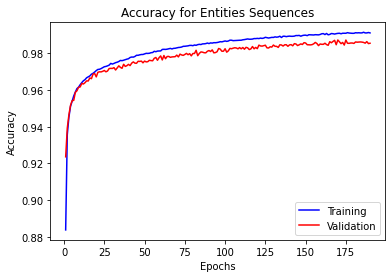

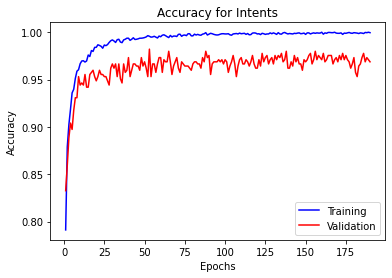

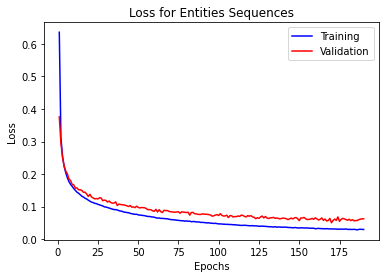

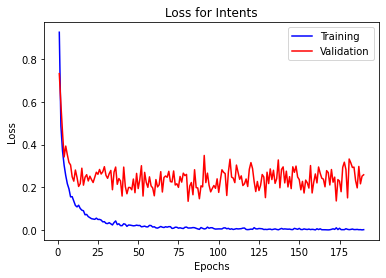

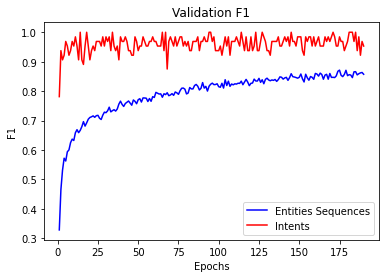

In [12]:
# Se definen funciones para evaluar el resultado del entrenamiento
def plot_training_validation_accuracy(history):
  acc_e = history.history['es_out_sparse_categorical_accuracy']
  val_acc_e = history.history['val_es_out_sparse_categorical_accuracy']

  acc_i = history.history['i_out_sparse_categorical_accuracy']
  val_acc_i = history.history['val_i_out_sparse_categorical_accuracy']

  epochs = range(1, len(acc_e) + 1)

  plt.plot(epochs, acc_e, 'b', label='Training')
  plt.plot(epochs, val_acc_e, 'r', label='Validation')
  plt.title('Accuracy for Entities Sequences')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

  plt.plot(epochs, acc_i, 'b', label='Training')
  plt.plot(epochs, val_acc_i, 'r', label='Validation')
  plt.title('Accuracy for Intents')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

def plot_training_validation_loss(history):
  loss_e = history.history['es_out_loss']
  val_loss_e = history.history['val_es_out_loss']

  loss_i = history.history['i_out_loss']
  val_loss_i = history.history['val_i_out_loss']

  epochs = range(1, len(loss_e) + 1)

  plt.plot(epochs, loss_e, 'b', label='Training')
  plt.plot(epochs, val_loss_e, 'r', label='Validation')
  plt.title('Loss for Entities Sequences')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  plt.plot(epochs, loss_i, 'b', label='Training')
  plt.plot(epochs, val_loss_i, 'r', label='Validation')
  plt.title('Loss for Intents')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

def plot_validation_f1(history):
  val_e_f1 = history.history['slots_f1']
  val_i_f1 = history.history['intent_f1']

  epochs = range(1, len(val_e_f1) + 1)
  
  plt.plot(epochs, val_e_f1, 'b', label='Entities Sequences')
  plt.plot(epochs, val_i_f1, 'r', label='Intents')
  plt.title('Validation F1')
  plt.xlabel('Epochs')
  plt.ylabel('F1')
  plt.legend()
  plt.show()
  
plot_training_validation_accuracy(history)
plot_training_validation_loss(history)
plot_validation_f1(history)

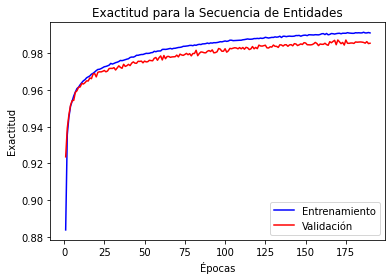

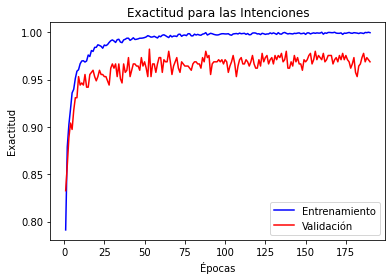

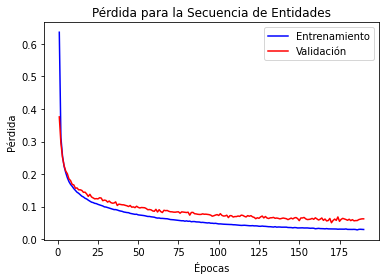

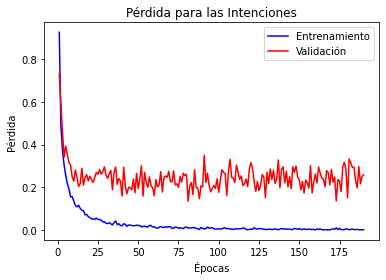

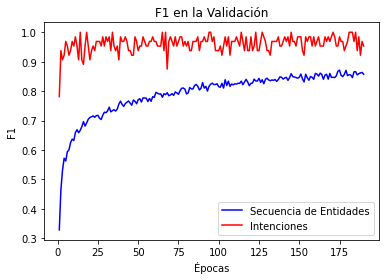

In [13]:
# Se definen funciones para evaluar el resultado del entrenamiento
def plot_training_validation_accuracy(history):
  acc_e = history.history['es_out_sparse_categorical_accuracy']
  val_acc_e = history.history['val_es_out_sparse_categorical_accuracy']

  acc_i = history.history['i_out_sparse_categorical_accuracy']
  val_acc_i = history.history['val_i_out_sparse_categorical_accuracy']

  epochs = range(1, len(acc_e) + 1)

  plt.plot(epochs, acc_e, 'b', label='Entrenamiento')
  plt.plot(epochs, val_acc_e, 'r', label='Validación')
  plt.title('Exactitud para la Secuencia de Entidades')
  plt.xlabel('Épocas')
  plt.ylabel('Exactitud')
  plt.legend()
  plt.show()

  plt.plot(epochs, acc_i, 'b', label='Entrenamiento')
  plt.plot(epochs, val_acc_i, 'r', label='Validación')
  plt.title('Exactitud para las Intenciones')
  plt.xlabel('Épocas')
  plt.ylabel('Exactitud')
  plt.legend()
  plt.show()

def plot_training_validation_loss(history):
  loss_e = history.history['es_out_loss']
  val_loss_e = history.history['val_es_out_loss']

  loss_i = history.history['i_out_loss']
  val_loss_i = history.history['val_i_out_loss']

  epochs = range(1, len(loss_e) + 1)

  plt.plot(epochs, loss_e, 'b', label='Entrenamiento')
  plt.plot(epochs, val_loss_e, 'r', label='Validación')
  plt.title('Pérdida para la Secuencia de Entidades')
  plt.xlabel('Épocas')
  plt.ylabel('Pérdida')
  plt.legend()
  plt.show()

  plt.plot(epochs, loss_i, 'b', label='Entrenamiento')
  plt.plot(epochs, val_loss_i, 'r', label='Validación')
  plt.title('Pérdida para las Intenciones')
  plt.xlabel('Épocas')
  plt.ylabel('Pérdida')
  plt.legend()
  plt.show()

def plot_validation_f1(history):
  val_e_f1 = history.history['slots_f1']
  val_i_f1 = history.history['intent_f1']

  epochs = range(1, len(val_e_f1) + 1)
  
  plt.plot(epochs, val_e_f1, 'b', label='Secuencia de Entidades')
  plt.plot(epochs, val_i_f1, 'r', label='Intenciones')
  plt.title('F1 en la Validación')
  plt.xlabel('Épocas')
  plt.ylabel('F1')
  plt.legend()
  plt.show()
  
plot_training_validation_accuracy(history)
plot_training_validation_loss(history)
plot_validation_f1(history)

In [15]:
# Se guardan los pesos del mejor modelo
!zip -r /content/postpadding_model_weights.zip /content/model-epoch:175-loss:0.039-val_loss:0.284-slots_f1:0.871weights

  adding: content/model-epoch:175-loss:0.039-val_loss:0.284-slots_f1:0.871weights/ (stored 0%)
  adding: content/model-epoch:175-loss:0.039-val_loss:0.284-slots_f1:0.871weights/assets/ (stored 0%)
  adding: content/model-epoch:175-loss:0.039-val_loss:0.284-slots_f1:0.871weights/variables/ (stored 0%)
  adding: content/model-epoch:175-loss:0.039-val_loss:0.284-slots_f1:0.871weights/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/model-epoch:175-loss:0.039-val_loss:0.284-slots_f1:0.871weights/variables/variables.index (deflated 73%)
  adding: content/model-epoch:175-loss:0.039-val_loss:0.284-slots_f1:0.871weights/keras_metadata.pb (deflated 93%)
  adding: content/model-epoch:175-loss:0.039-val_loss:0.284-slots_f1:0.871weights/saved_model.pb (deflated 90%)
